In [1]:
# this notebook contains 2 important graphs:
# 1. ex vs int
# 2. ex vs dapi

# read the introns 
# read the exons 
# find the correspondences 

In [5]:
# imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as matplt
import seaborn as sns
sns.set(style="darkgrid")

# import csv as csv

# general 
import os
import glob
from functools import reduce
import re
import sys as sys

from numpy import polyval
from scipy.spatial.distance import euclidean

%matplotlib inline

In [6]:
# keep track of versions for reproducibility
package_info = lambda p : print('%s: %s' % (p.__name__, p.__version__))

package_info(pd)
package_info(np)
package_info(matplt)
package_info(sns)

pandas: 0.23.4
numpy: 1.13.3
matplotlib: 2.0.2
seaborn: 0.9.0


In [55]:
# function for loading one data-set
def load_data(file_path, delimiter_ = '\t', skiprows_ = 0):
    data = np.loadtxt(file_path, delimiter = delimiter_, skiprows = skiprows_)
    # print(data.shape) 
    # handles some weird cases, e.g. when there is no data in the file
    if (len(data.shape) < 2):
        data = data[None, :]
    if (data.shape[1] == 0):
        I = np.array([0])
        z = np.array([0, 0, 0])
    else:
        I = data[:, -1]
        z = data[:, -4:-1]
    return (z, I)

# /Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_342.csv
# /Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_342.csv

In [70]:
# function for loading one data-set
def load_data_intron(file_path, delimiter_ = '\t', skiprows_ = 0):
    data = np.loadtxt(file_path, delimiter = delimiter_, skiprows=skiprows_)
    # print(data.shape) 
    # handles some weird cases, e.g. when there is no data in the file
#     if (len(data.shape) < 2):
#         data = data[None, :]
    if (data.shape[0] == 0):
        I = np.array([0])
        # z = np.array([0])
    else:
        I = data
        # z = data[:, -4:-1]
    return I

In [65]:
def load_data_new(file_path, delimiter_ = '\t', skiprows_ = 0):
    df = pd.read_csv(file_path, sep=delimiter_, header=None, names = ['x', 'y', 'z', 'I'])
    return df[['z', 'I']]

In [74]:
def load_data_intron_new(file_path, delimiter_ = '\t', skiprows_ = 0):
    df = pd.read_csv(file_path, sep=delimiter_, header=None, names = ['x', 'y', 'z', 'I'])
    return df[['I']]

In [9]:
# general setup for pretty images 
Ia_min, Ia_max = 0, 40000
za_min, za_max = 0, 55

# TODO: make this one a global argument
folder_path = '/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/'
experiment_name = 'N2'

In [10]:
# possible labels 
stain = ['DPY-23_EX', 'DPY-23_INT']
stage = 'E' # only embryos
comment = '' # only empty ones

In [11]:
# important indices
stain_columns = ['C0_stain', 'C1_stain', 'C2_stain', 'C3_stain', 'C4_stain']
type_columns = ['C0_type', 'C1_type', 'C2_type', 'C3_type', 'C4_type']
stain_prefix = np.array([['C1-', 'C2-', 'C3-', 'C4-', 'C5-']])
ext = '.csv'
filename_column = 'new filename'

In [12]:
# read the db and parse images that we want to process
df = pd.read_csv(folder_path + "smFISH-database/" + experiment_name + "-Table 1.csv", sep=',', na_values=['']);
df.head()

Line   ID  C0_lambda C0_stain    C0_type  C1_lambda C1_stain C1_type  \
0   N2  1.0      670.0     FISH  DPY-23_EX      488.0       AF     NaN   
1   N2  2.0      670.0     FISH  DPY-23_EX      488.0       AF     NaN   
2   N2  3.0      670.0     FISH  DPY-23_EX      488.0       AF     NaN   
3   N2  4.0      670.0     FISH  DPY-23_EX      488.0       AF     NaN   
4   N2  5.0      670.0     FISH  DPY-23_EX      488.0       AF     NaN   

   C2_lambda C2_stain    ...                 comment        date  \
0      405.0  NUCLEAR    ...            not complete  11/17/2016   
1      405.0  NUCLEAR    ...                    dirt  11/17/2016   
2      405.0  NUCLEAR    ...      dirt, not complete  11/17/2016   
3      405.0  NUCLEAR    ...                     NaN  11/17/2016   
4      405.0  NUCLEAR    ...            not complete  11/17/2016   

              original filename new filename  #nuclei #C0_smfish #C1_smfish  \
0  2016-11-17_N2-DPY-23-001.nd2         N2_1      2.0        NaN        NaN   
1  2016-11-17_N2-DPY-23-002.nd2         N2_2      4.0        NaN        NaN   
2  2016-11-17_N2-DPY-23-003.nd2         N2_3      1.0        NaN        NaN   
3  2016-11-17_N2-DPY-23-004.nd2         N2_4      1.0        NaN        NaN   
4  2016-11-17_N2-DPY-23-005.nd2         N2_5      3.0        NaN        NaN   

   #C2_smfish  #C3_smfish #C4_smfish  
0         NaN         NaN        NaN  
1         NaN         NaN        NaN  
2         NaN         NaN        NaN  
3         NaN         NaN        NaN  
4         NaN         NaN        NaN  

[5 rows x 30 columns]

In [37]:
# this is general
# filter to have only *good* and *embryo* files
good_indices = df[(df['stage'] == stage) & (df['comment'].isnull())].index
print(good_indices.shape)

(596,)


In [43]:
def choose_stains(df_, stain_id, good_indices):
    '''
    return list of stain filenames that should be processed
    '''
    dataset1 = []
    df_good = (df[type_columns].astype(np.object) == stain[stain_id]).loc[good_indices, :]
    row, col = np.where(df_good)    
    n_samples = df.shape[0]
    new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]    
    new_filename = df[filename_column].loc[good_indices].as_matrix()[row]
    dataset1 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]
    return dataset1

In [33]:
# OLD: REMOVE
# choose necessary stains
dataset1 = []
df_good = (df[type_columns].astype(np.object) == stain[0]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].as_matrix()[row]
dataset1 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

/Users/kkolyva/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [42]:
# OLD: REMOVE
# choose necessary stains
dataset2 = []
df_good = (df[type_columns].astype(np.object) == stain[1]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].as_matrix()[row]
dataset2 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

/Users/kkolyva/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [44]:
dataset1 = choose_stains(df, 0, good_indices)
dataset2 = choose_stains(df, 1, good_indices)

/Users/kkolyva/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [45]:
dataset1

['C1-N2_9',
 'C1-N2_16',
 'C1-N2_17',
 'C1-N2_23',
 'C1-N2_25',
 'C1-N2_27',
 'C1-N2_29',
 'C1-N2_51',
 'C1-N2_62',
 'C1-N2_63',
 'C1-N2_64',
 'C1-N2_65',
 'C1-N2_69',
 'C1-N2_72',
 'C1-N2_75',
 'C1-N2_80',
 'C1-N2_81',
 'C1-N2_82',
 'C1-N2_84',
 'C1-N2_85',
 'C1-N2_86',
 'C1-N2_87',
 'C1-N2_88',
 'C1-N2_89',
 'C1-N2_92',
 'C1-N2_93',
 'C1-N2_94',
 'C1-N2_95',
 'C1-N2_96',
 'C1-N2_97',
 'C1-N2_98',
 'C1-N2_99',
 'C1-N2_104',
 'C1-N2_106',
 'C1-N2_107',
 'C1-N2_108',
 'C1-N2_109',
 'C1-N2_110',
 'C1-N2_111',
 'C1-N2_112',
 'C1-N2_116',
 'C1-N2_117',
 'C1-N2_118',
 'C1-N2_123',
 'C1-N2_124',
 'C1-N2_125',
 'C1-N2_126',
 'C1-N2_127',
 'C1-N2_128',
 'C1-N2_129',
 'C1-N2_130',
 'C1-N2_137',
 'C1-N2_138',
 'C1-N2_139',
 'C1-N2_140',
 'C1-N2_141',
 'C1-N2_142',
 'C1-N2_143',
 'C1-N2_145',
 'C1-N2_146',
 'C1-N2_147',
 'C1-N2_148',
 'C1-N2_149',
 'C1-N2_159',
 'C1-N2_167',
 'C1-N2_173',
 'C1-N2_174',
 'C1-N2_176',
 'C1-N2_182',
 'C1-N2_183',
 'C1-N2_184',
 'C1-N2_189',
 'C1-N2_191',
 'C1-N2_199

In [46]:
def create_title(path, name_id=-1):
    # get the name of the initial image
    image_name = path.split("/")[name_id] # was 8
    # print(path.split("/"))
    # create the full title 
    title = image_name[:-4]
    return title
# create_title("/Users/kkolyva/Desktop/n2/N2-results/all/C1-N2_9.csv")

In [47]:
# actual plotting 
dataset_dpy23_ex = []
dataset_dpy23_int = []
p_dataset_dpy23_ex = []
p_dataset_dpy23_int = []

for j in range(0, len(dataset1)):
    # tmp = folder_path + "csv-before/" + dataset1[j] + ".csv"
    dataset_dpy23_ex.append(dataset1[j])
    # tmp = folder_path + "csv-parameters/" + dataset1[j] + ".csv"
    p_dataset_dpy23_ex.append(dataset1[j])
    # print(tmp)
    
for j in range(0, len(dataset2)):
    # tmp = folder_path + "csv-before/" + dataset4[j] + ".csv"
    dataset_dpy23_int.append(dataset2[j])
    # tmp = folder_path + "csv-parameters/" + dataset4[j] + ".csv"
    p_dataset_dpy23_int.append(dataset2[j])
    # print(tmp)
    
    
# to be sure that the results are consistent
# dataset_dpy23 = np.sort(dataset_dpy23)
# dataset_dpy23_int = np.sort(dataset_dpy23_int)
# dataset_mdh1 = np.sort(dataset_mdh1)

# p_dataset_dpy23 = np.sort(p_dataset_dpy23)
# p_dataset_dpy23_int = np.sort(p_dataset_dpy23_int)
# p_dataset_mdh1 = np.sort(p_dataset_mdh1)

dataset_dpy23_ex

['C1-N2_9',
 'C1-N2_16',
 'C1-N2_17',
 'C1-N2_23',
 'C1-N2_25',
 'C1-N2_27',
 'C1-N2_29',
 'C1-N2_51',
 'C1-N2_62',
 'C1-N2_63',
 'C1-N2_64',
 'C1-N2_65',
 'C1-N2_69',
 'C1-N2_72',
 'C1-N2_75',
 'C1-N2_80',
 'C1-N2_81',
 'C1-N2_82',
 'C1-N2_84',
 'C1-N2_85',
 'C1-N2_86',
 'C1-N2_87',
 'C1-N2_88',
 'C1-N2_89',
 'C1-N2_92',
 'C1-N2_93',
 'C1-N2_94',
 'C1-N2_95',
 'C1-N2_96',
 'C1-N2_97',
 'C1-N2_98',
 'C1-N2_99',
 'C1-N2_104',
 'C1-N2_106',
 'C1-N2_107',
 'C1-N2_108',
 'C1-N2_109',
 'C1-N2_110',
 'C1-N2_111',
 'C1-N2_112',
 'C1-N2_116',
 'C1-N2_117',
 'C1-N2_118',
 'C1-N2_123',
 'C1-N2_124',
 'C1-N2_125',
 'C1-N2_126',
 'C1-N2_127',
 'C1-N2_128',
 'C1-N2_129',
 'C1-N2_130',
 'C1-N2_137',
 'C1-N2_138',
 'C1-N2_139',
 'C1-N2_140',
 'C1-N2_141',
 'C1-N2_142',
 'C1-N2_143',
 'C1-N2_145',
 'C1-N2_146',
 'C1-N2_147',
 'C1-N2_148',
 'C1-N2_149',
 'C1-N2_159',
 'C1-N2_167',
 'C1-N2_173',
 'C1-N2_174',
 'C1-N2_176',
 'C1-N2_182',
 'C1-N2_183',
 'C1-N2_184',
 'C1-N2_189',
 'C1-N2_191',
 'C1-N2_199

In [48]:
labels = ['DPY-23_EX', 'MDH-1', "DPY-23_INT", "DAPI"]

In [49]:
# dpy23, mdh1, dpy23_intron
dataset_dpy23_ex_dpy23_int = []
for d1 in dataset_dpy23_ex:
    for d2 in dataset_dpy23_int:
        if (d1[3:] == d2[3:]):
            print(d1, d2) 
            dataset_dpy23_ex_dpy23_int.append([d1, d2])

C1-N2_342 C2-N2_342
C1-N2_343 C2-N2_343
C1-N2_344 C2-N2_344
C1-N2_345 C2-N2_345
C1-N2_346 C2-N2_346
C1-N2_347 C2-N2_347
C1-N2_348 C2-N2_348
C1-N2_349 C2-N2_349
C1-N2_350 C2-N2_350
C1-N2_351 C2-N2_351
C1-N2_352 C2-N2_352
C1-N2_353 C2-N2_353
C1-N2_354 C2-N2_354
C1-N2_355 C2-N2_355
C1-N2_356 C2-N2_356
C1-N2_357 C2-N2_357
C1-N2_358 C2-N2_358
C1-N2_359 C2-N2_359
C1-N2_360 C2-N2_360
C1-N2_361 C2-N2_361
C1-N2_362 C2-N2_362
C1-N2_363 C2-N2_363
C1-N2_364 C2-N2_364
C1-N2_365 C2-N2_365
C1-N2_366 C2-N2_366
C1-N2_367 C2-N2_367
C1-N2_368 C2-N2_368
C1-N2_369 C2-N2_369
C1-N2_370 C2-N2_370
C1-N2_371 C2-N2_371
C1-N2_372 C2-N2_372
C1-N2_373 C2-N2_373
C1-N2_374 C2-N2_374
C1-N2_375 C2-N2_375
C1-N2_376 C2-N2_376
C1-N2_377 C2-N2_377
C1-N2_378 C2-N2_378
C1-N2_379 C2-N2_379
C1-N2_380 C2-N2_380
C1-N2_381 C2-N2_381
C1-N2_382 C2-N2_382
C1-N2_383 C2-N2_383
C1-N2_384 C2-N2_384
C1-N2_385 C2-N2_385
C1-N2_386 C2-N2_386
C1-N2_387 C2-N2_387
C1-N2_388 C2-N2_388
C1-N2_389 C2-N2_389
C1-N2_393 C2-N2_393
C1-N2_394 C2-N2_394


In [50]:
def find_matches(I_dpy23_ex, loc_dpy23_ex, I_dpy23_int, loc_dpy23_int, threshold):
    
    loc_pair_dpy23_ex_dpy23_int = []
    I_pair_dpy23_ex_dpy23_int = [] 
    
    used_dpy23_ex = np.full((loc_dpy23_ex.shape[0], 1), False, dtype=bool)
    used_dpy23_int = np.full((loc_dpy23_int.shape[0], 1), False, dtype=bool)
    
    for i in range(0, loc_dpy23_ex.shape[0]):
        for j in range(0, loc_dpy23_int.shape[0]):
            if ((not used_dpy23_ex[i]) and (not used_dpy23_int[j]) and (euclidean(loc_dpy23_ex[i], loc_dpy23_int[j]) < threshold**2)):
                used_dpy23_ex[i] = True
                used_dpy23_int[j] = True
                # print(euclidean(loc_dpy23_ex[i], loc_dpy23_int[j]))
                loc_pair_dpy23_ex_dpy23_int.append([loc_dpy23_ex[i], loc_dpy23_int[j]])
                I_pair_dpy23_ex_dpy23_int.append([I_dpy23_ex[i], I_dpy23_int[j]])
    
    print('% of used spots: ', (np.sum(used_dpy23_ex) + np.sum(used_dpy23_int))/(len(used_dpy23_ex) + len(used_dpy23_ex)))
    return np.array(I_pair_dpy23_ex_dpy23_int), np.array(loc_pair_dpy23_ex_dpy23_int)

In [53]:
def get_info(I_above):
    info_text = "I > th: " + str(I_above)
    return info_text
get_info(10)

'I > th: 10'

In [75]:
# me use the locations only but no the intensities here 
# that is why we use csv-before folder
for img_name_dpy23_ex_dpy23_int in dataset_dpy23_ex_dpy23_int:
    
    img_name_dpy23_ex = img_name_dpy23_ex_dpy23_int[0]
    img_name_dpy23_int = img_name_dpy23_ex_dpy23_int[1]
       
    s_dataset_dpy23_int = folder_path + "csv-dapi-intron/" + img_name_dpy23_int + ".csv"
    # ps_dataset_dpy23_int = folder_path + "csv-parameters/" + img_name_dpy23_int + ".csv"

    s_dataset_dpy23_ex = folder_path + "csv-2/" + img_name_dpy23_ex + ".csv"
    # ps_dataset_dpy23_ex = folder_path + "csv-parameters/" + img_name_dpy23_ex + ".csv"
    
    if(not os.path.exists(s_dataset_dpy23_int) or not os.path.exists(s_dataset_dpy23_ex)):
        # print("doesn't exist")
        continue
    
    try:
        print(s_dataset_dpy23_int)
        print(s_dataset_dpy23_ex)
        
        df_dpy23_ex = load_data_new(s_dataset_dpy23_ex)
        df_dpy23_int = load_data_new(s_dataset_dpy23_int)  
        
        break
        
#         threshold = 2
#         I_pair_dpy23_ex_dpy23_int, loc_pair_dpy23_ex_dpy23_int = find_matches(I_dpy23_ex, loc_dpy23_ex, I_dpy23_int, loc_dpy23_int, threshold)
        
#         # feedback
#         plt.figure(figsize=(8,5))
#         title = create_title(s_dataset_dpy23_int, name_id=-1)[3:]
#         plt.title(title)
        
#         plt.plot(I_pair_dpy23_ex_dpy23_int[:, 0], I_pair_dpy23_ex_dpy23_int[:, 1], 'o', color='#8DC63F', linewidth=5)
        
#         x_limits = [0, 4]
#         y_limits = [0, 1]
        
#         axes = plt.gca()
#         axes.set_xlim(x_limits)
#         axes.set_ylim(y_limits)

#         plt.xlabel('$\mathregular{I_{exon}}$')
#         plt.ylabel('$\mathregular{I_{dapi}}$')
        
#         # info_text_dpy23 =     "Coeff (dpy23)    : " + str(['%.2e' % elem for elem in coeff_dpy23])
        # info_text_mdh1 =      "Coeff (mdh1)     : " + str(['%.2e' % elem for elem in coeff_mdh1])
        # info_text_dpy23_int = "Coeff (dpy23_int): " + str(['%.2e' % elem for elem in coeff_dpy23_int])
        
        # info_text = info_text_dpy23 + "\n" + info_text_mdh1 + "\n" + info_text_dpy23_int
        # plt.text(x_limits[0] + (x_limits[1] - x_limits[0])*0.02, y_limits[0] + (y_limits[1] - y_limits[0])*0.04, info_text, color='black', bbox=dict(facecolor='white', alpha=1), family='monospace')

        # plt.legend(loc = 'upper right')
        full_path_to_use = folder_path + "img-exon-dapi/" 
        if not os.path.exists(full_path_to_use):
            os.makedirs(full_path_to_use)
        plt.savefig(full_path_to_use + title + "-exon-dapi.pdf")
        
        plt.show()
    except(ValueError, StopIteration, RuntimeError):
        print("Caught the error for you")
        
#    break

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_342.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_342.csv


/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_342.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_342.csv
% of used spots:  1.0


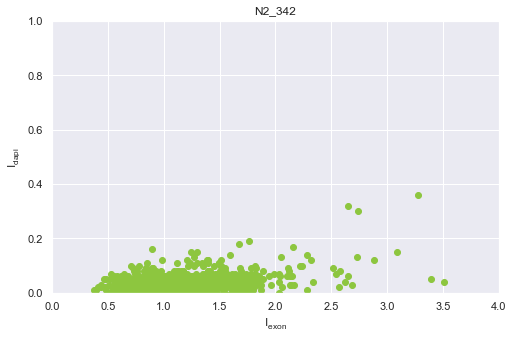

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_343.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_343.csv
% of used spots:  1.0


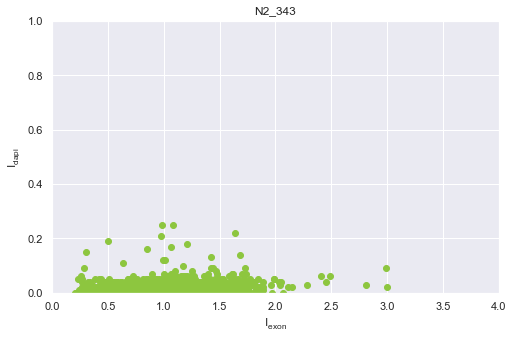

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_344.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_344.csv
% of used spots:  1.0


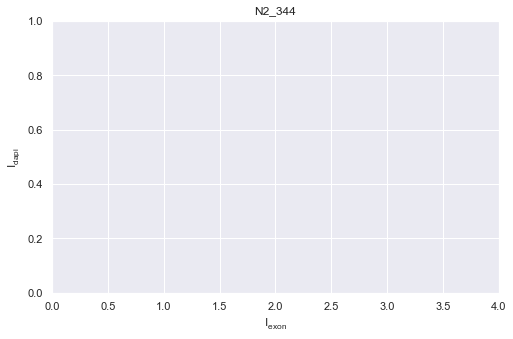

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_345.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_345.csv
% of used spots:  1.0


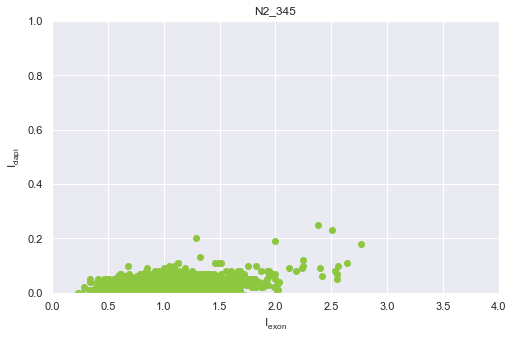

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_346.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_346.csv
% of used spots:  1.0


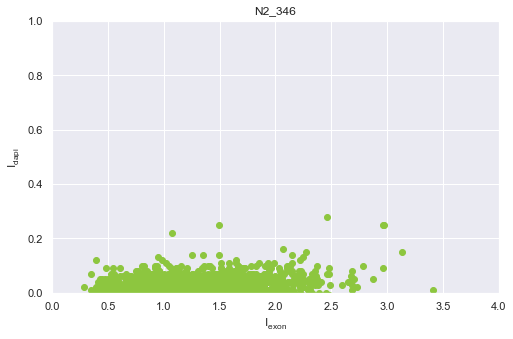

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_347.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_347.csv
% of used spots:  1.0


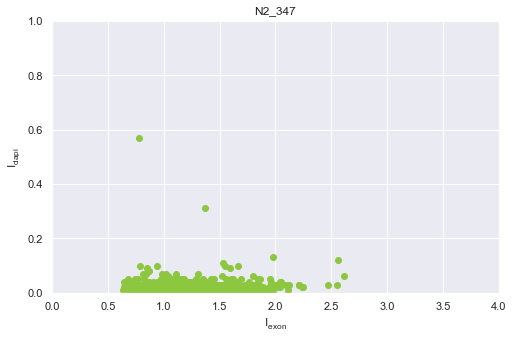

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_348.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_348.csv
% of used spots:  1.0


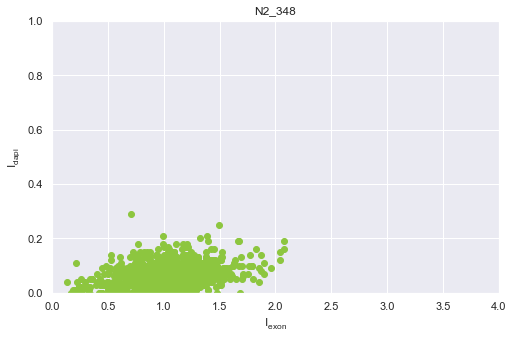

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_349.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_349.csv
% of used spots:  1.0


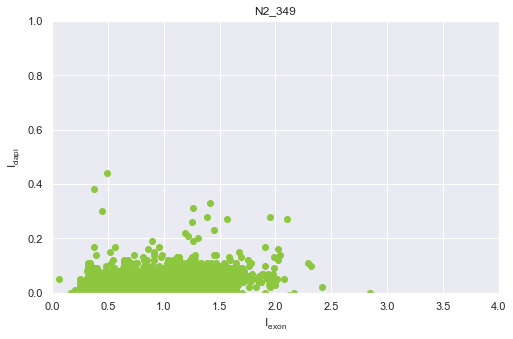

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_350.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_350.csv
% of used spots:  1.0


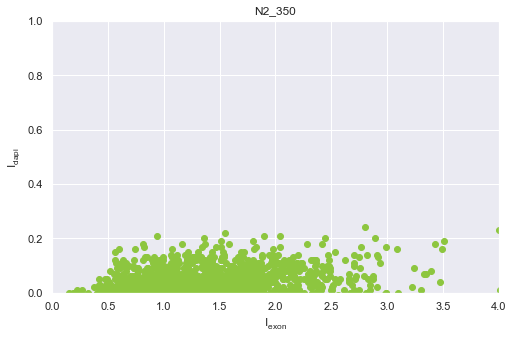

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_352.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_352.csv
% of used spots:  1.0


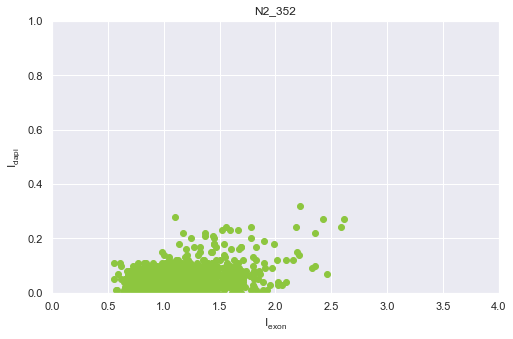

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_353.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_353.csv
% of used spots:  1.0


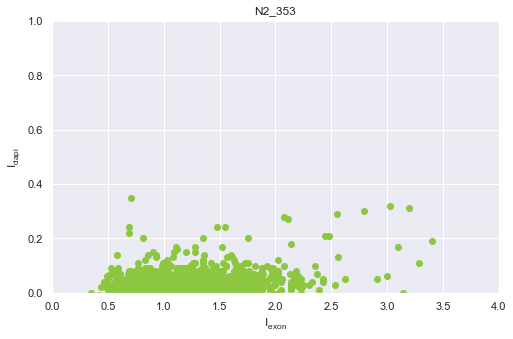

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_354.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_354.csv
% of used spots:  1.0


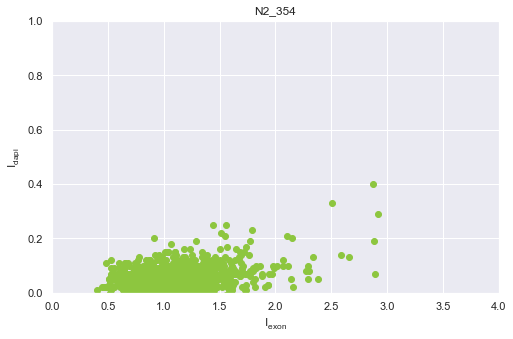

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_355.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_355.csv
% of used spots:  1.0


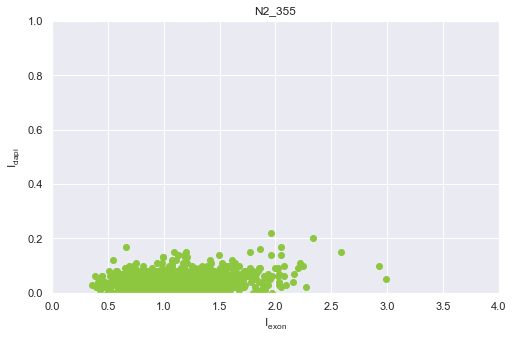

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_356.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_356.csv
% of used spots:  1.0


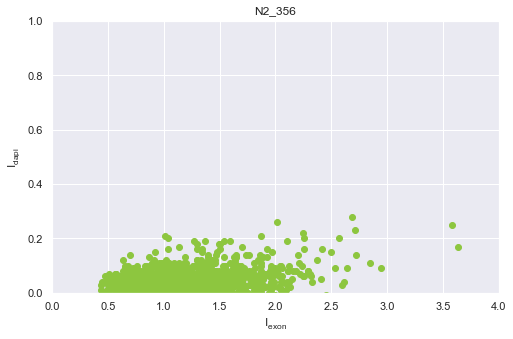

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_357.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_357.csv
% of used spots:  1.0


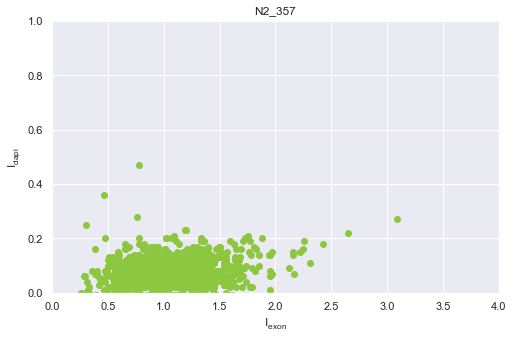

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_358.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_358.csv
% of used spots:  1.0


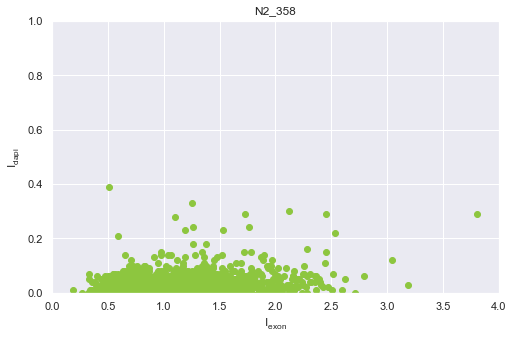

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_359.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_359.csv
% of used spots:  1.0


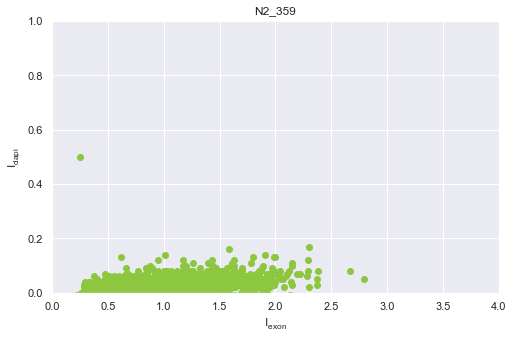

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_360.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_360.csv
% of used spots:  1.0


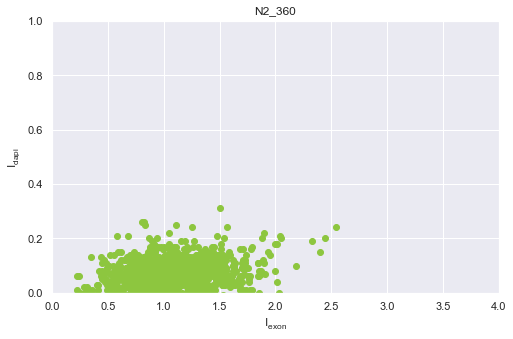

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_361.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_361.csv
% of used spots:  1.0


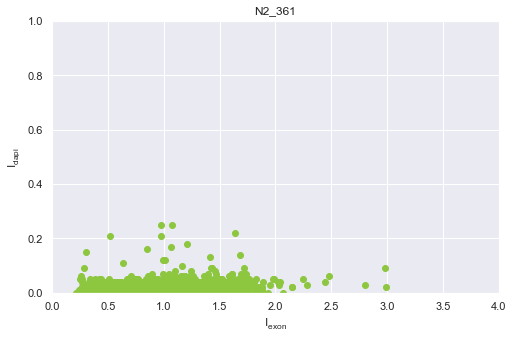

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_362.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_362.csv
% of used spots:  1.0


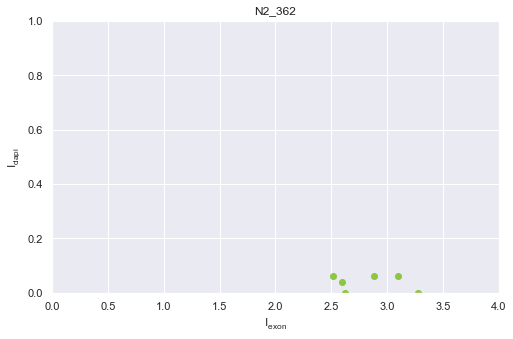

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_363.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_363.csv
% of used spots:  1.0


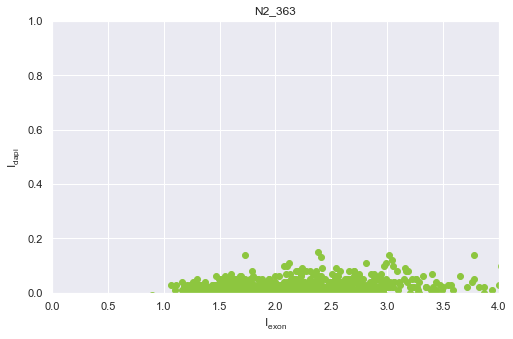

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_364.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_364.csv
% of used spots:  1.0


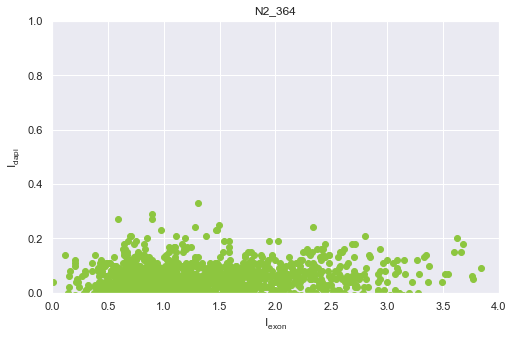

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_365.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_365.csv
% of used spots:  1.0


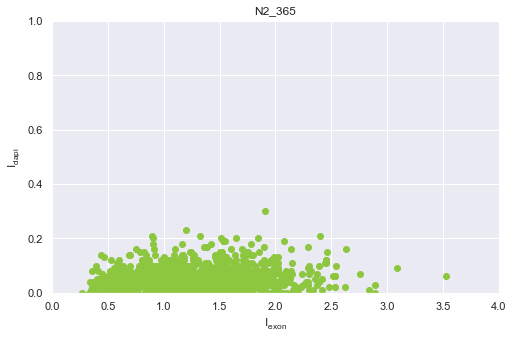

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_366.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_366.csv
% of used spots:  1.0


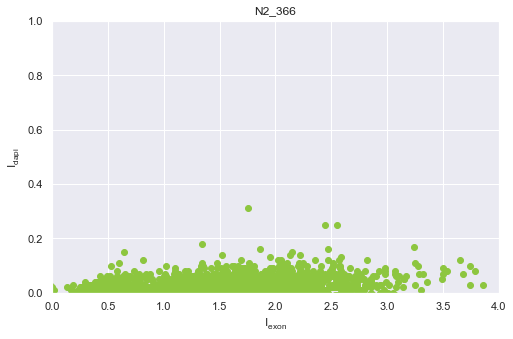

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_367.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_367.csv


KeyboardInterrupt: 

In [52]:
# me use the locations only but no the intensities here 
# that is why we use csv-before folder
for img_name_dpy23_ex_dpy23_int in dataset_dpy23_ex_dpy23_int:
    
    img_name_dpy23_ex = img_name_dpy23_ex_dpy23_int[0]
    img_name_dpy23_int = img_name_dpy23_ex_dpy23_int[1]
       
    s_dataset_dpy23_int = folder_path + "csv-dapi-intron/" + img_name_dpy23_int + ".csv"
    # ps_dataset_dpy23_int = folder_path + "csv-parameters/" + img_name_dpy23_int + ".csv"

    s_dataset_dpy23_ex = folder_path + "csv-2/" + img_name_dpy23_ex + ".csv"
    # ps_dataset_dpy23_ex = folder_path + "csv-parameters/" + img_name_dpy23_ex + ".csv"
    
    if(not os.path.exists(s_dataset_dpy23_int) or not os.path.exists(s_dataset_dpy23_ex)):
        # print("doesn't exist")
        continue
    
    try:
        print(s_dataset_dpy23_int)
        print(s_dataset_dpy23_ex)
        
        loc_dpy23_ex, I_dpy23_ex = load_data(s_dataset_dpy23_ex)
        loc_dpy23_int, I_dpy23_int = load_data(s_dataset_dpy23_int)  
        
        threshold = 2
        I_pair_dpy23_ex_dpy23_int, loc_pair_dpy23_ex_dpy23_int = find_matches(I_dpy23_ex, loc_dpy23_ex, I_dpy23_int, loc_dpy23_int, threshold)
        
        # feedback
        plt.figure(figsize=(8,5))
        title = create_title(s_dataset_dpy23_int, name_id=-1)[3:]
        plt.title(title)
        
        plt.plot(I_pair_dpy23_ex_dpy23_int[:, 0], I_pair_dpy23_ex_dpy23_int[:, 1], 'o', color='#8DC63F', linewidth=5)
        
        x_limits = [0, 4]
        y_limits = [0, 1]
        
        axes = plt.gca()
        axes.set_xlim(x_limits)
        axes.set_ylim(y_limits)

        plt.xlabel('$\mathregular{I_{exon}}$')
        plt.ylabel('$\mathregular{I_{dapi}}$')
        
        # info_text_dpy23 =     "Coeff (dpy23)    : " + str(['%.2e' % elem for elem in coeff_dpy23])
        # info_text_mdh1 =      "Coeff (mdh1)     : " + str(['%.2e' % elem for elem in coeff_mdh1])
        # info_text_dpy23_int = "Coeff (dpy23_int): " + str(['%.2e' % elem for elem in coeff_dpy23_int])
        
        # info_text = info_text_dpy23 + "\n" + info_text_mdh1 + "\n" + info_text_dpy23_int
        # plt.text(x_limits[0] + (x_limits[1] - x_limits[0])*0.02, y_limits[0] + (y_limits[1] - y_limits[0])*0.04, info_text, color='black', bbox=dict(facecolor='white', alpha=1), family='monospace')

        # plt.legend(loc = 'upper right')
        full_path_to_use = folder_path + "img-exon-dapi/" 
        if not os.path.exists(full_path_to_use):
            os.makedirs(full_path_to_use)
        plt.savefig(full_path_to_use + title + "-exon-dapi.pdf")
        
        plt.show()
    except(ValueError, StopIteration, RuntimeError):
        print("Caught the error for you")
        
#    break

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_342.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_342.csv


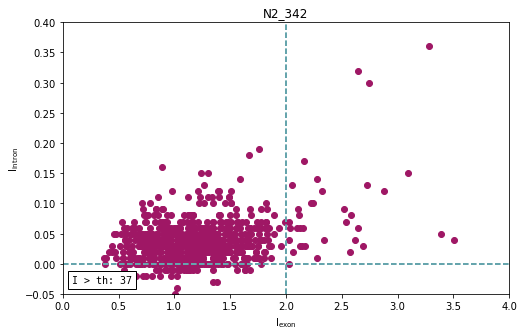

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_343.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_343.csv


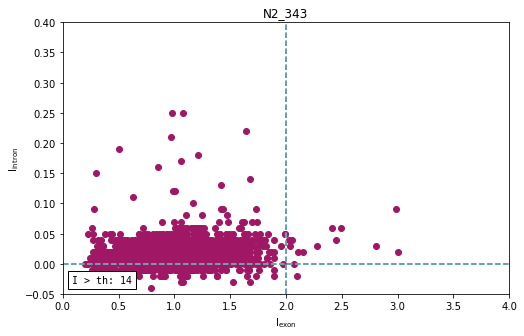

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_344.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_344.csv


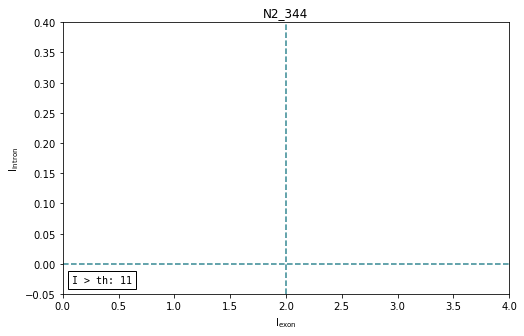

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_345.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_345.csv


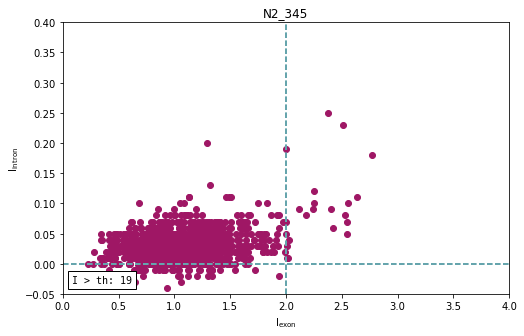

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_346.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_346.csv


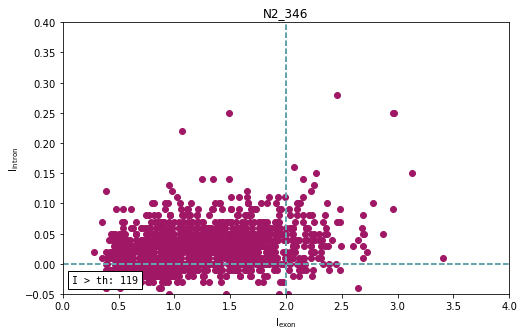

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_347.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_347.csv


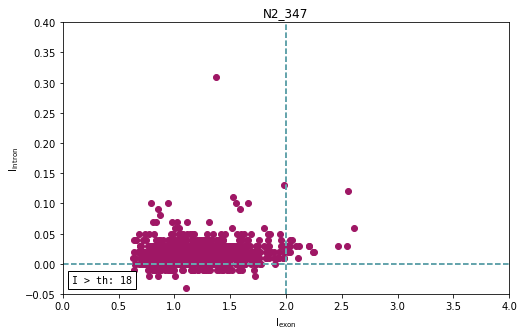

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_348.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_348.csv


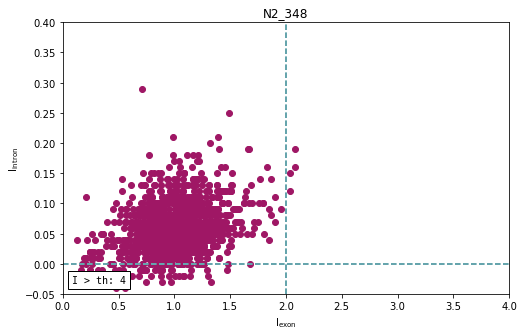

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_349.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_349.csv


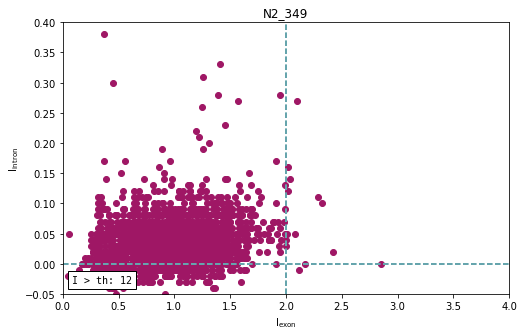

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_350.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_350.csv


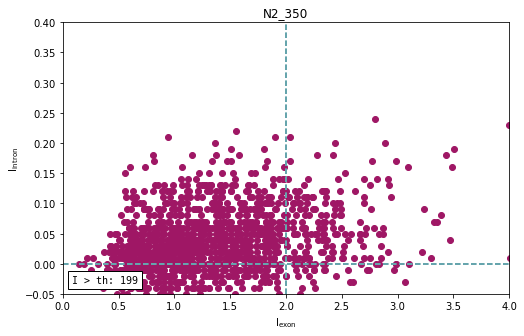

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_352.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_352.csv


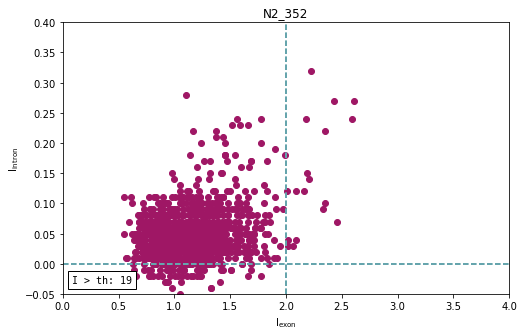

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_353.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_353.csv


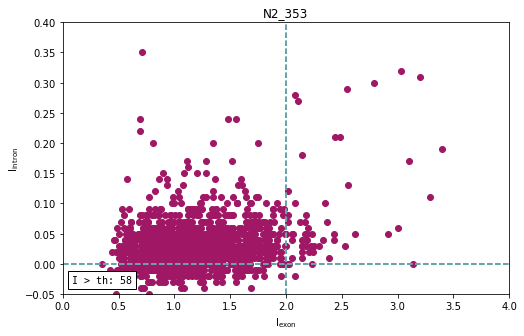

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_354.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_354.csv


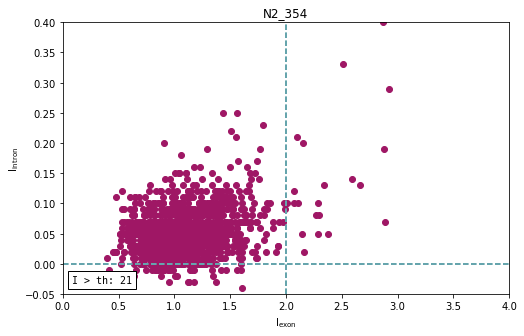

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_355.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_355.csv


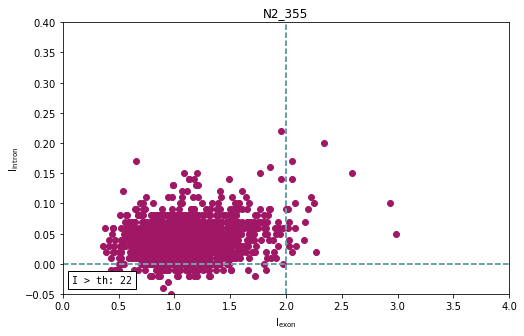

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_356.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_356.csv


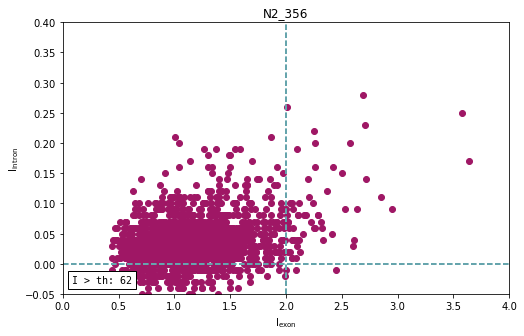

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_357.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_357.csv


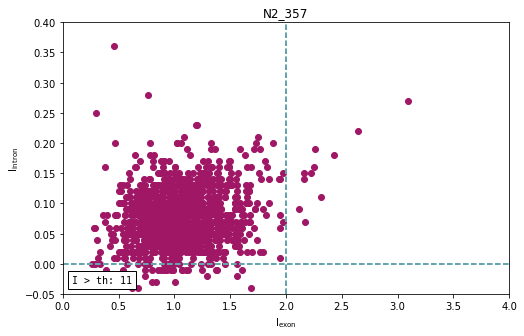

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_358.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_358.csv


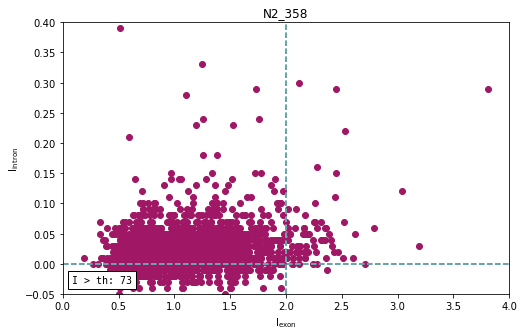

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_359.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_359.csv


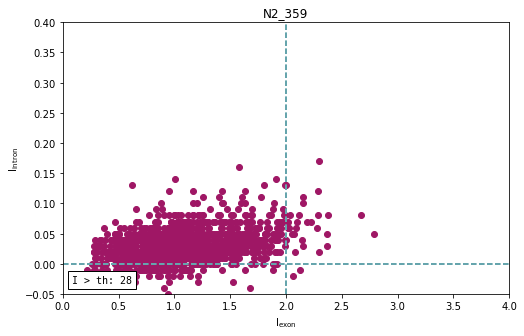

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_360.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_360.csv


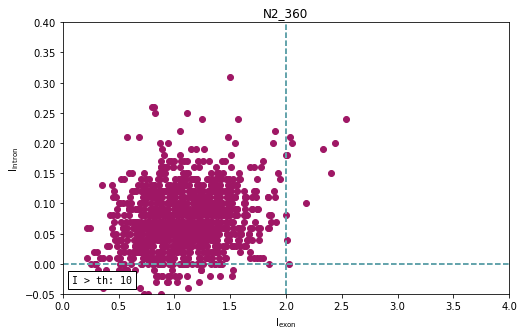

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_361.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_361.csv


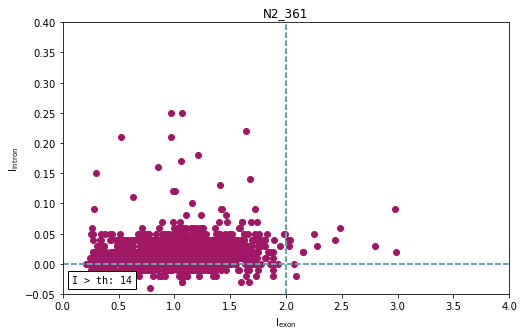

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_362.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_362.csv


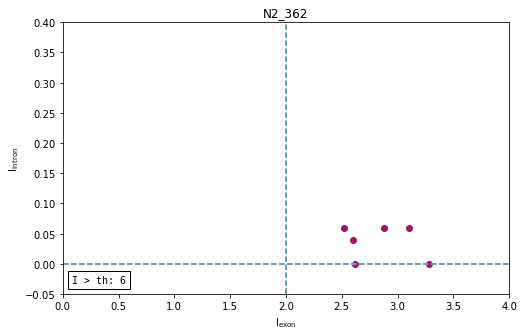

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_363.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_363.csv


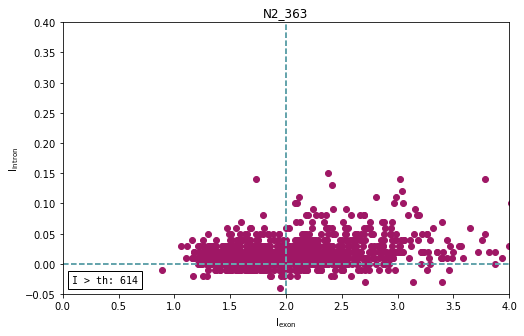

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_364.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_364.csv


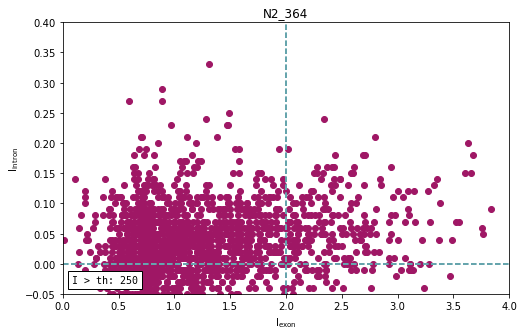

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_365.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_365.csv


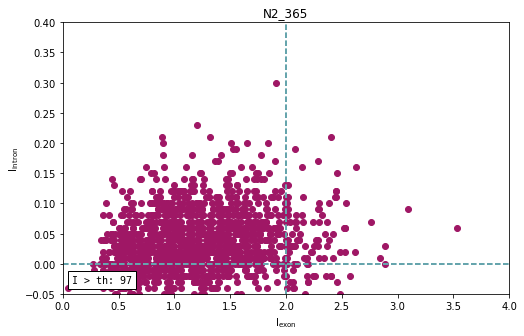

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_366.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_366.csv


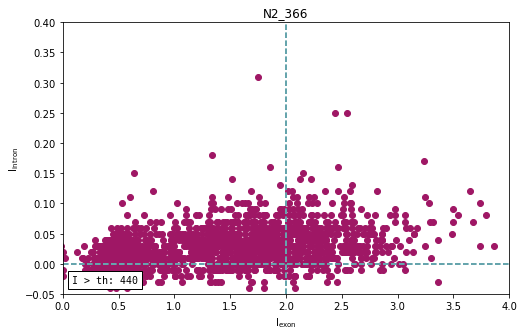

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_367.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_367.csv


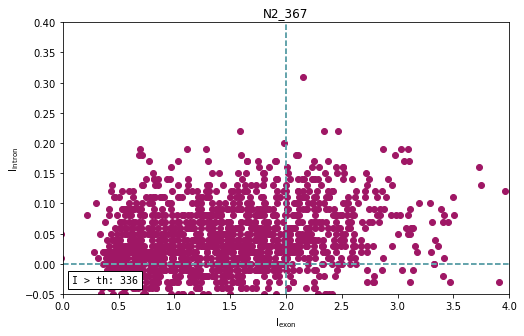

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_368.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_368.csv


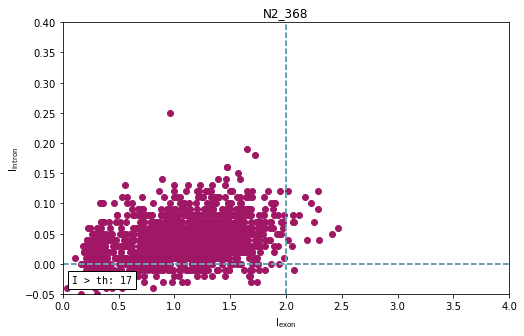

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_369.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_369.csv


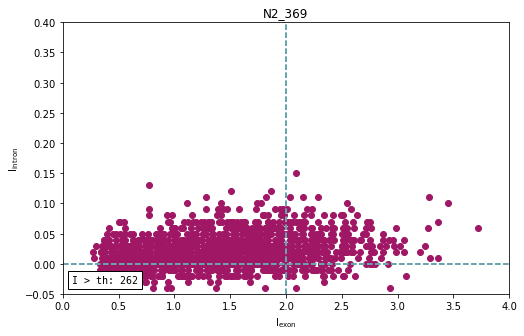

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_370.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_370.csv


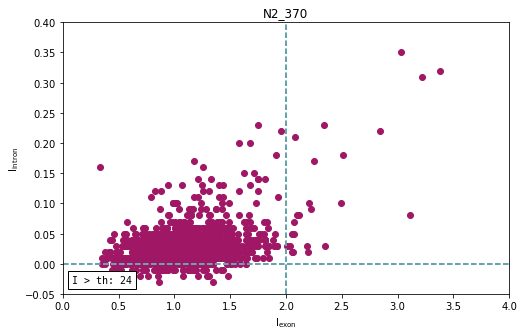

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_371.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_371.csv


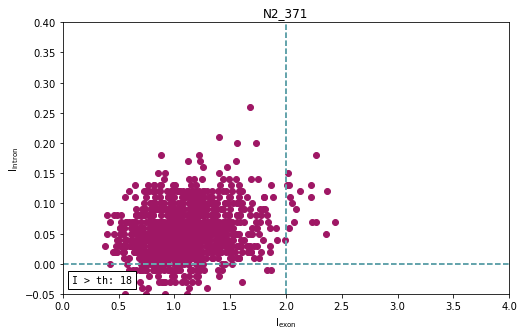

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_372.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_372.csv


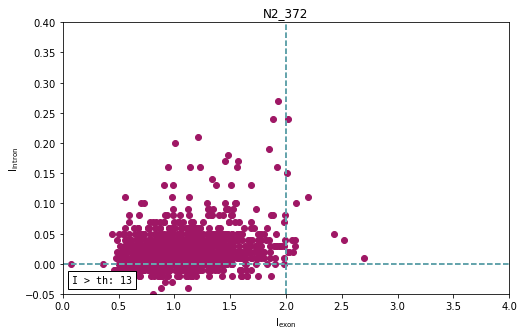

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_373.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_373.csv


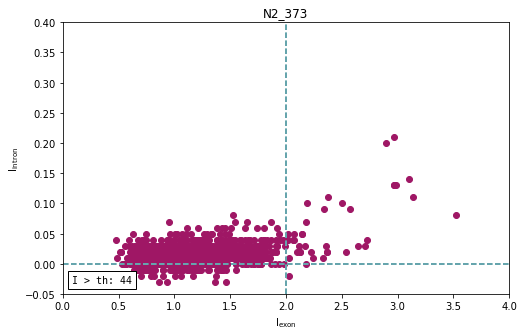

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_374.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_374.csv


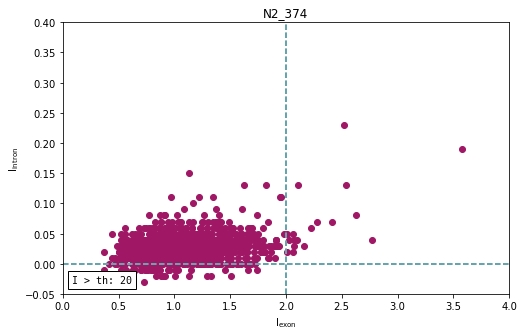

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_375.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_375.csv


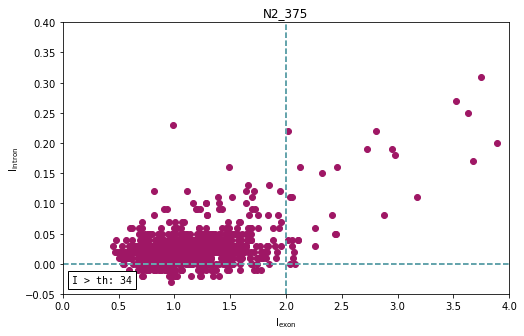

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_376.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_376.csv


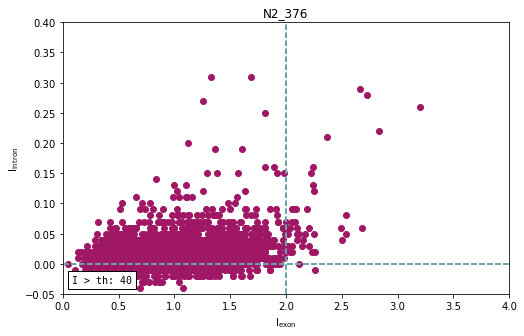

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_377.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_377.csv


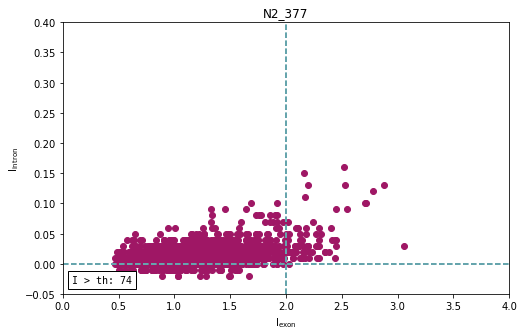

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_378.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_378.csv


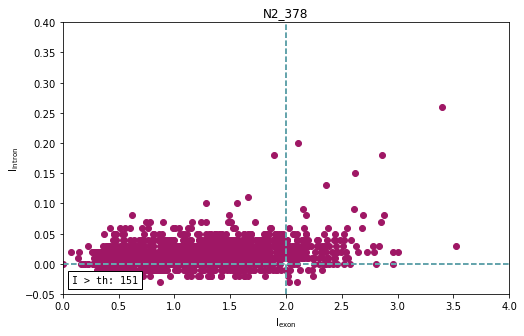

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_379.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_379.csv


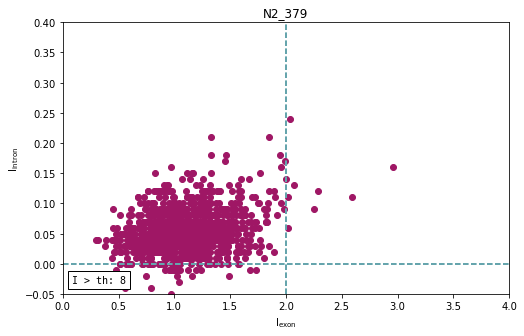

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_380.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_380.csv


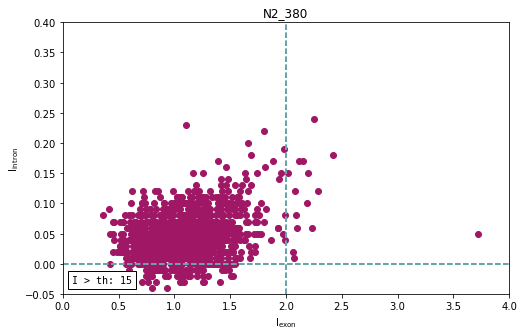

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_381.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_381.csv


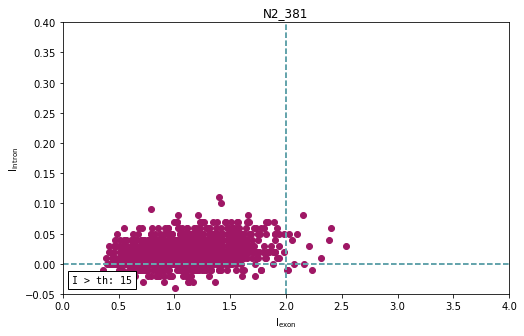

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_382.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_382.csv


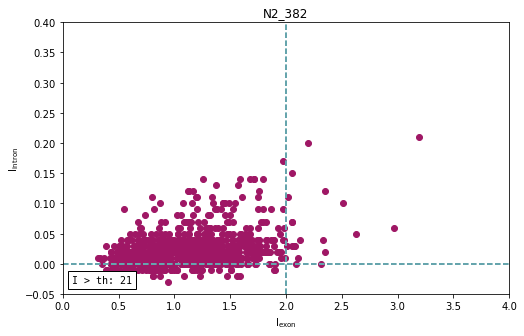

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_383.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_383.csv


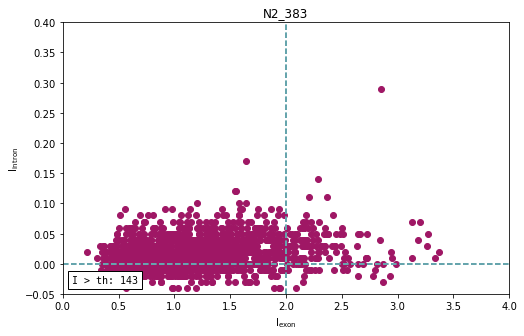

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_384.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_384.csv


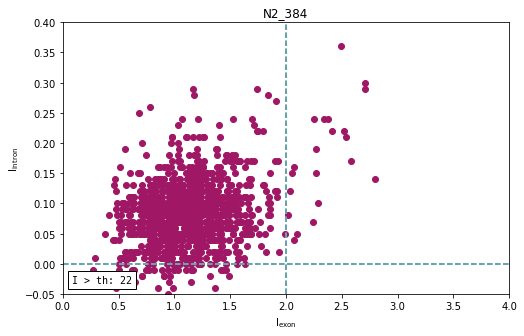

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_385.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_385.csv


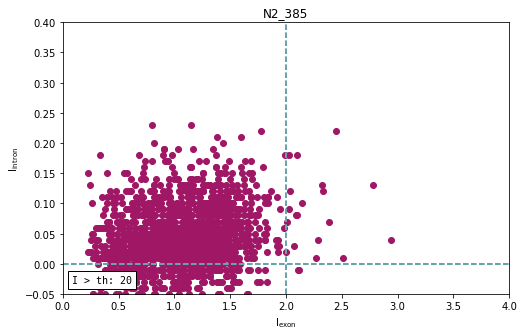

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_386.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_386.csv


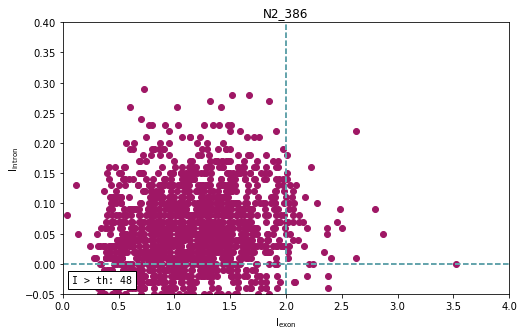

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_387.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_387.csv


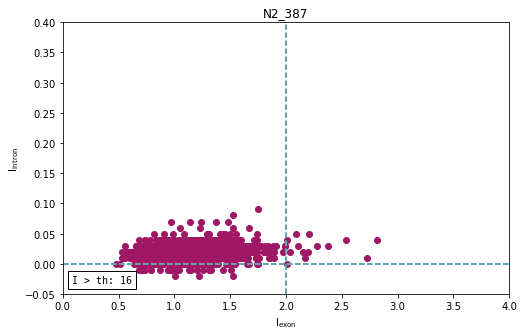

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_388.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_388.csv


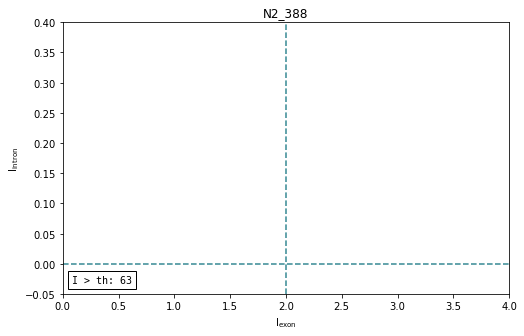

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_389.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_389.csv


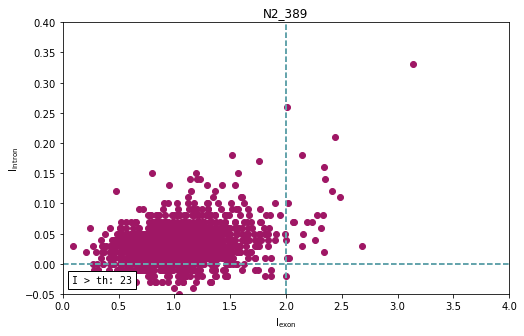

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_393.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_393.csv


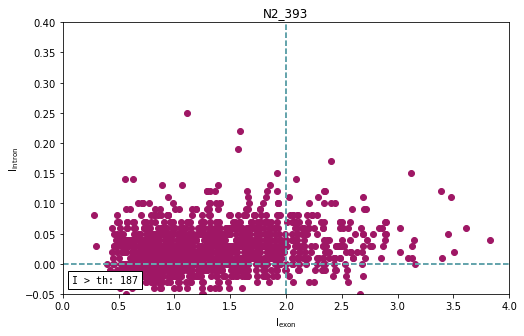

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_394.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_394.csv


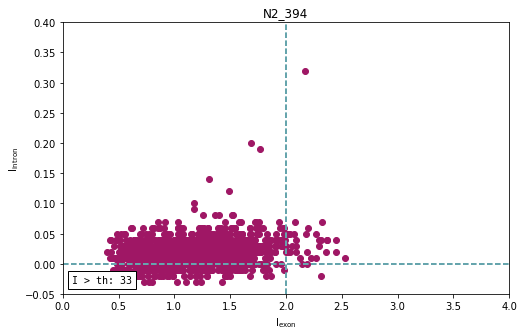

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C2-N2_395.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_395.csv


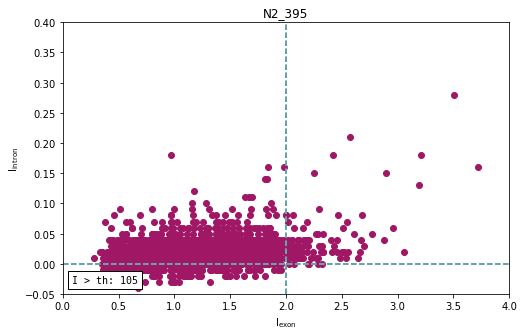

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_447.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_447.csv


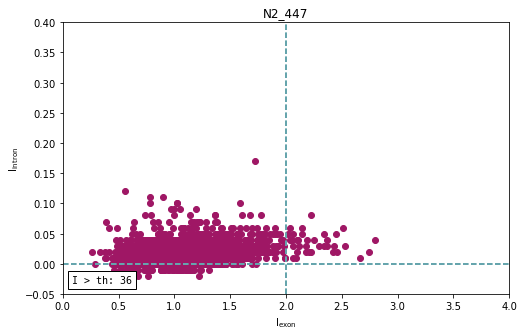

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_448.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_448.csv


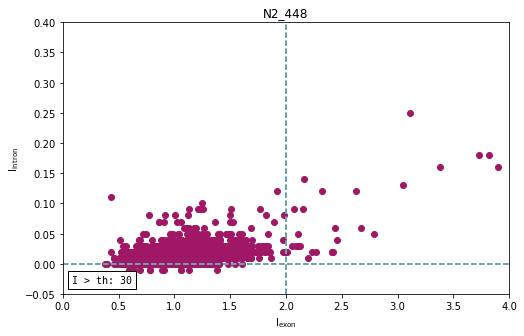

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_449.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_449.csv


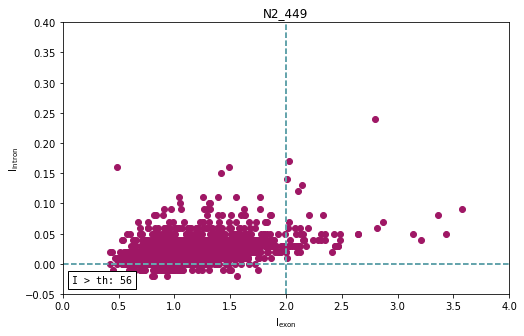

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_451.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_451.csv


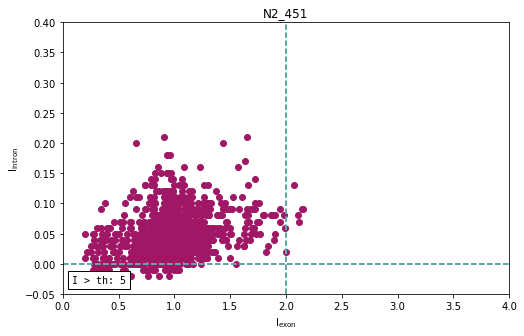

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_452.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_452.csv


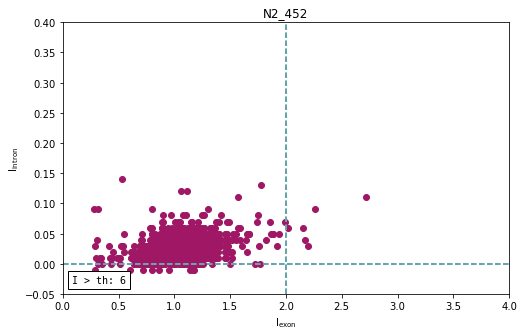

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_453.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_453.csv


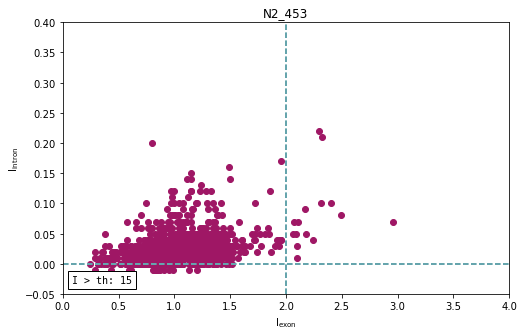

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_454.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_454.csv


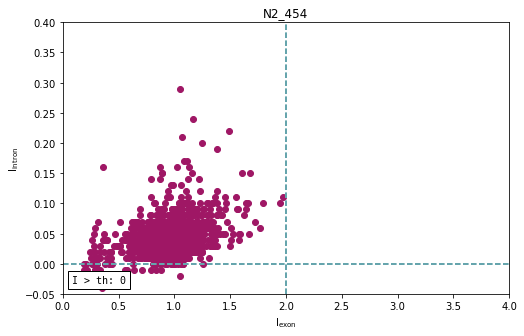

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_455.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_455.csv


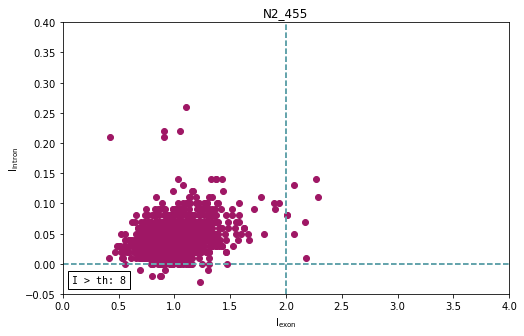

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_456.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_456.csv


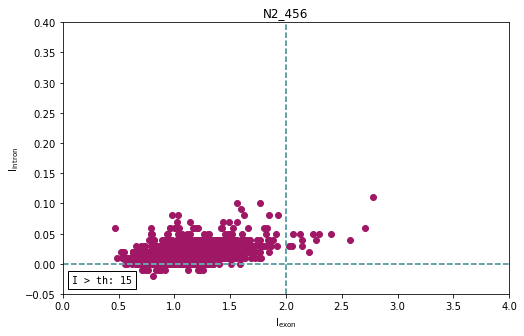

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_457.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_457.csv


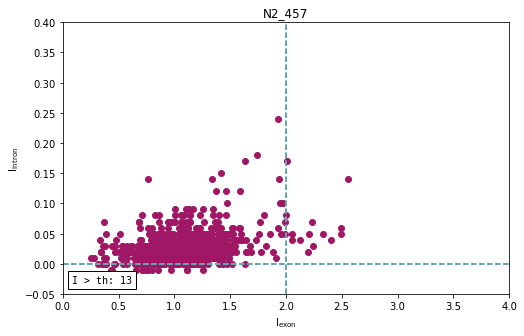

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_459.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_459.csv


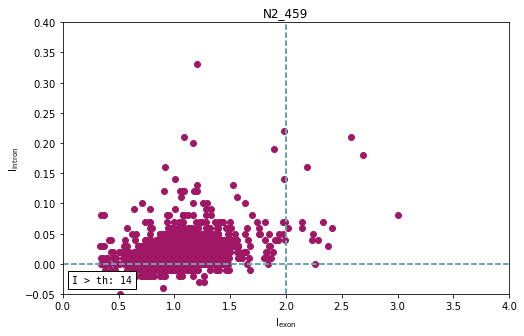

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_460.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_460.csv


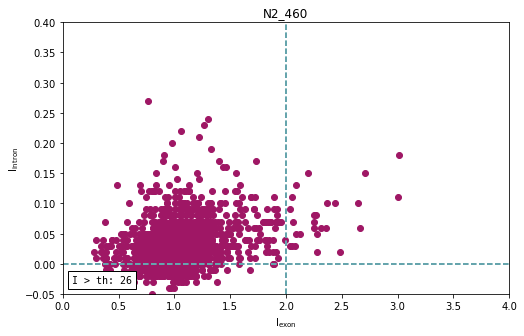

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_461.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_461.csv


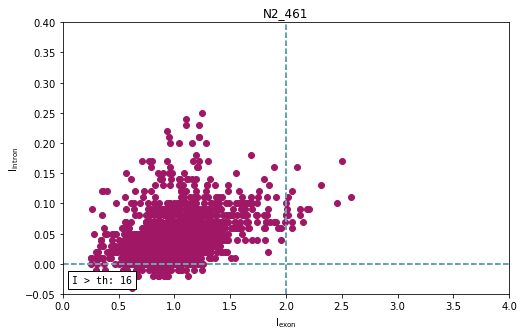

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_462.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_462.csv


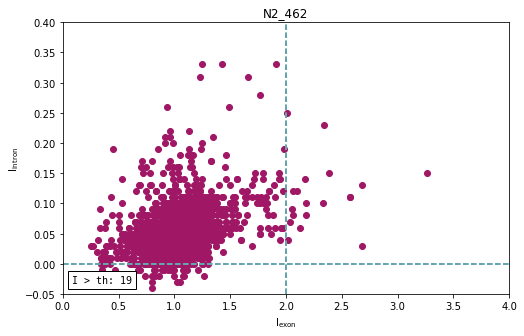

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_463.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_463.csv


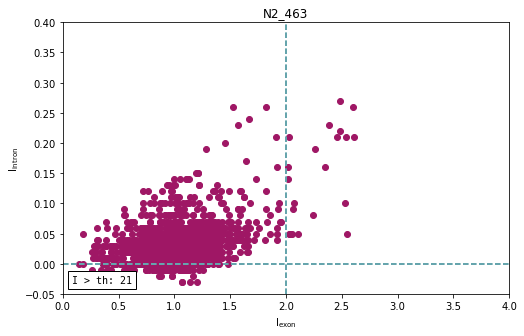

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_464.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_464.csv


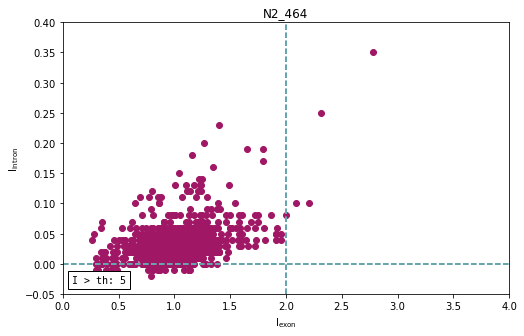

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_465.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_465.csv


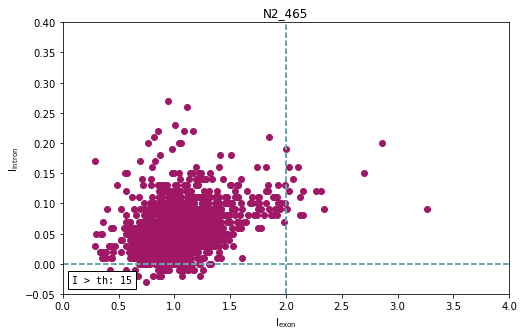

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_466.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_466.csv


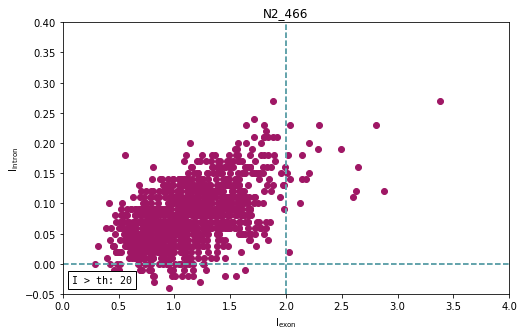

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_467.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_467.csv


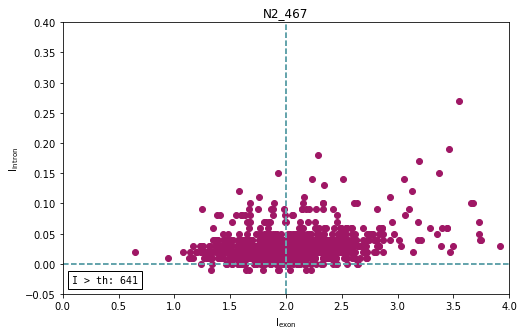

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_469.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_469.csv


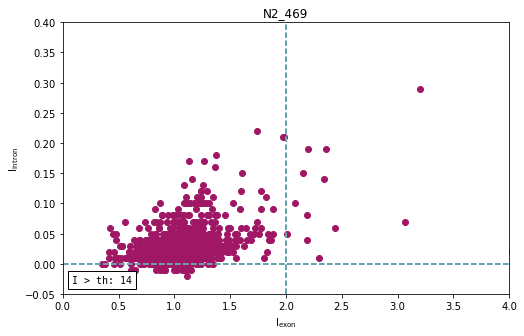

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_470.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_470.csv


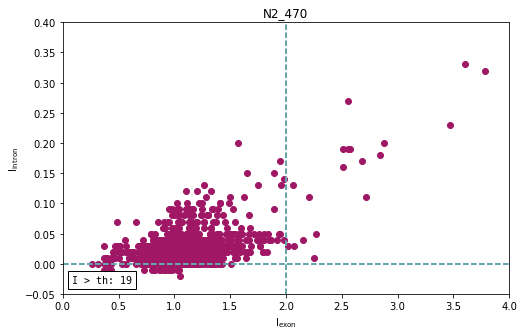

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_471.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_471.csv


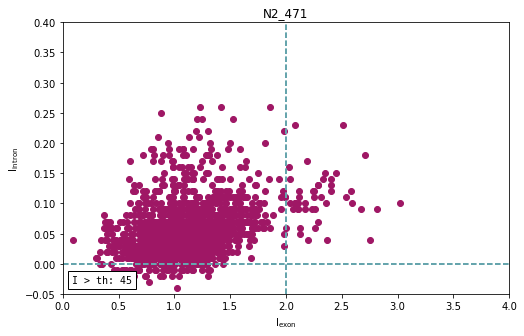

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_472.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_472.csv


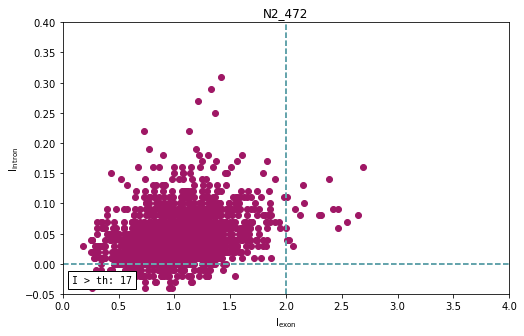

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_473.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_473.csv


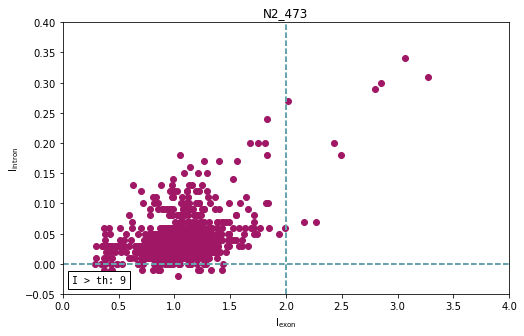

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_474.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_474.csv


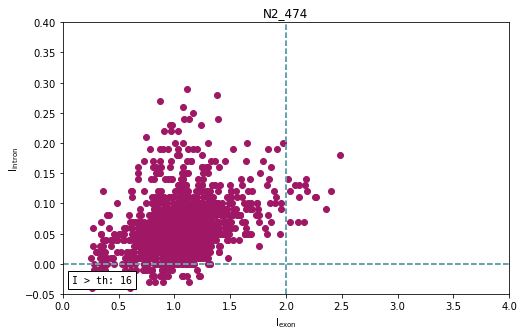

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_475.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_475.csv


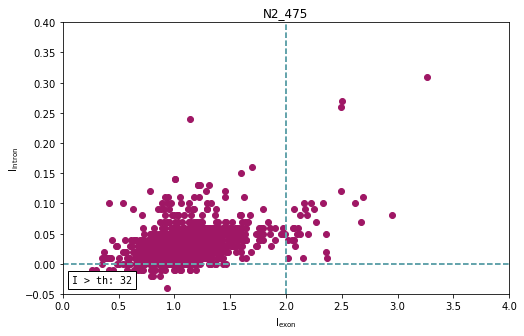

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_476.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_476.csv


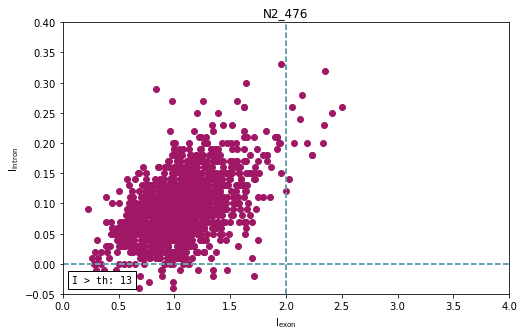

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_477.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_477.csv


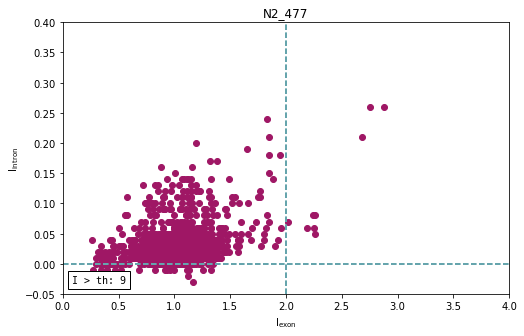

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_478.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_478.csv


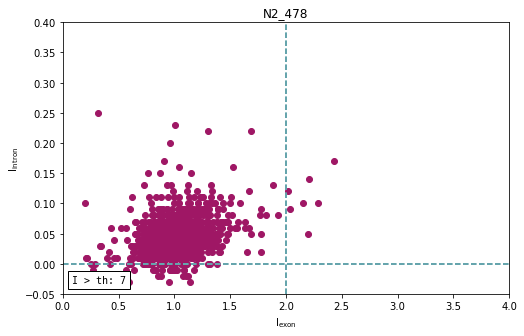

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_479.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_479.csv


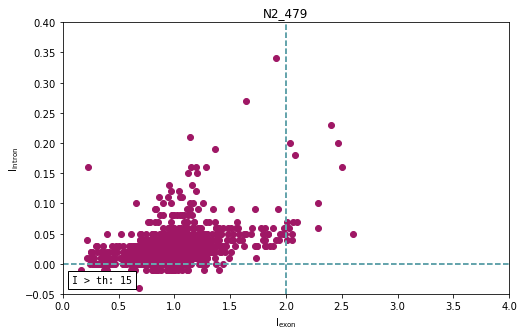

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_480.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_480.csv


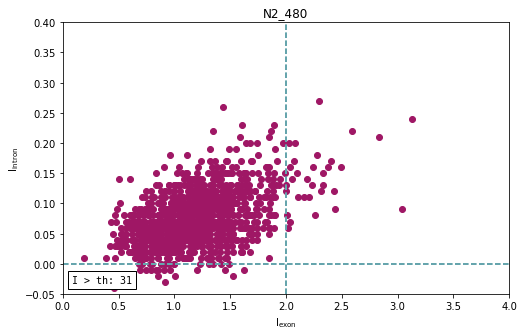

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_481.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_481.csv


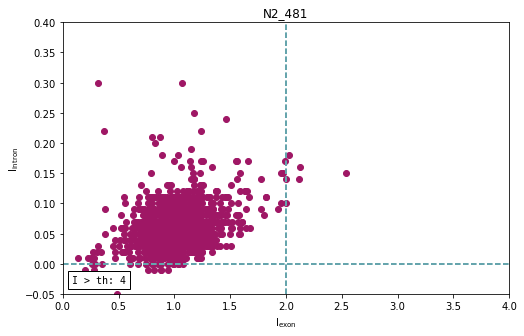

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_482.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_482.csv


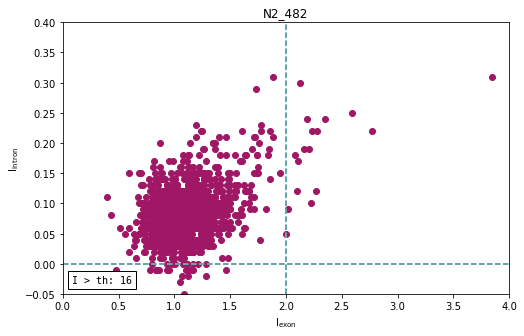

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_483.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_483.csv


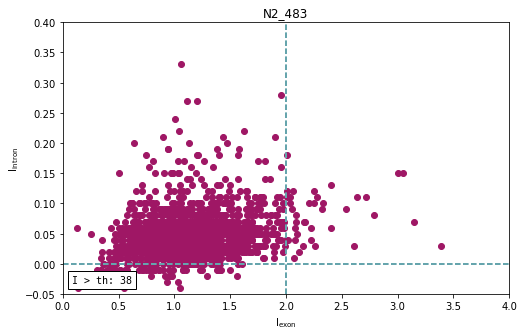

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_484.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_484.csv


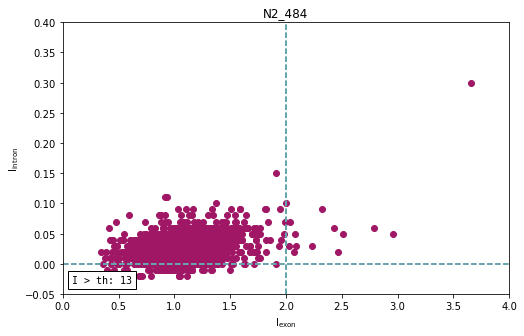

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_485.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_485.csv


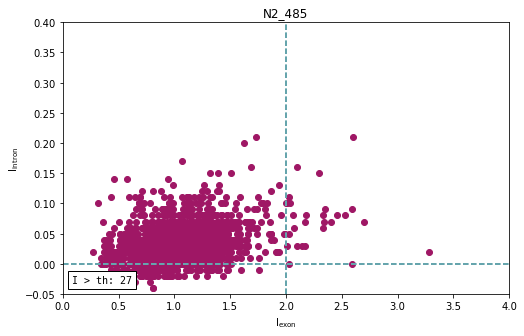

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_486.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_486.csv


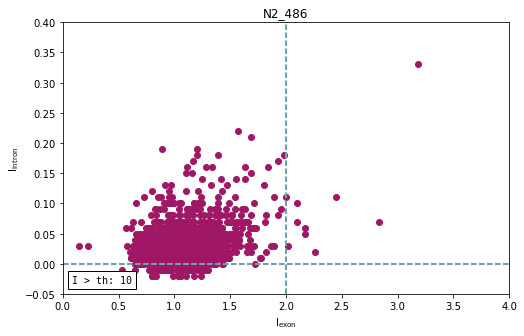

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_487.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_487.csv


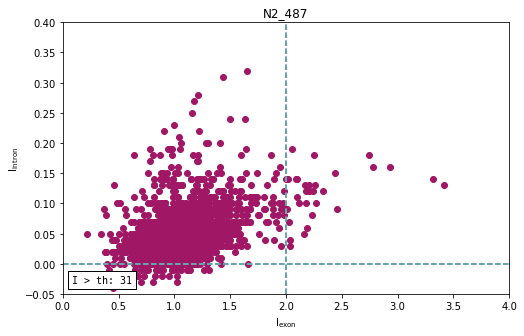

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_488.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_488.csv


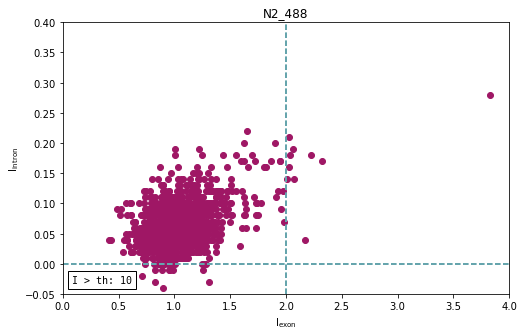

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_489.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_489.csv


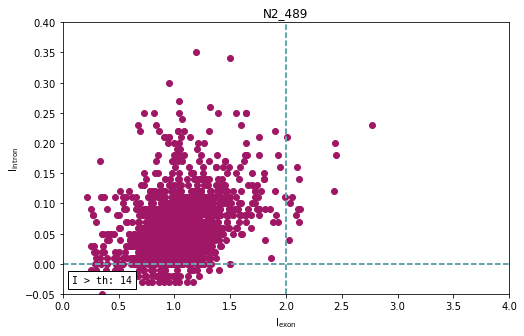

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_490.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_490.csv


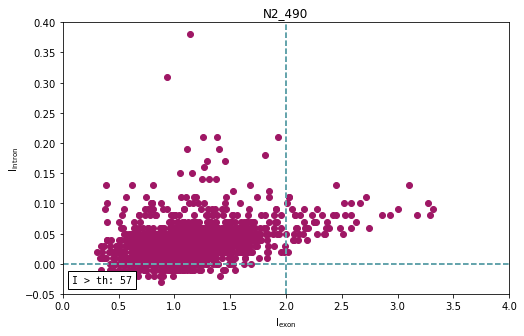

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_491.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_491.csv


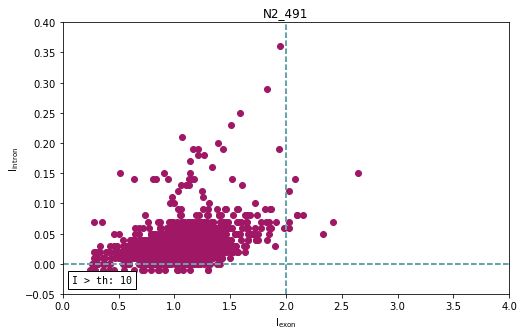

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_492.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_492.csv


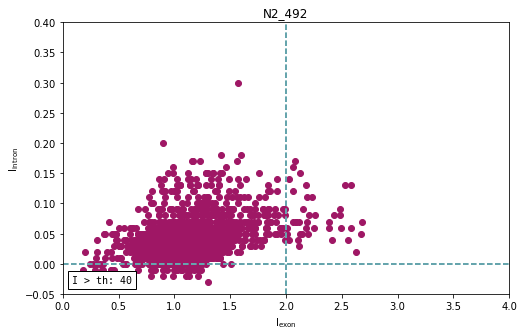

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_493.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_493.csv


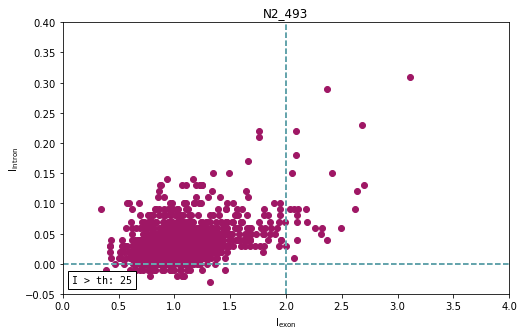

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_494.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_494.csv


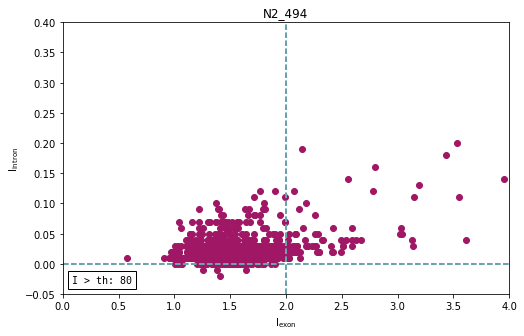

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_495.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_495.csv


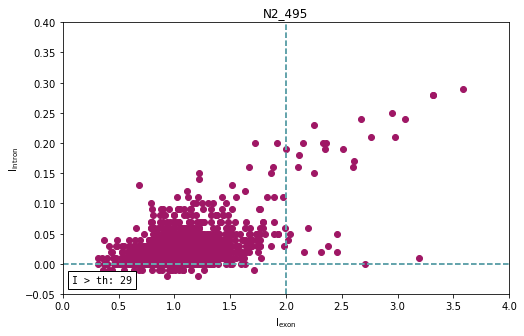

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_496.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_496.csv


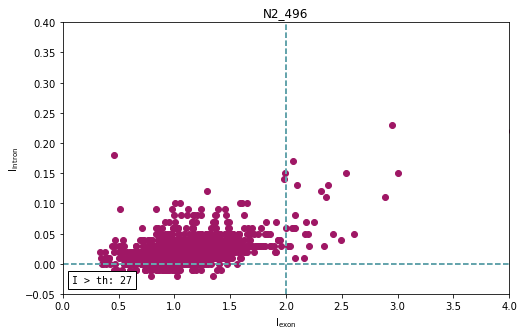

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_498.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_498.csv


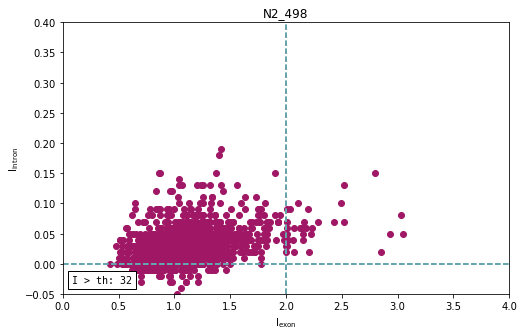

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_499.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_499.csv


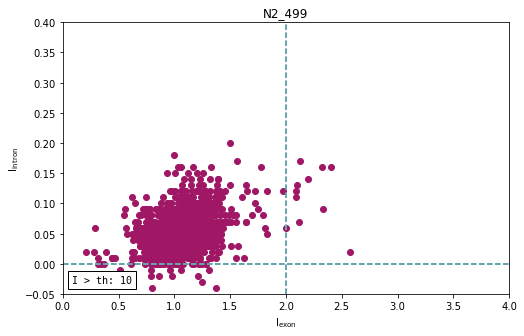

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_500.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_500.csv


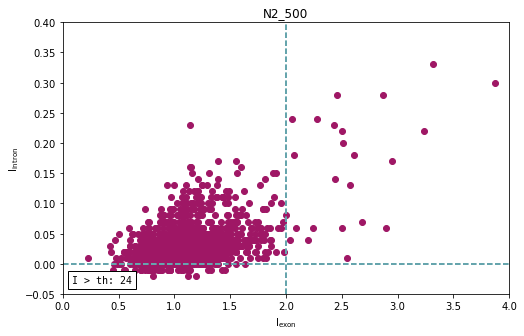

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_501.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_501.csv


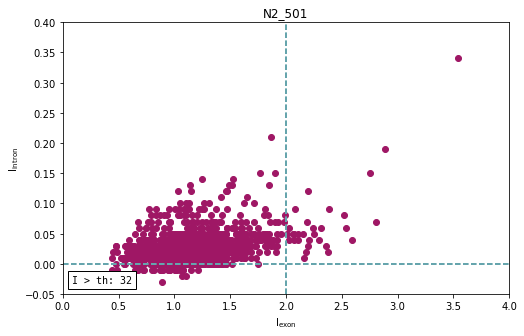

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_502.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_502.csv


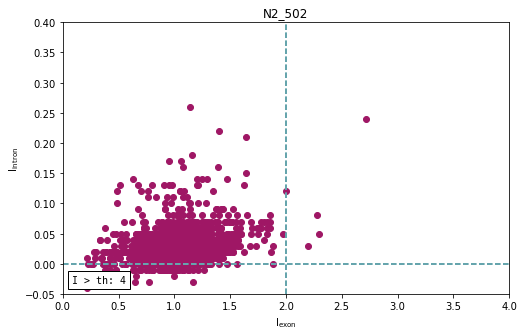

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_503.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_503.csv


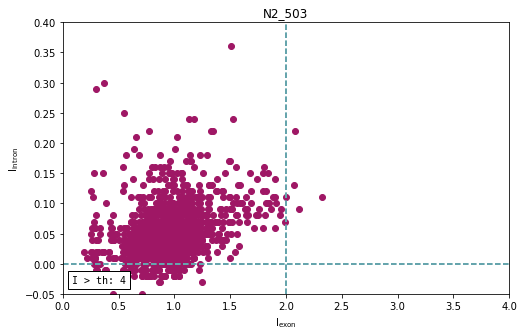

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_504.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_504.csv


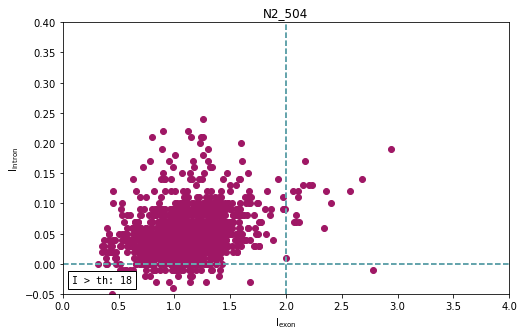

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_505.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_505.csv


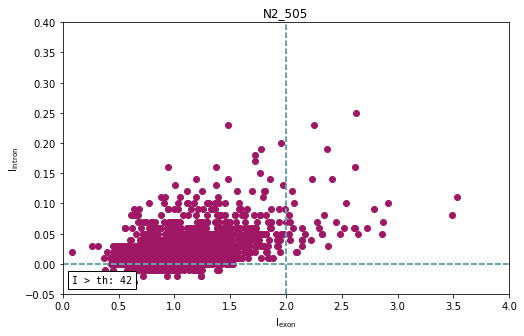

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_506.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_506.csv


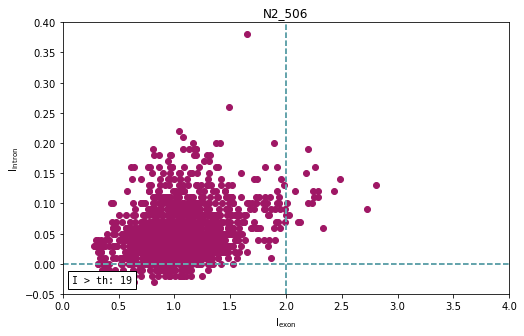

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_507.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_507.csv


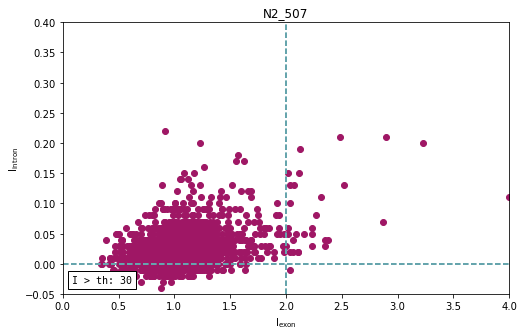

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_508.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_508.csv


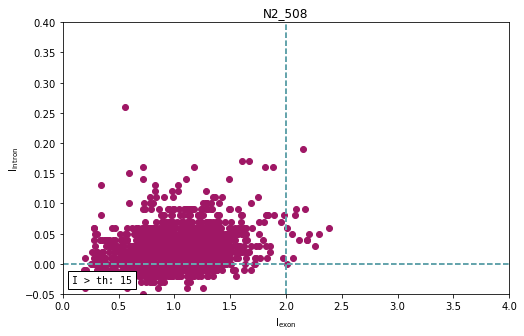

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_509.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_509.csv


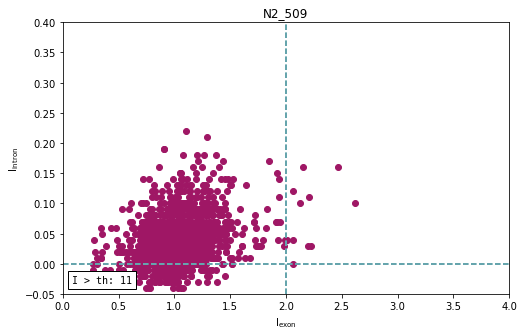

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_510.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_510.csv


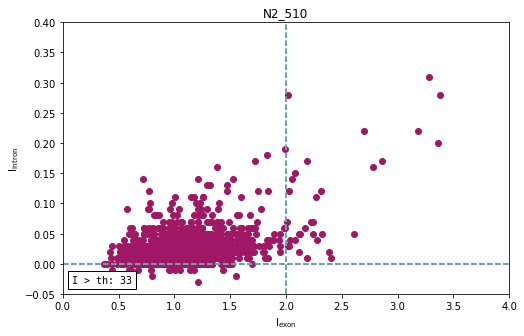

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_511.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_511.csv


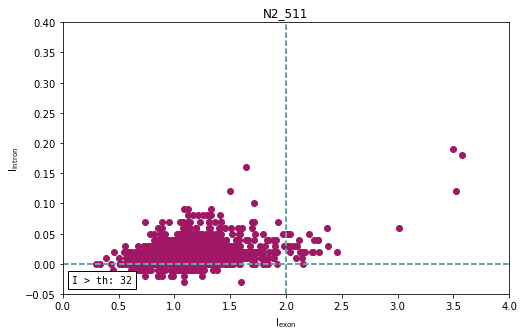

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_512.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_512.csv


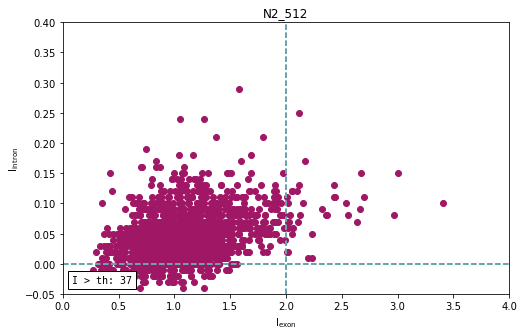

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_513.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_513.csv


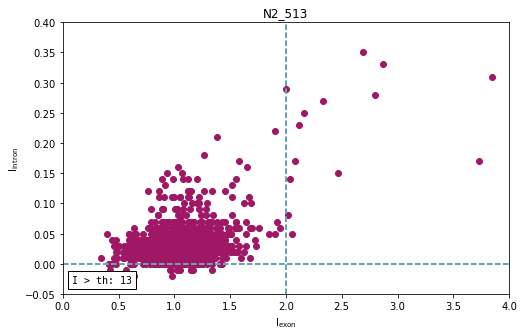

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_514.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_514.csv


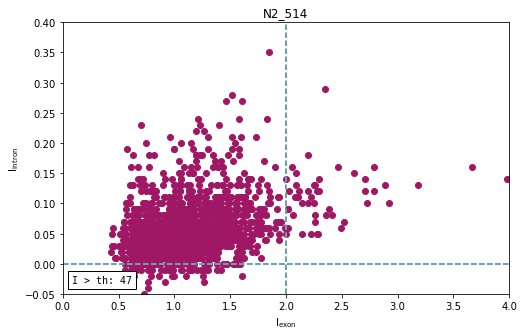

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_515.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_515.csv


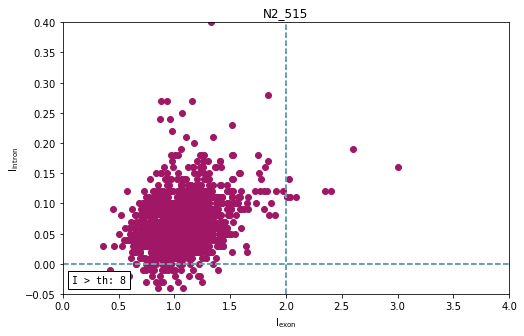

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_516.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_516.csv


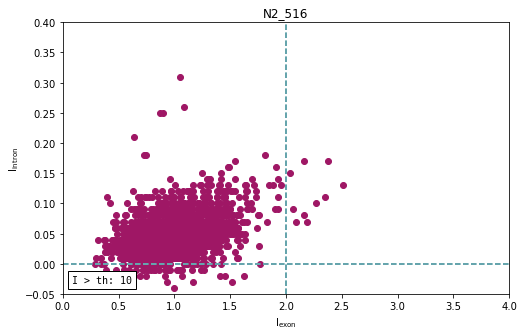

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_518.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_518.csv


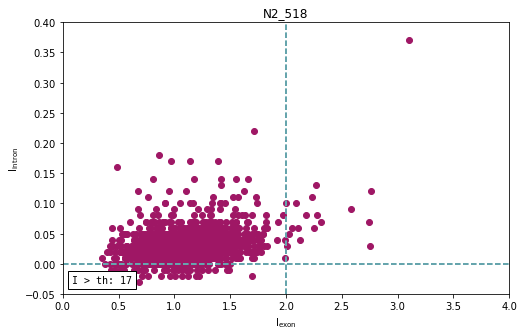

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_519.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_519.csv


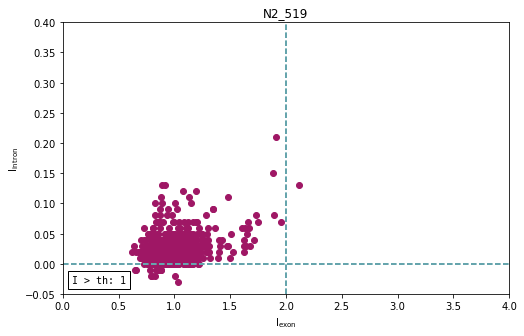

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_520.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_520.csv


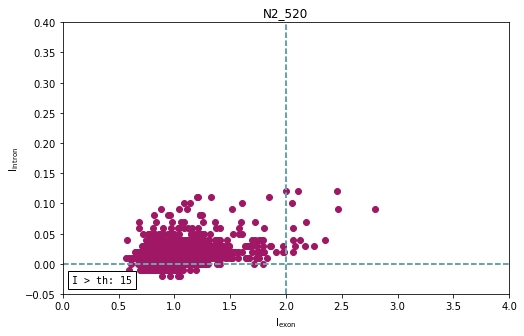

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_521.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_521.csv


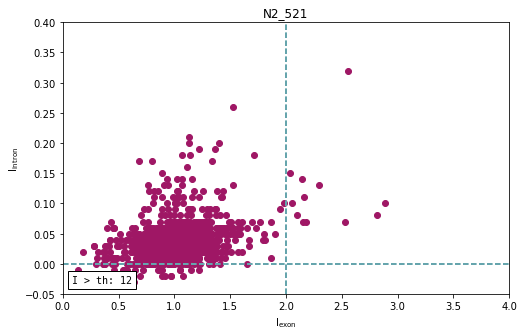

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_522.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_522.csv


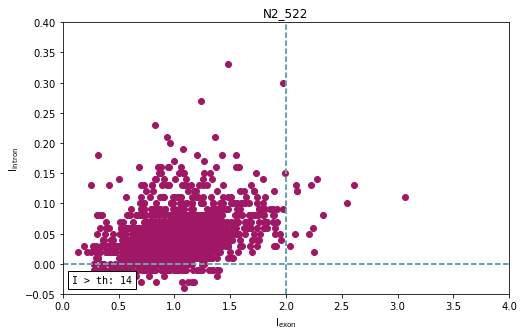

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_523.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_523.csv


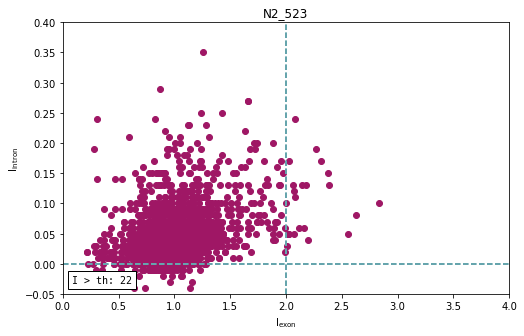

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_524.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_524.csv


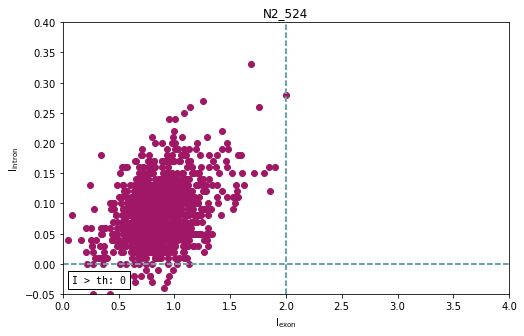

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_525.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_525.csv


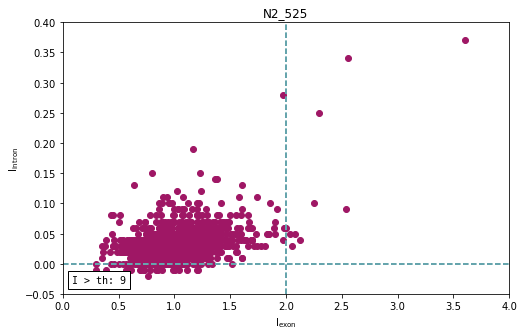

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_526.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_526.csv


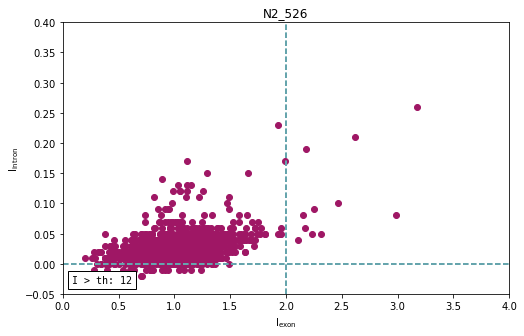

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_527.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_527.csv


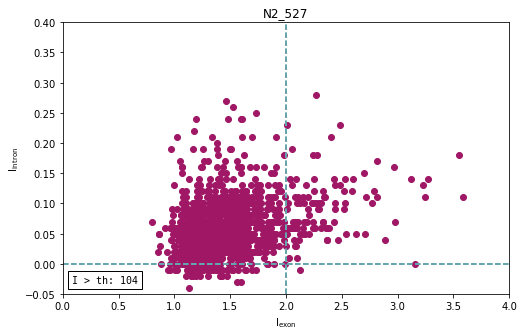

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_528.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_528.csv


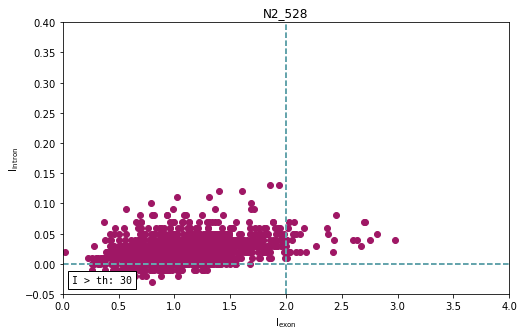

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_529.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_529.csv


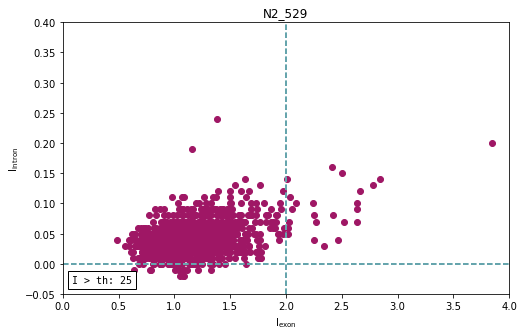

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_530.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_530.csv


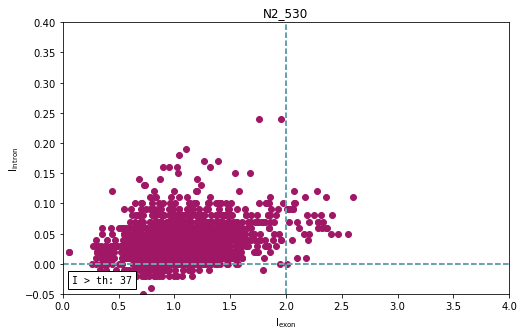

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_531.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_531.csv


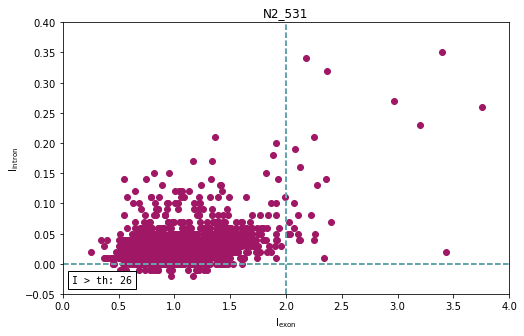

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_532.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_532.csv


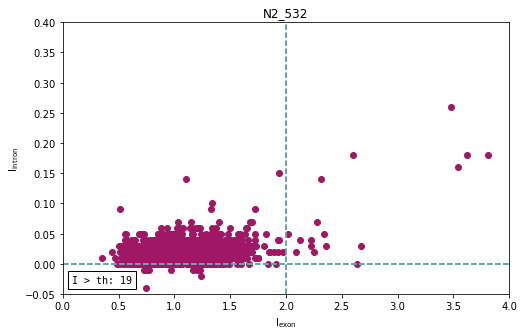

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_533.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_533.csv


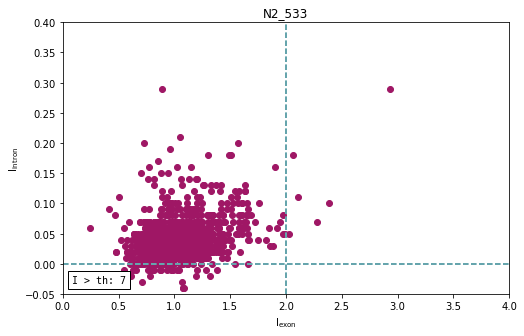

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_535.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_535.csv


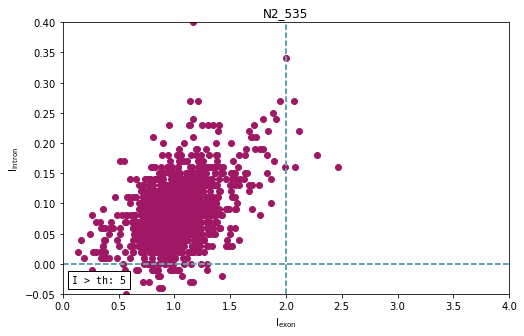

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_536.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_536.csv


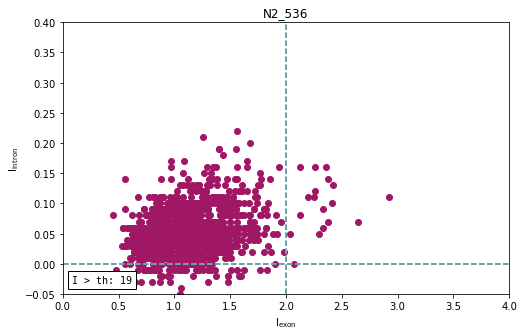

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_537.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_537.csv


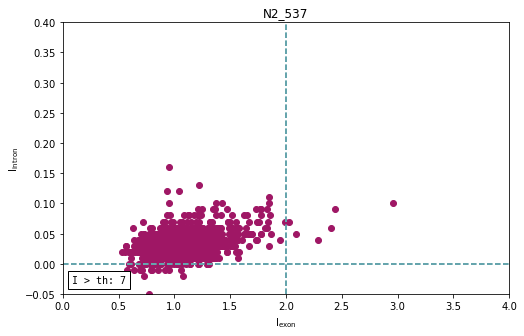

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_538.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_538.csv


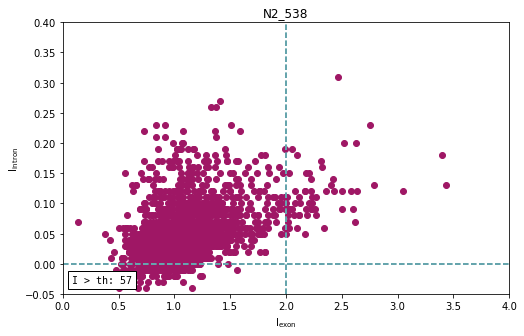

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_539.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_539.csv


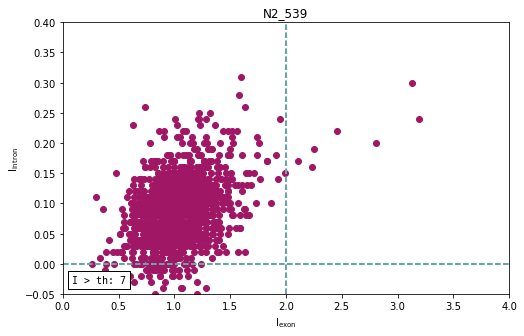

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_540.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_540.csv


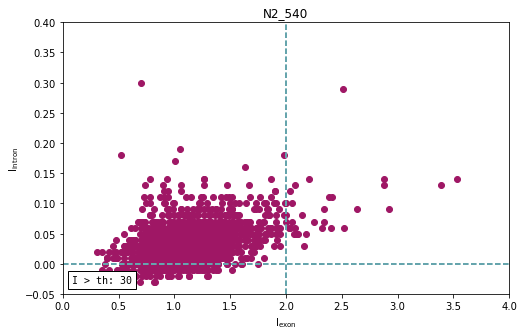

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_541.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_541.csv


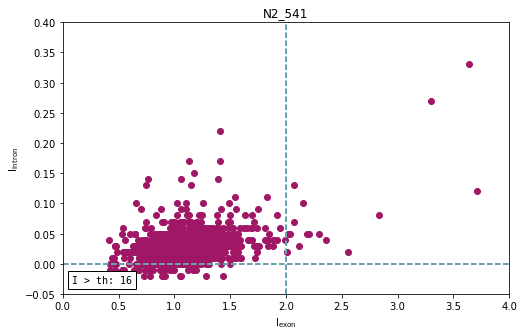

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_542.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_542.csv


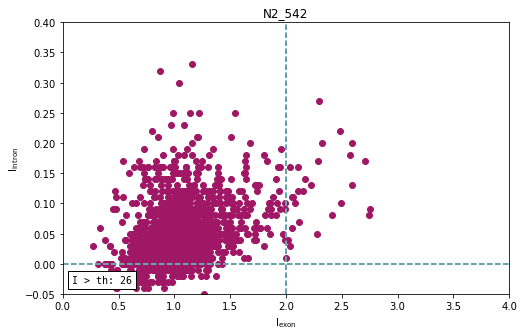

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_543.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_543.csv


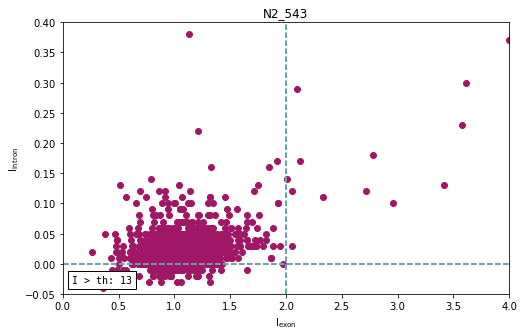

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_544.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_544.csv


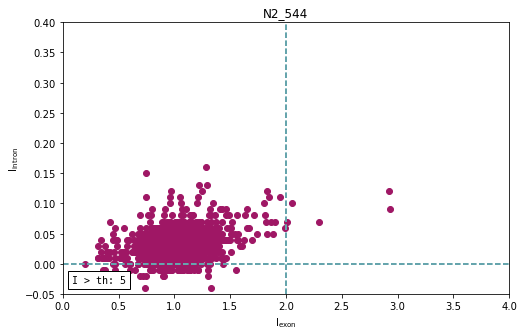

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_545.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_545.csv


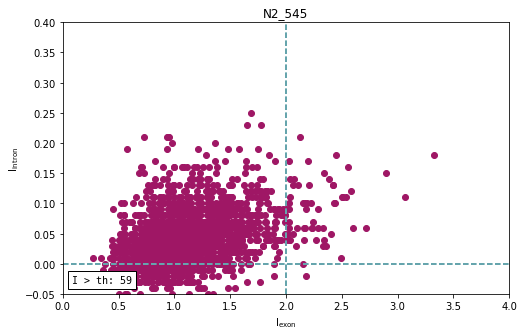

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_546.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_546.csv


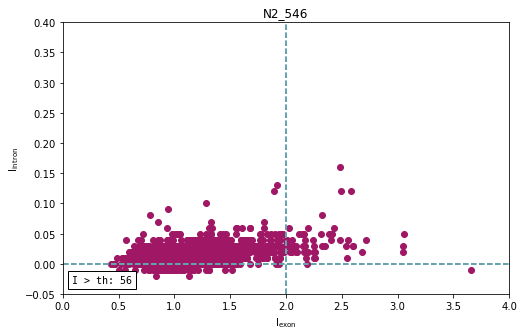

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_547.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_547.csv


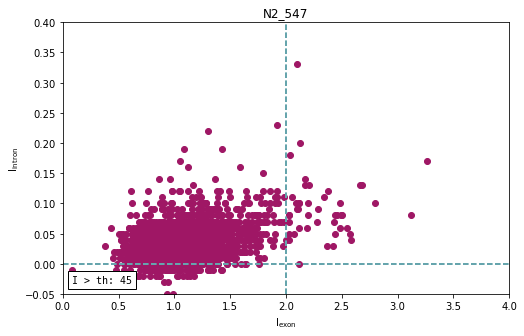

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_548.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_548.csv


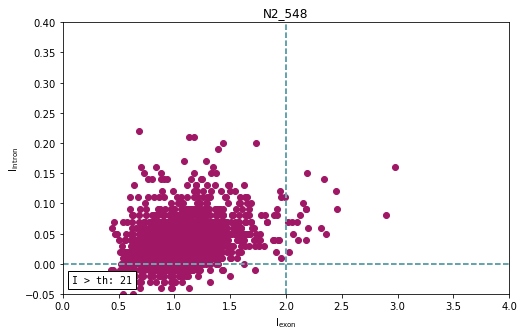

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_549.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_549.csv


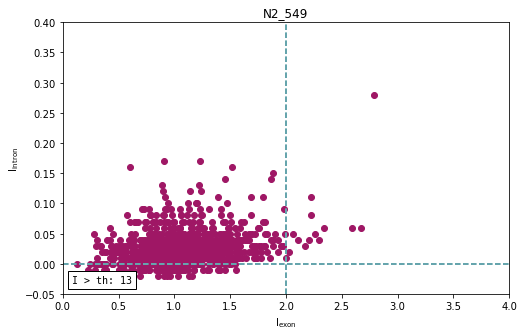

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_550.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_550.csv


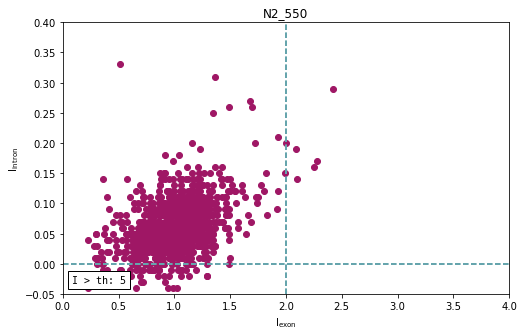

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_551.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_551.csv


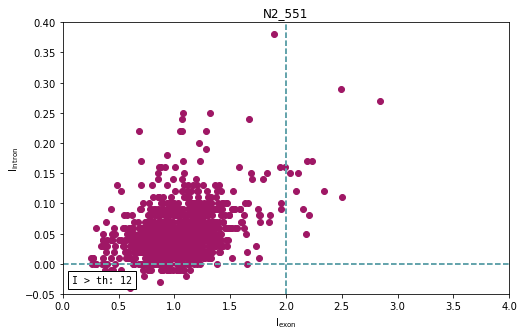

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_552.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_552.csv


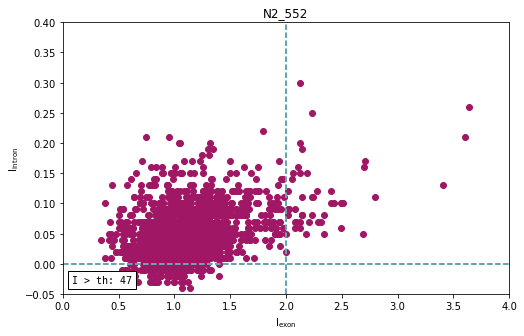

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_553.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_553.csv


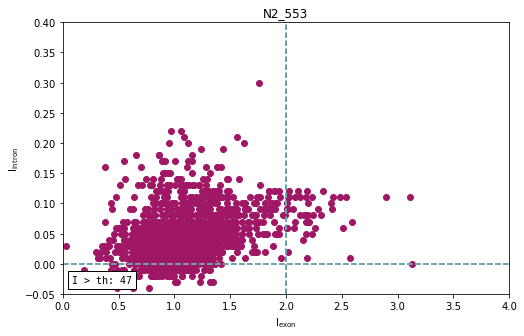

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_554.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_554.csv


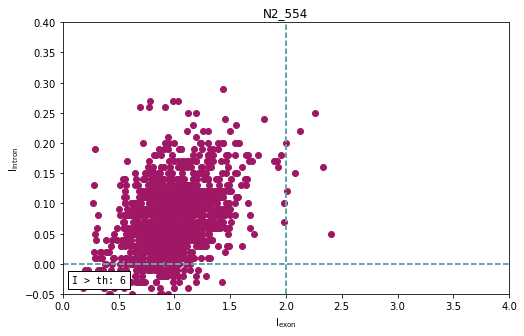

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_555.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_555.csv


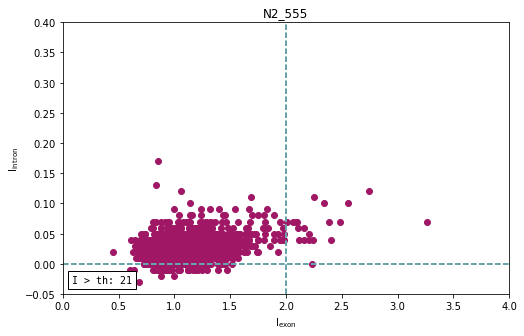

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_556.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_556.csv


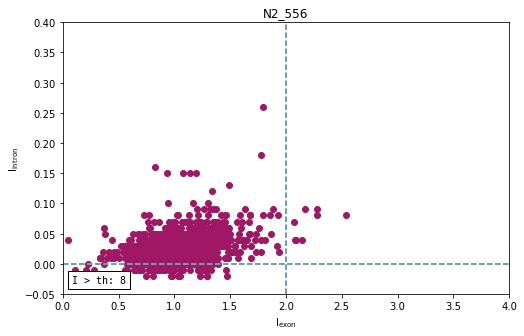

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_557.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_557.csv


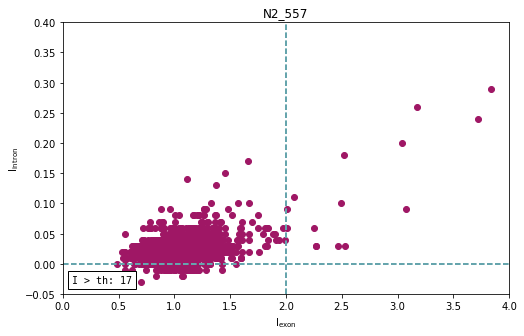

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_558.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_558.csv


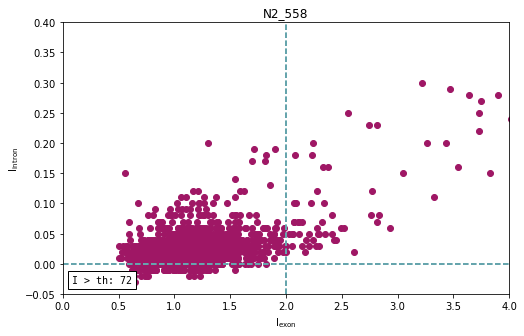

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_559.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_559.csv


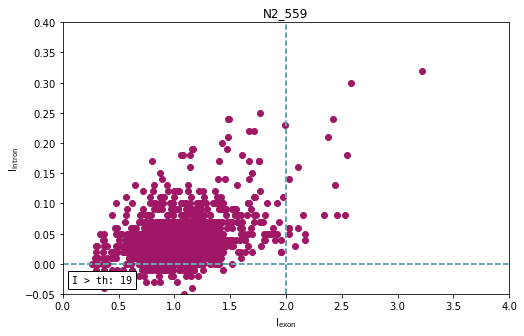

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_560.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_560.csv


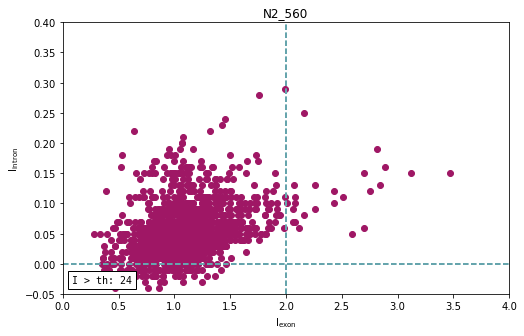

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_561.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_561.csv


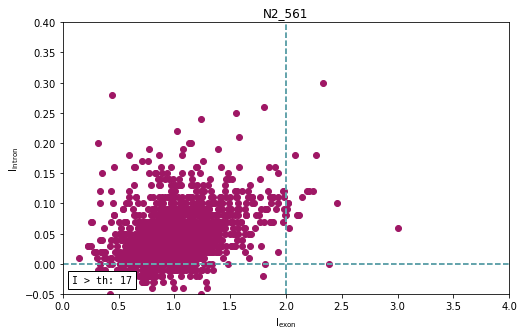

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_562.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_562.csv


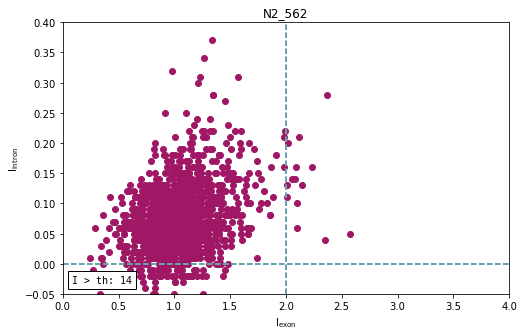

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_564.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_564.csv


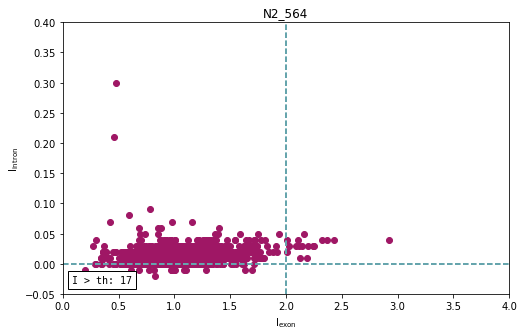

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_565.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_565.csv


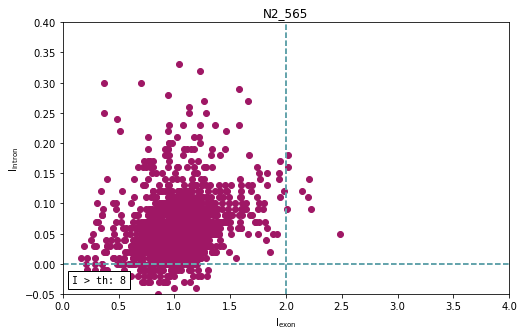

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_566.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_566.csv


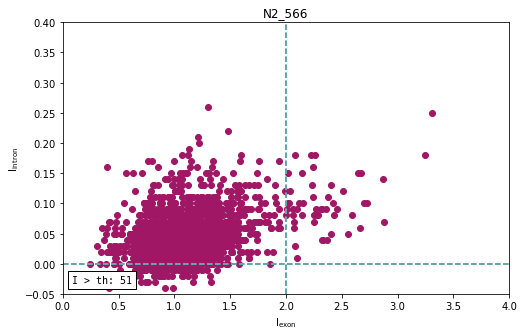

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_567.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_567.csv


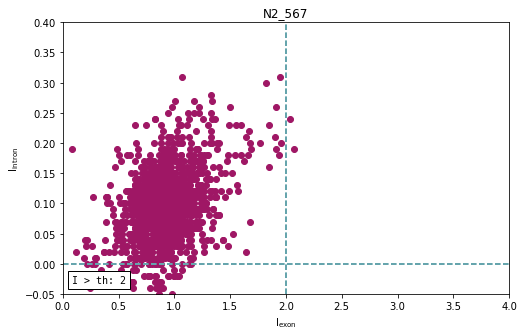

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_568.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_568.csv


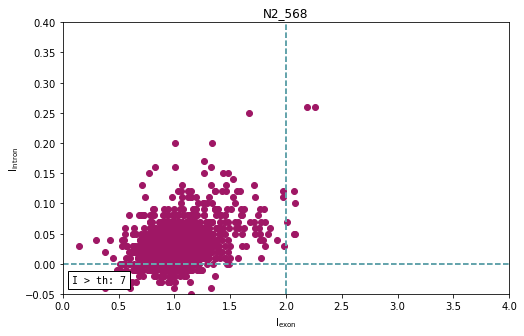

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_569.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_569.csv


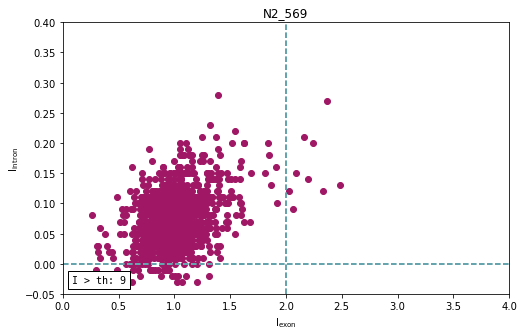

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_570.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_570.csv


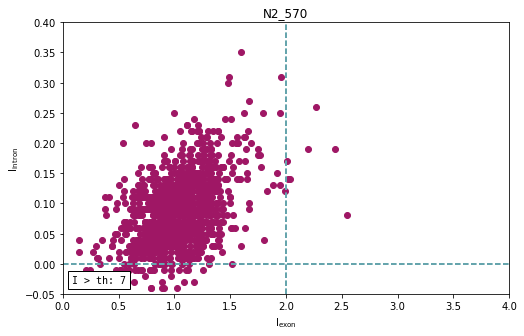

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_571.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_571.csv


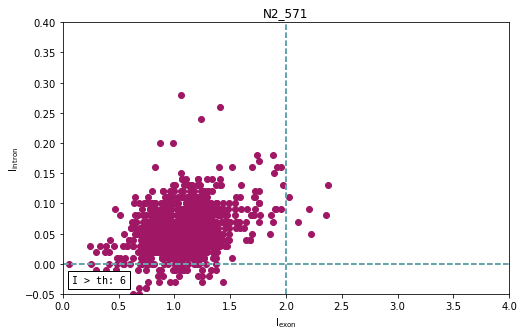

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_572.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_572.csv


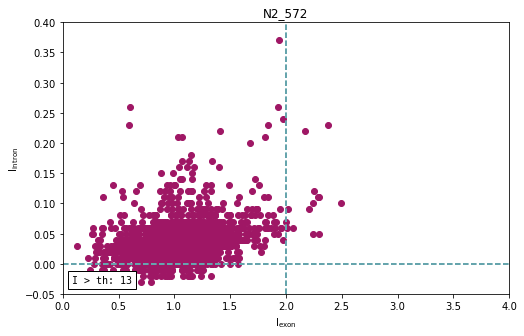

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_573.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_573.csv


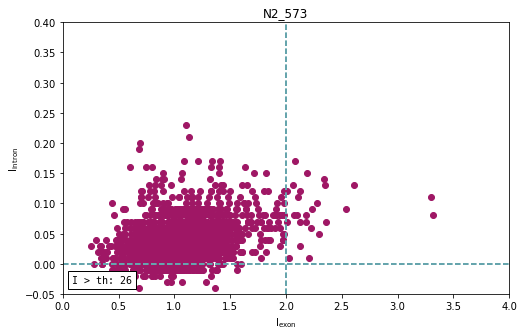

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_574.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_574.csv


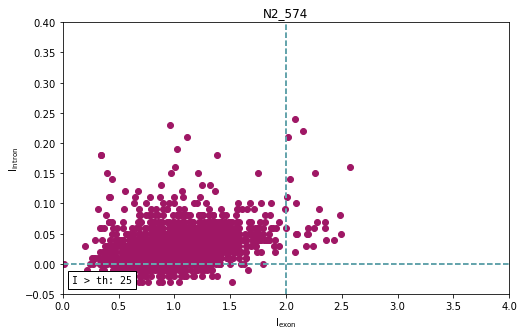

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_575.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_575.csv


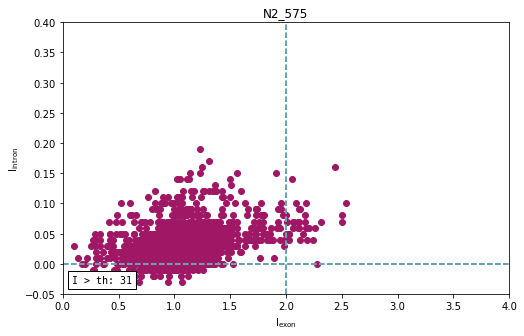

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_576.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_576.csv


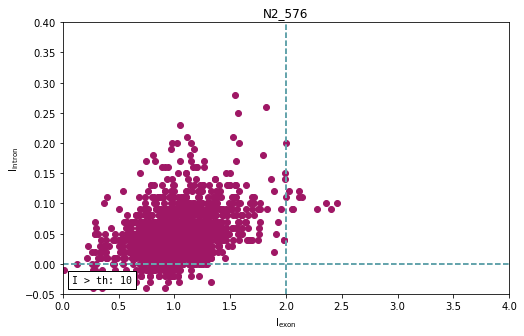

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_578.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_578.csv


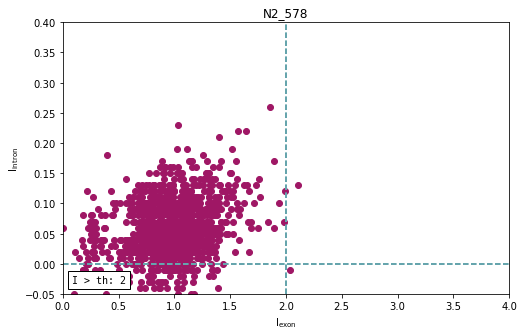

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_579.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_579.csv


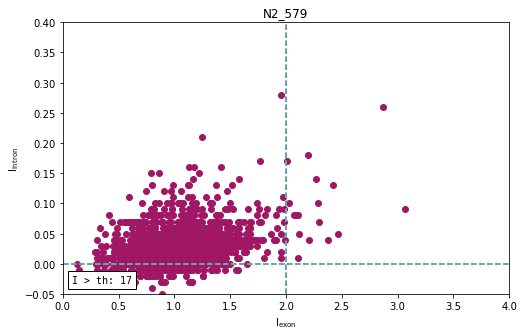

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_580.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_580.csv


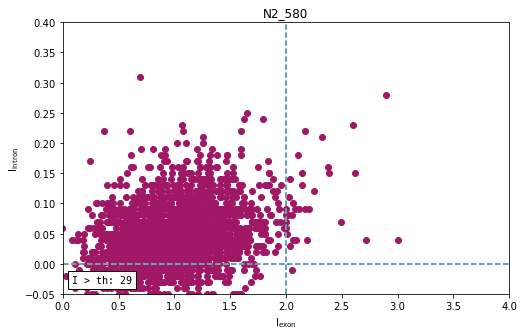

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_581.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_581.csv


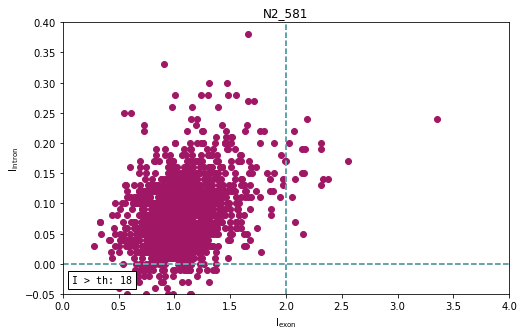

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_582.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_582.csv


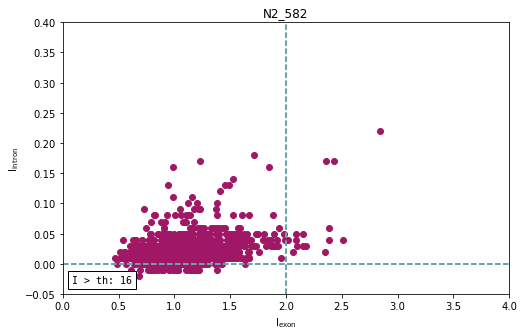

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_583.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_583.csv


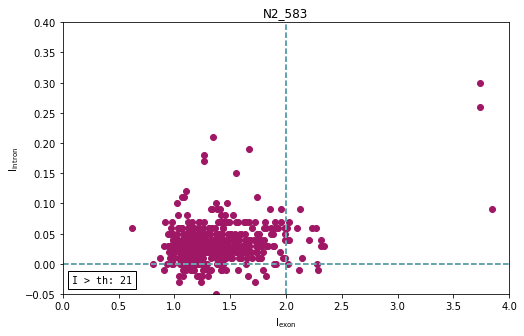

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_584.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_584.csv


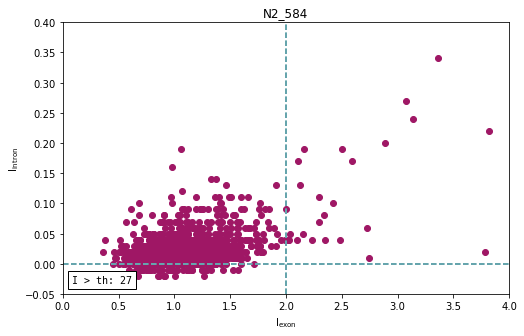

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_585.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_585.csv


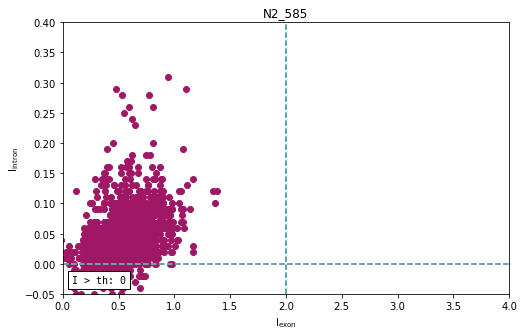

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_586.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_586.csv


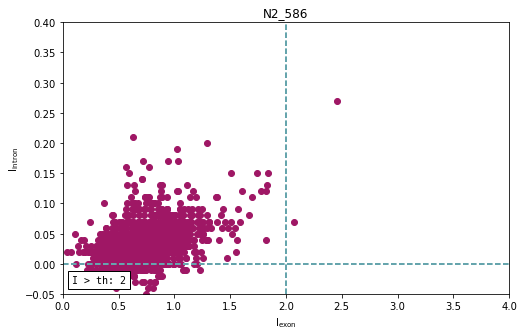

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_588.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_588.csv


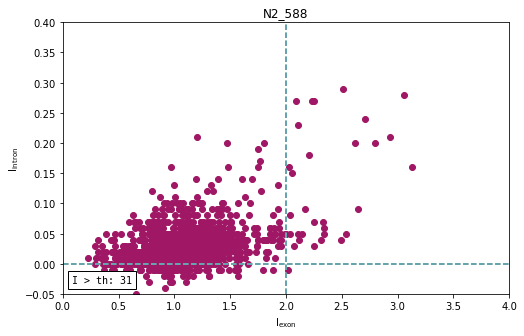

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_589.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_589.csv


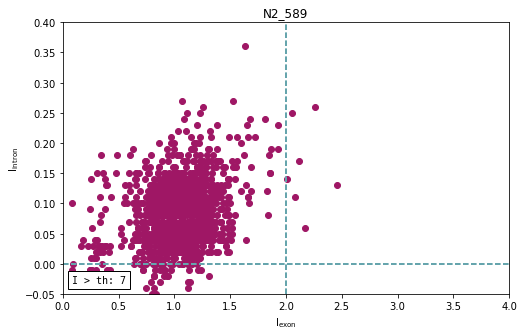

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_590.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_590.csv


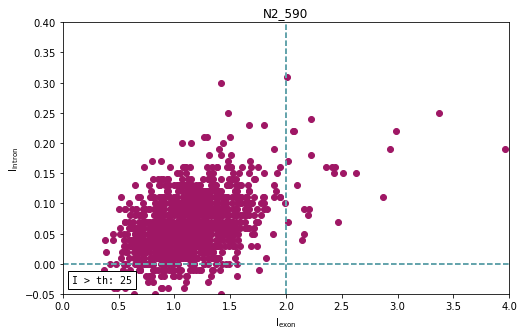

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_591.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_591.csv


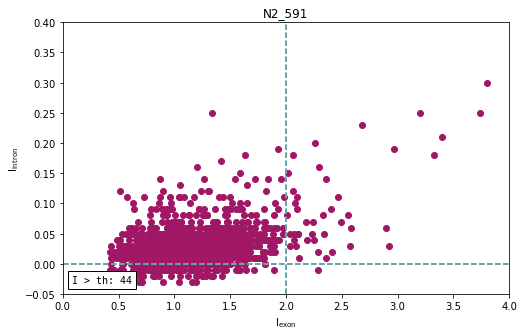

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_592.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_592.csv


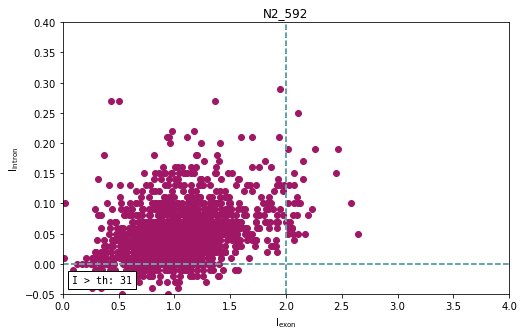

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_593.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_593.csv


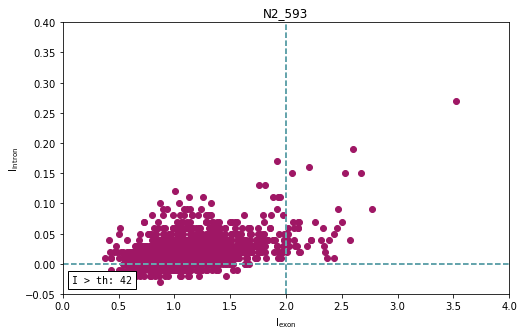

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_594.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_594.csv


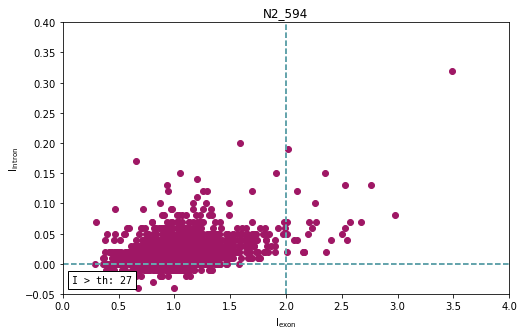

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_595.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_595.csv


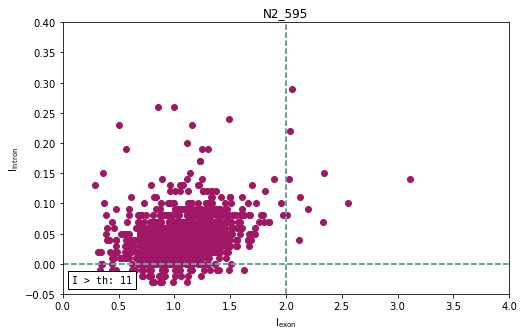

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_596.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_596.csv


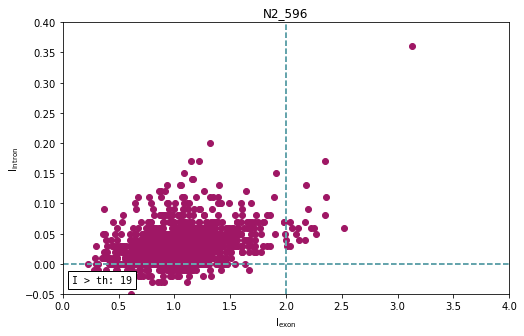

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_597.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_597.csv


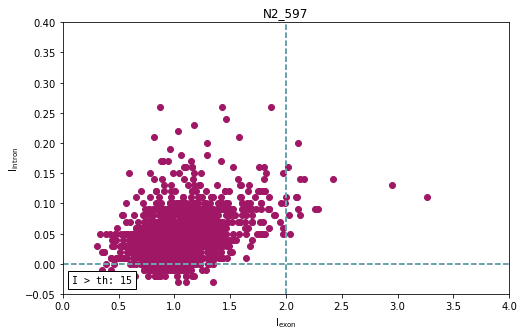

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_598.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_598.csv


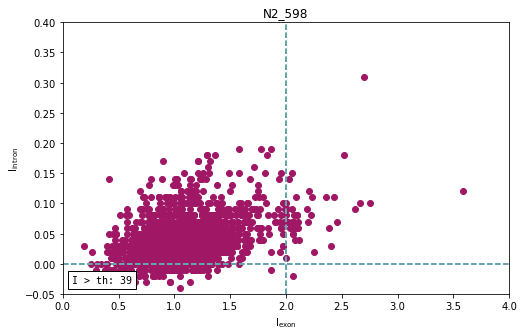

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_599.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_599.csv


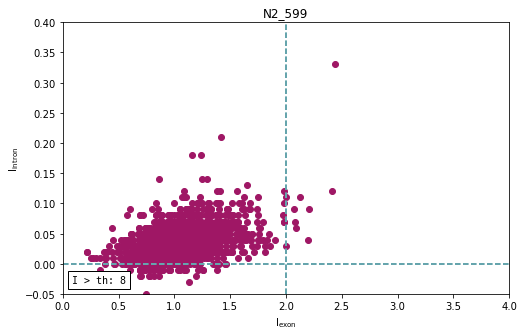

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_600.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_600.csv


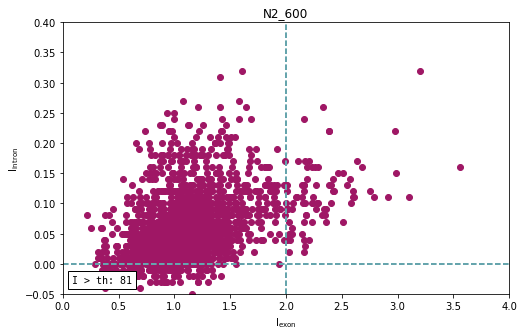

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_603.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_603.csv


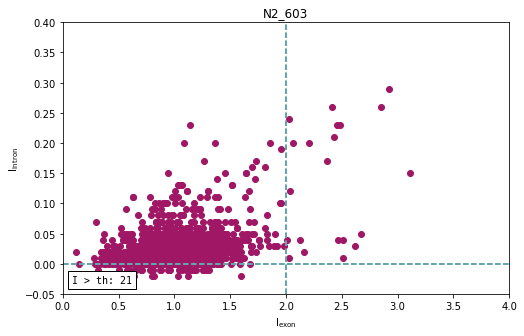

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_605.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_605.csv


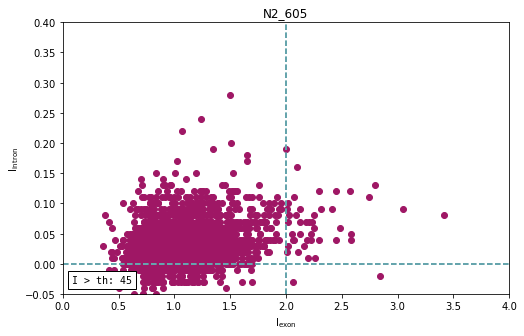

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_606.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_606.csv


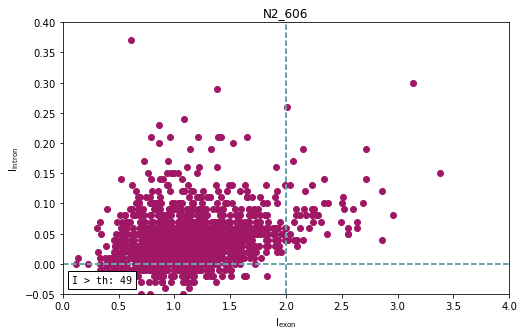

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_607.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_607.csv


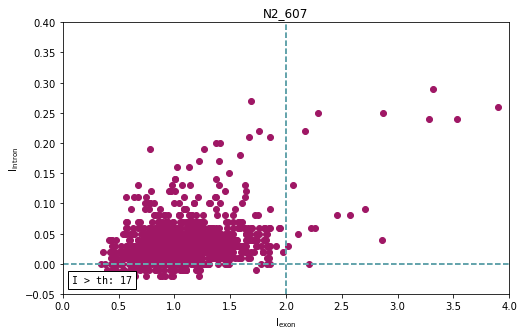

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_608.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_608.csv


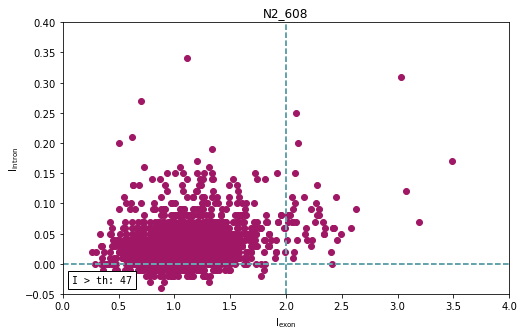

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_609.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_609.csv


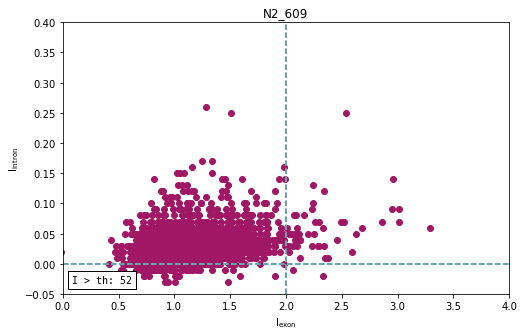

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_614.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_614.csv


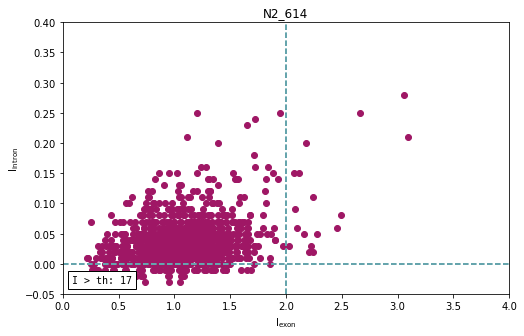

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_615.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_615.csv


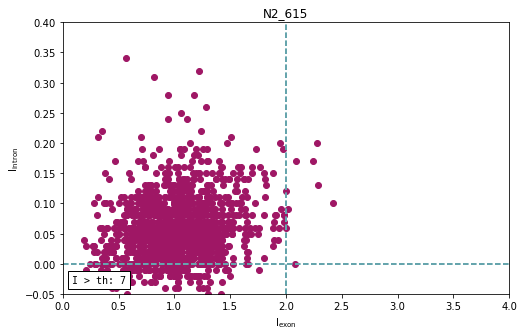

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_616.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_616.csv


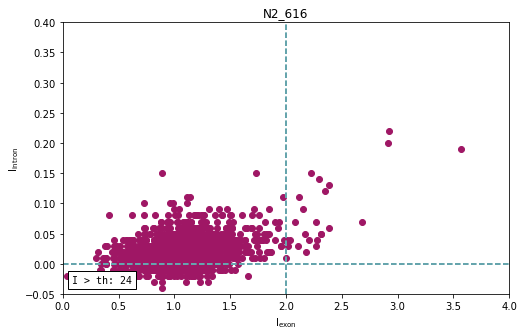

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_617.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_617.csv


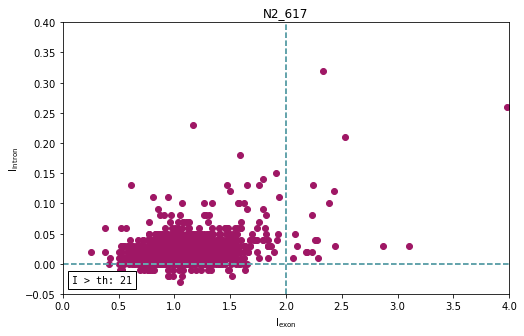

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_618.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_618.csv


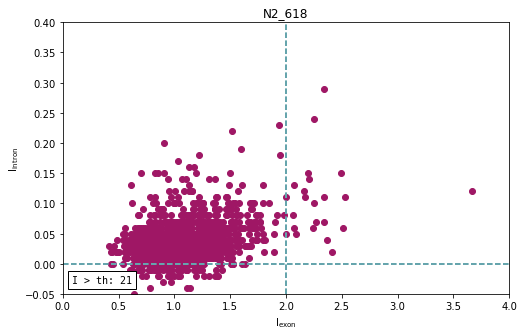

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_619.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_619.csv


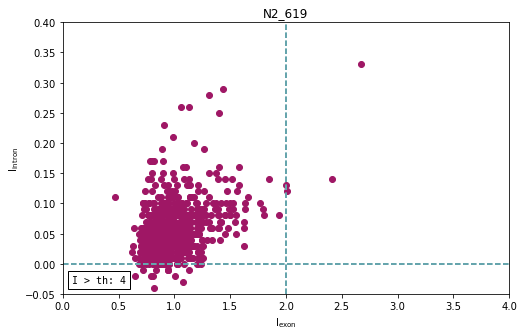

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_620.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_620.csv


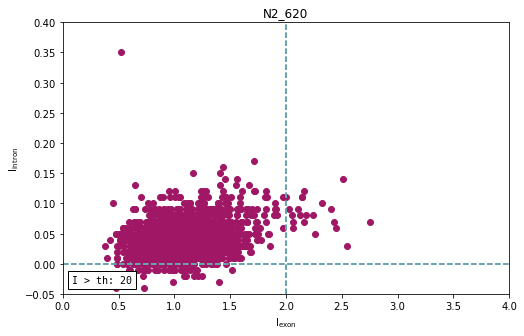

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_621.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_621.csv


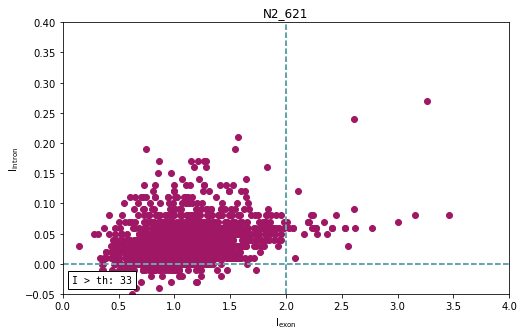

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_623.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_623.csv


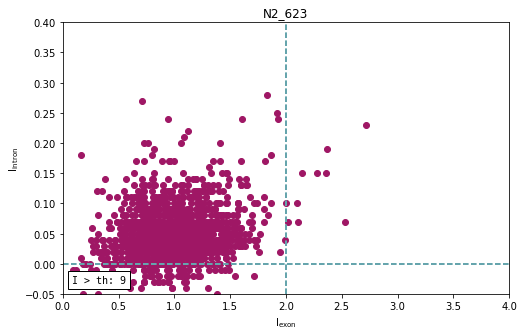

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_625.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_625.csv


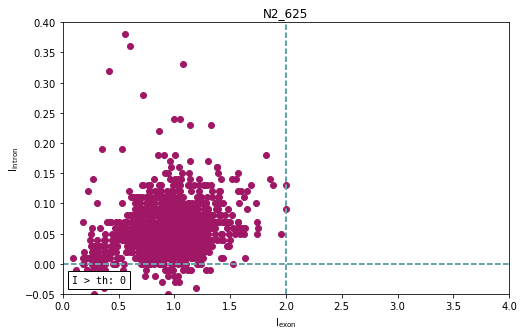

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_626.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_626.csv


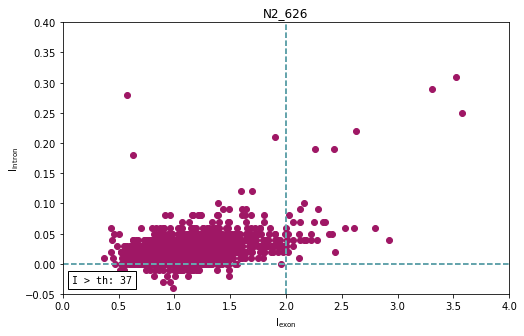

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_627.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_627.csv


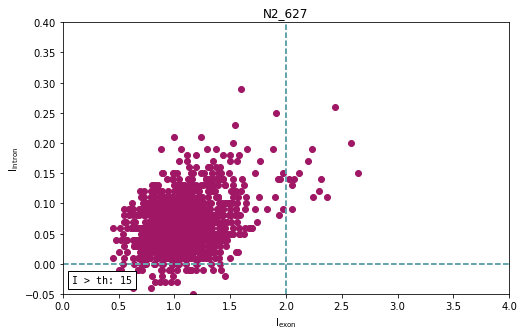

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_628.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_628.csv


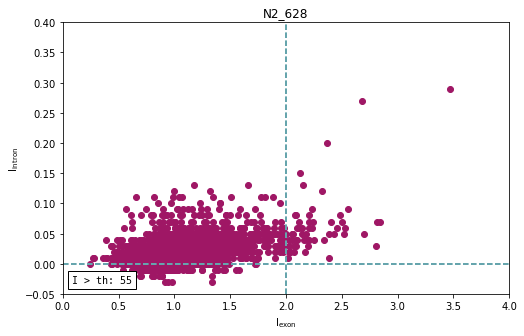

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_629.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_629.csv


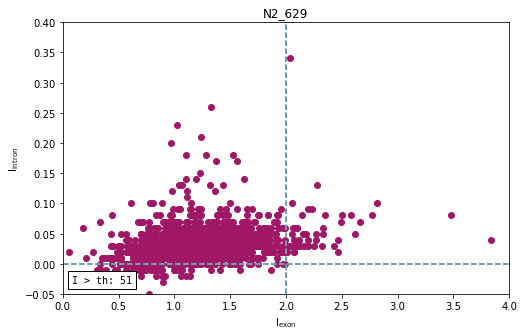

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_630.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_630.csv


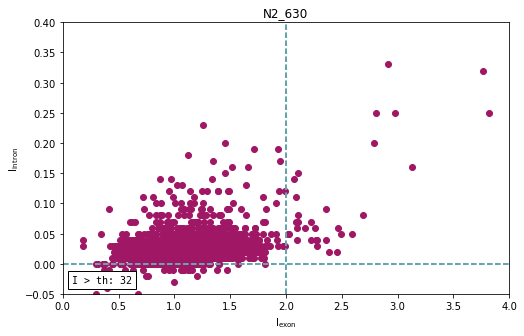

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_631.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_631.csv


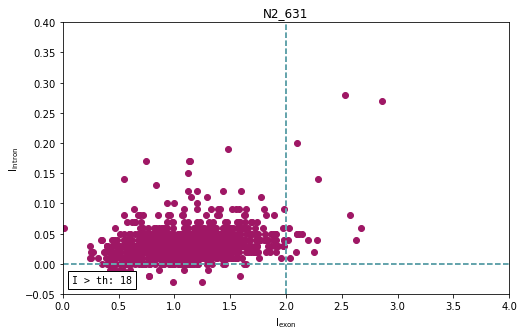

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_632.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_632.csv


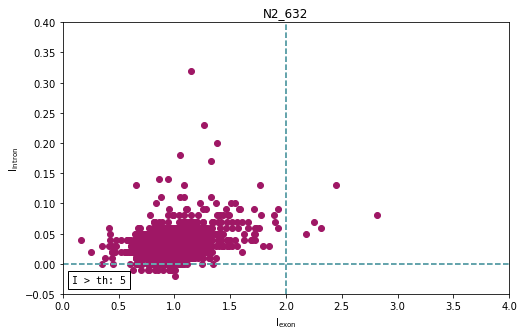

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_633.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_633.csv


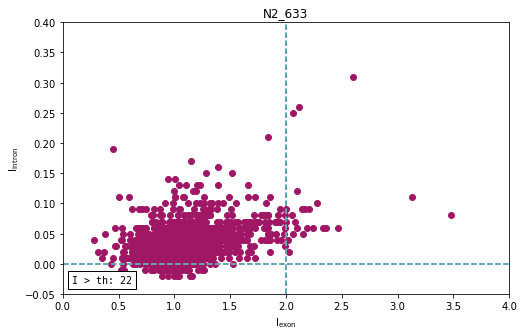

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_634.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_634.csv


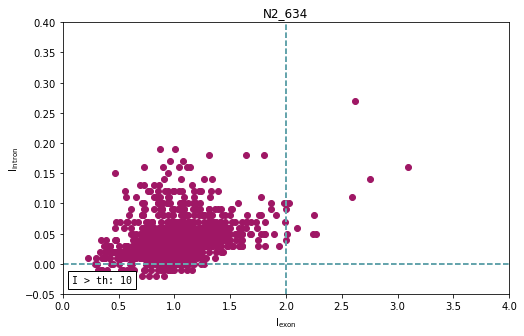

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_635.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_635.csv


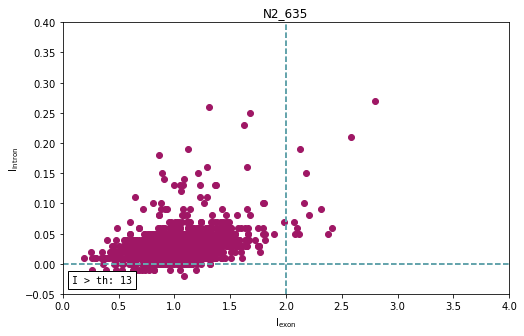

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_636.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_636.csv


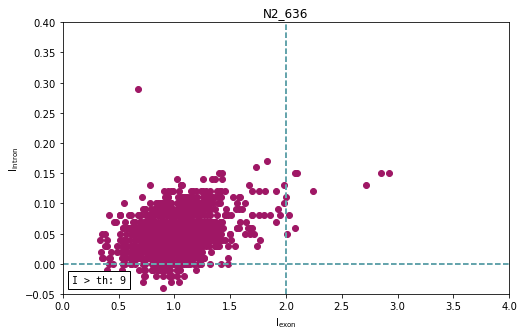

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_637.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_637.csv


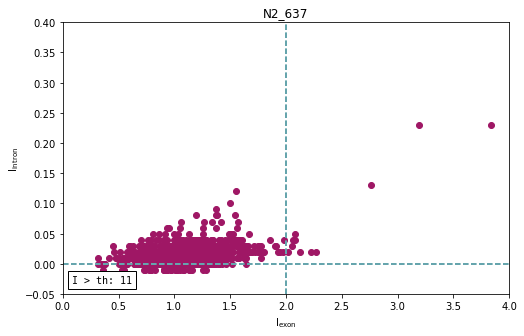

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_638.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_638.csv


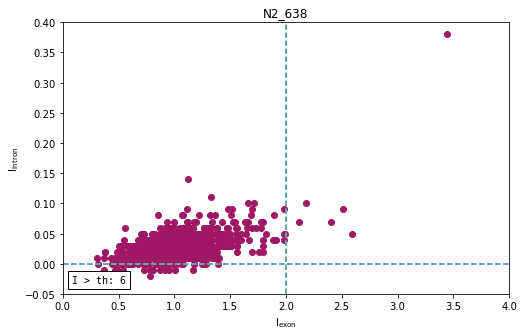

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_639.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_639.csv


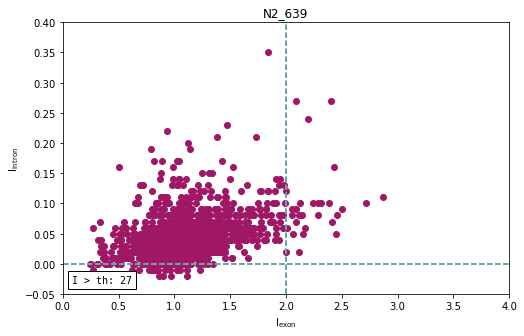

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_640.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_640.csv


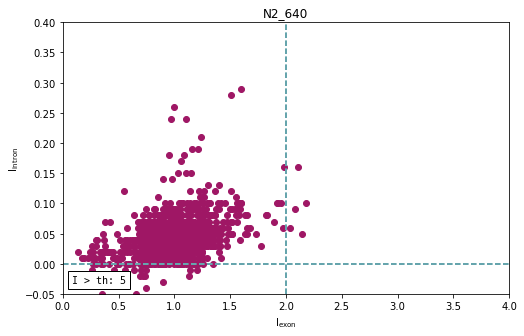

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_641.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_641.csv


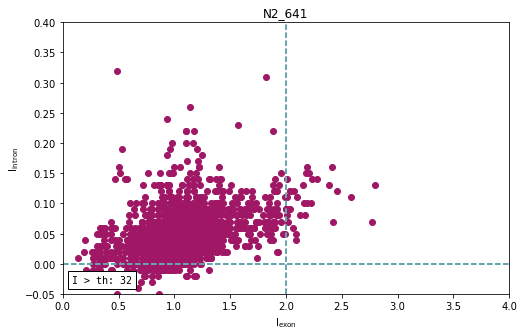

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_642.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_642.csv


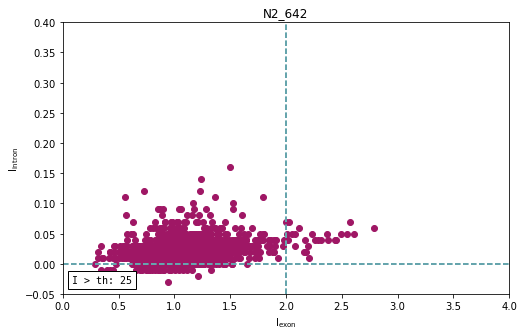

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_643.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_643.csv


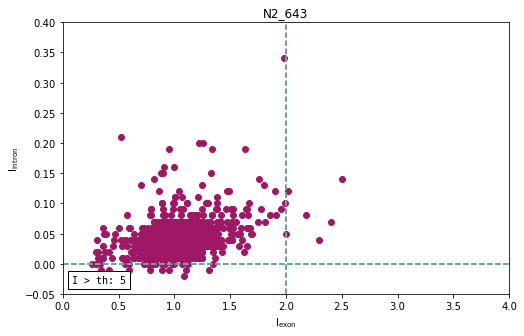

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_644.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_644.csv


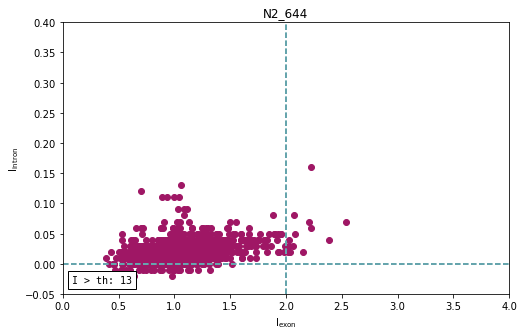

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_645.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_645.csv


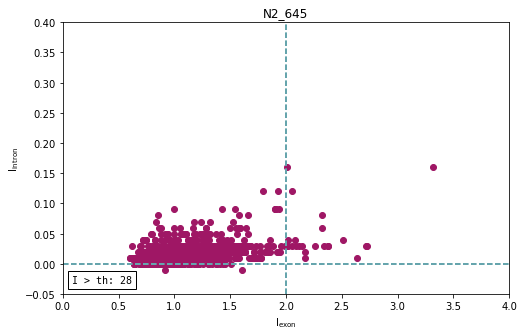

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_646.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_646.csv


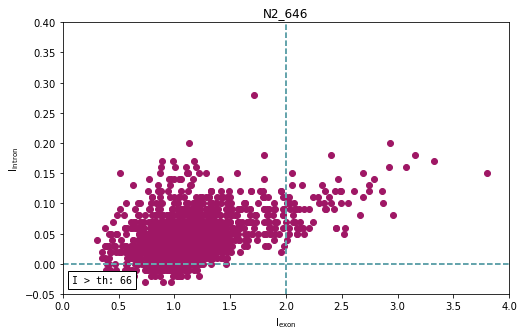

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_647.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_647.csv


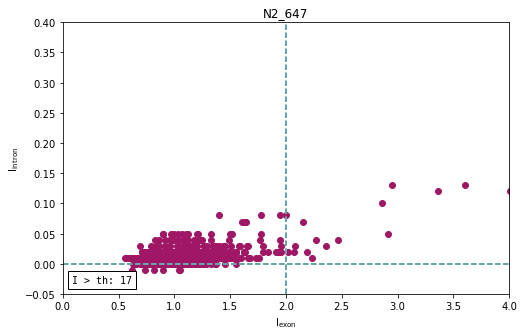

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_648.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_648.csv


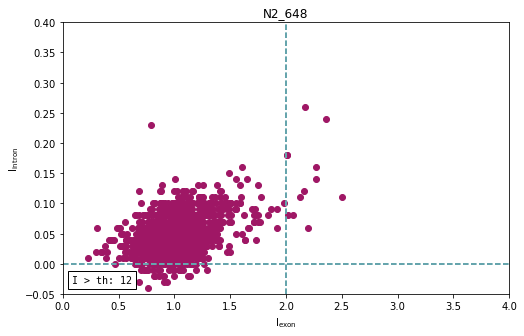

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_649.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_649.csv


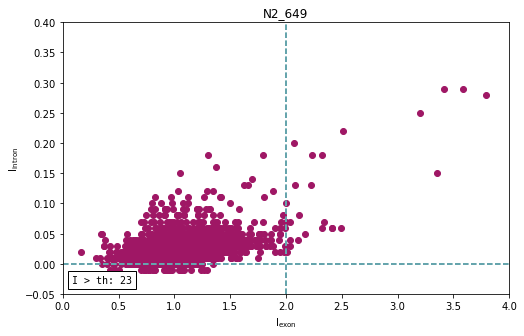

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_650.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_650.csv


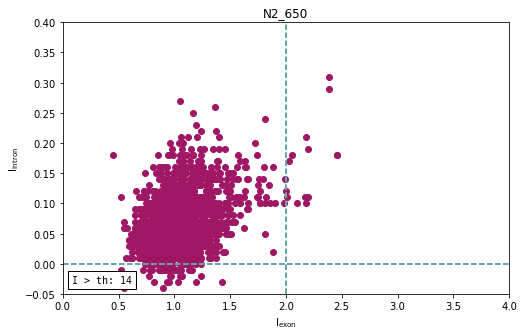

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_651.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_651.csv


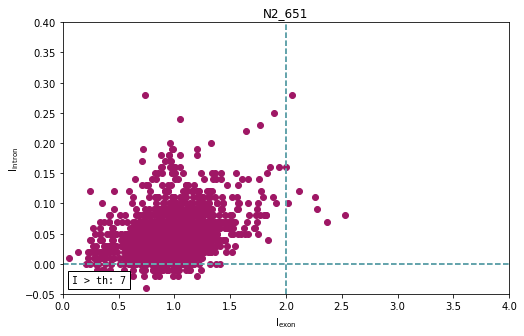

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_652.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_652.csv


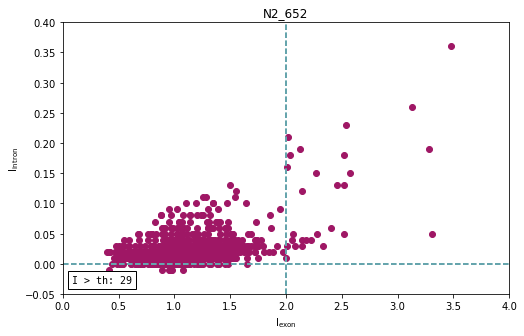

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_653.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_653.csv


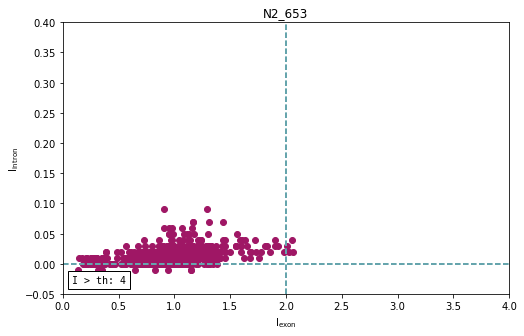

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_654.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_654.csv


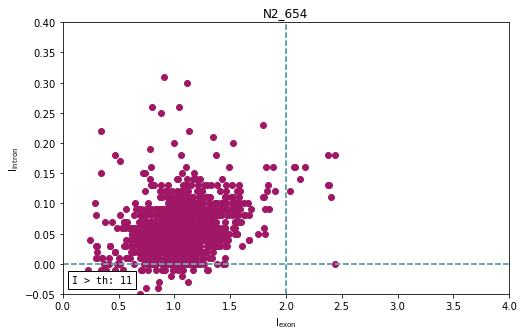

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_655.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_655.csv


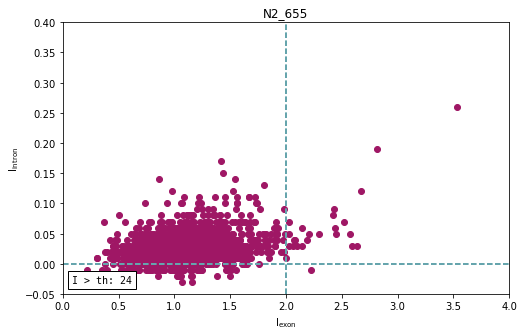

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_656.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_656.csv


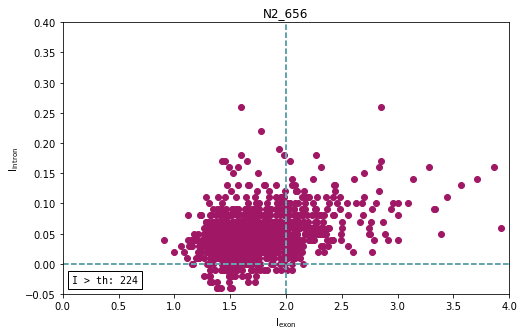

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_657.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_657.csv


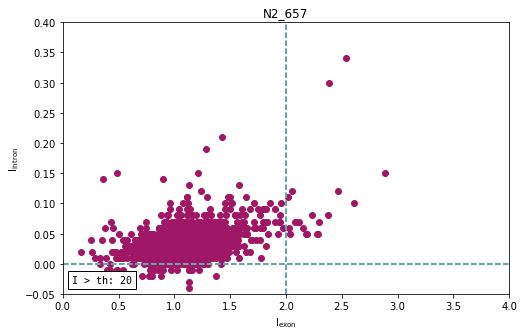

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_658.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_658.csv


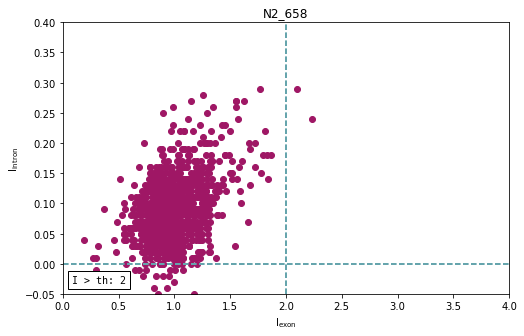

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_660.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_660.csv


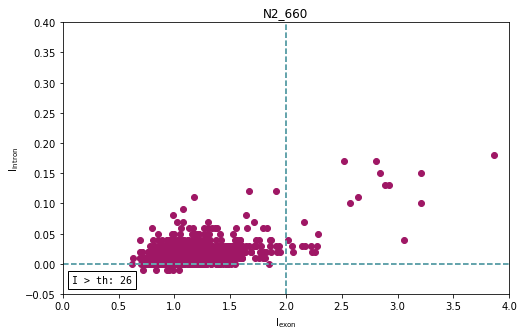

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_661.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_661.csv


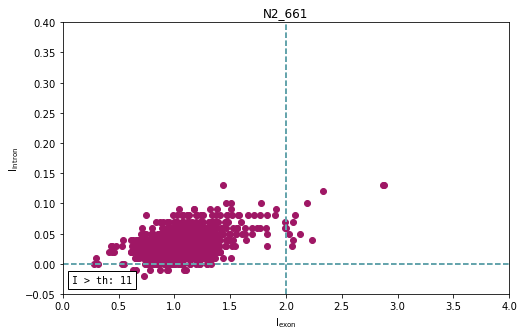

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_662.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_662.csv


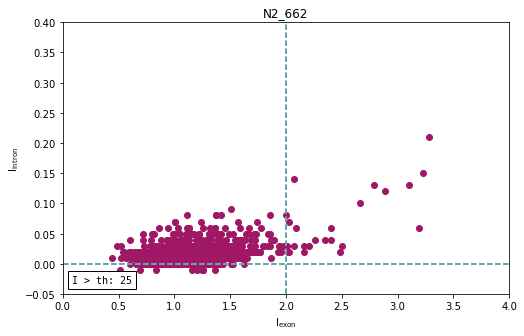

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_663.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_663.csv


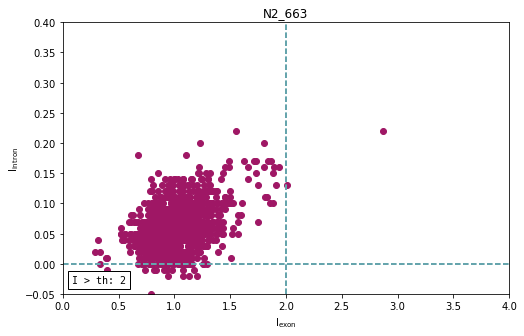

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_664.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_664.csv


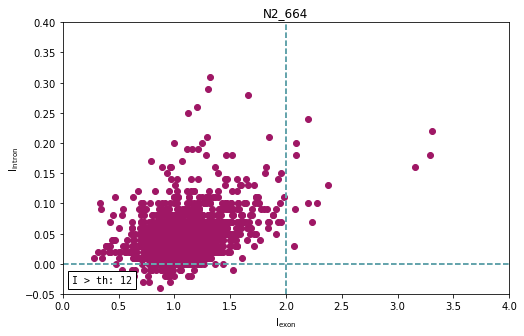

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_665.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_665.csv


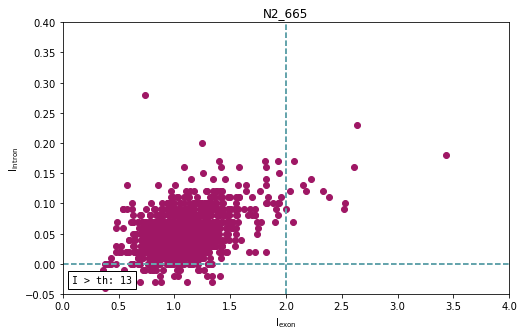

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_666.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_666.csv


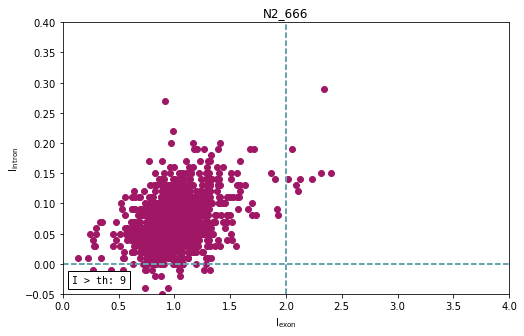

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_667.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_667.csv


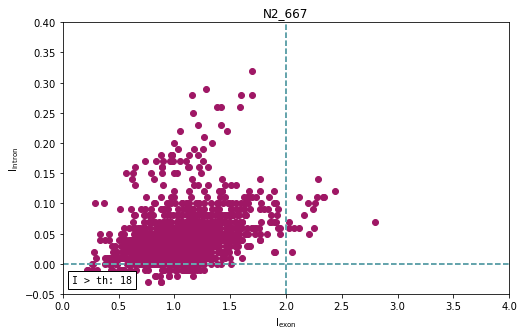

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_668.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_668.csv


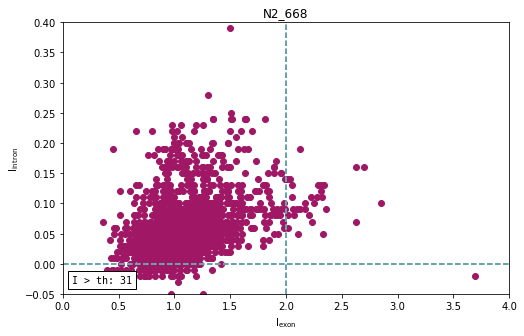

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_669.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_669.csv


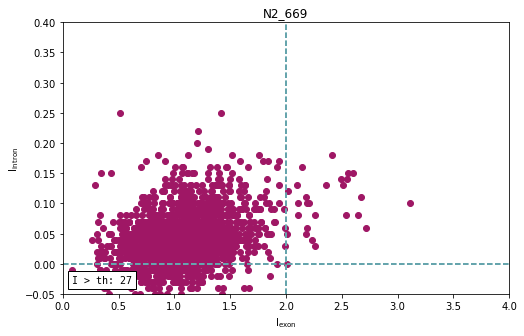

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_670.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_670.csv


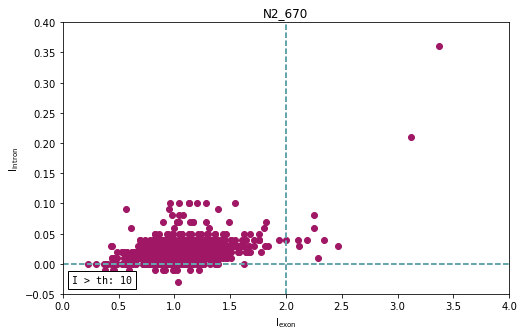

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_671.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_671.csv


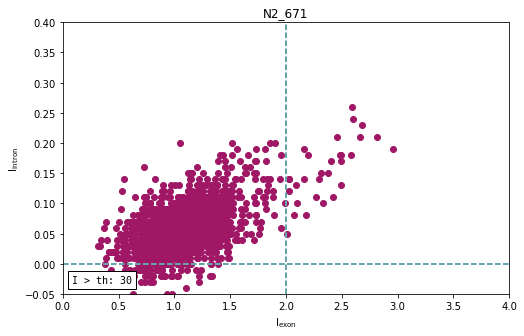

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_672.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_672.csv


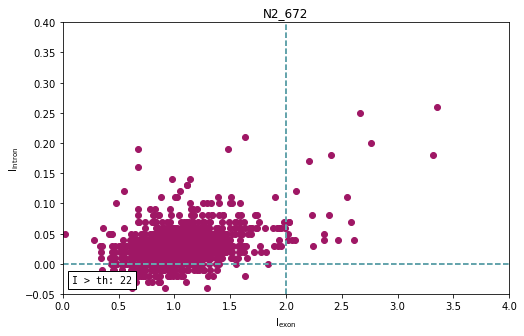

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_673.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_673.csv


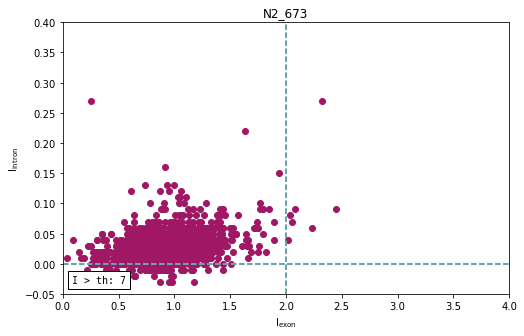

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_674.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_674.csv


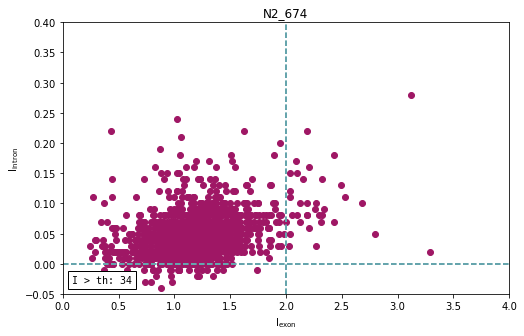

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_675.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_675.csv


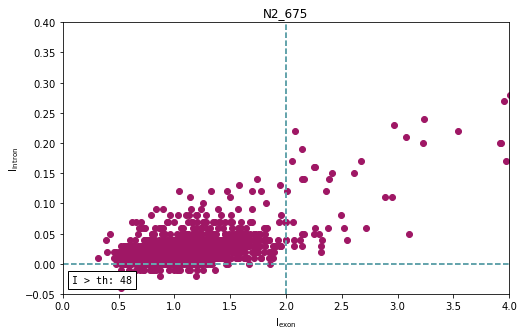

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_676.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_676.csv


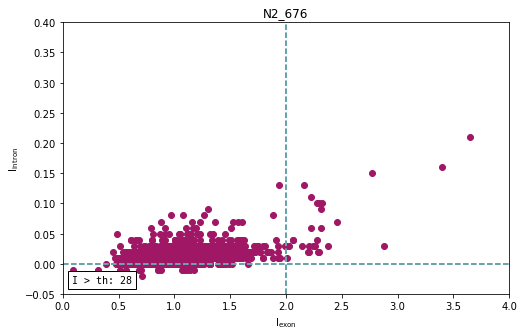

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_677.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_677.csv


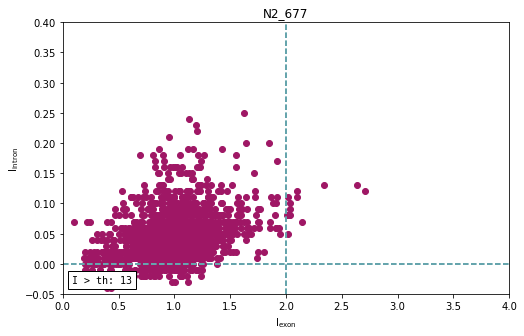

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_678.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_678.csv


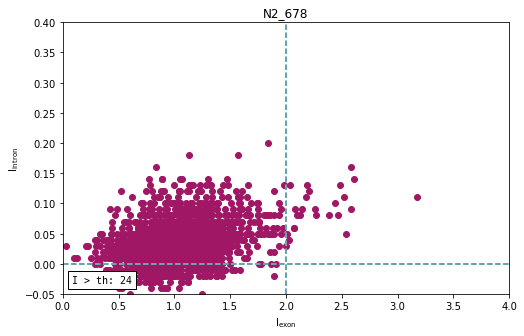

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_679.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_679.csv


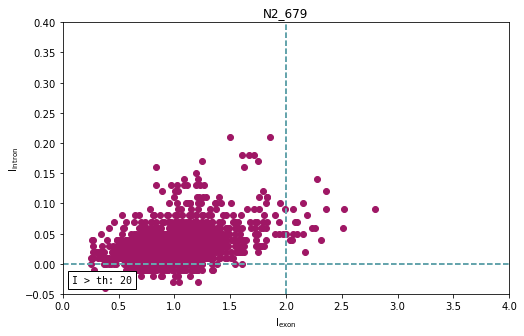

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_680.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_680.csv


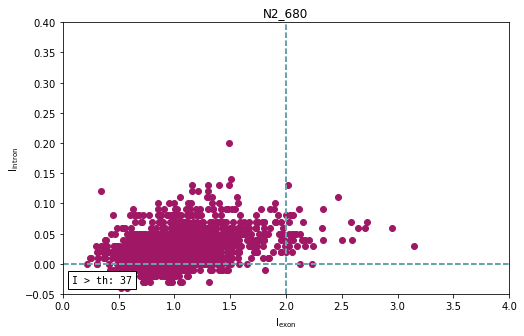

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_681.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_681.csv


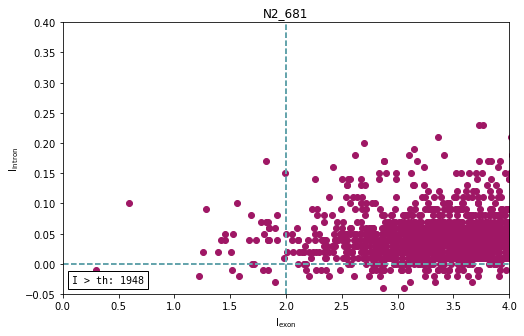

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_682.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_682.csv


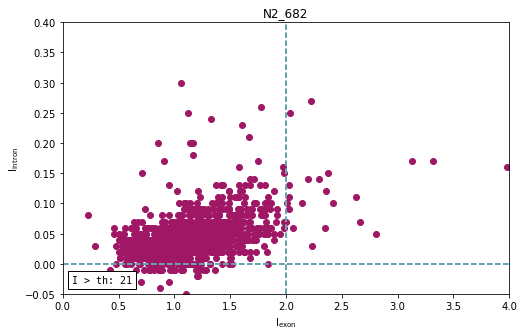

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_683.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_683.csv


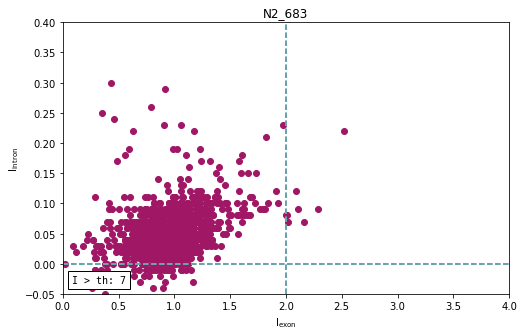

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_684.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_684.csv


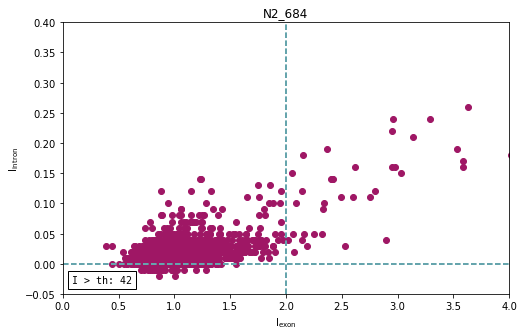

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_686.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_686.csv


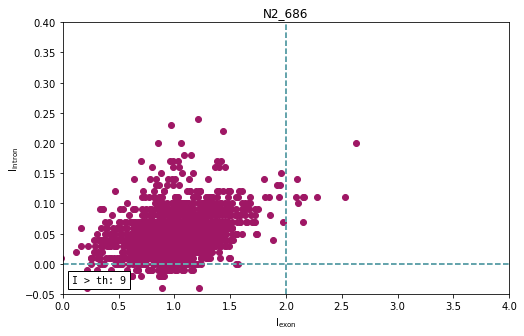

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_687.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_687.csv


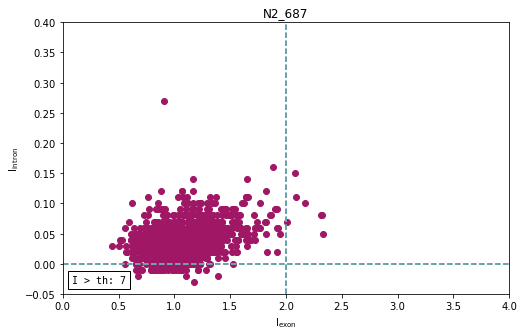

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_688.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_688.csv


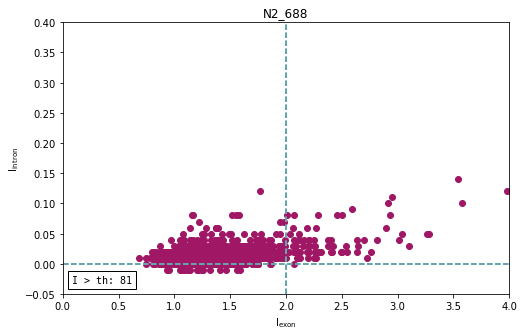

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_689.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_689.csv


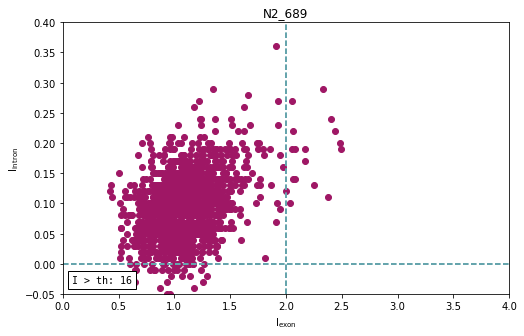

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_690.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_690.csv


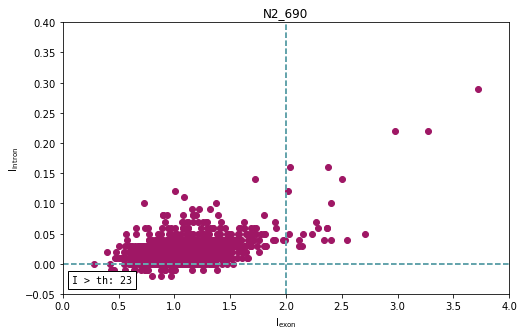

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_691.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_691.csv


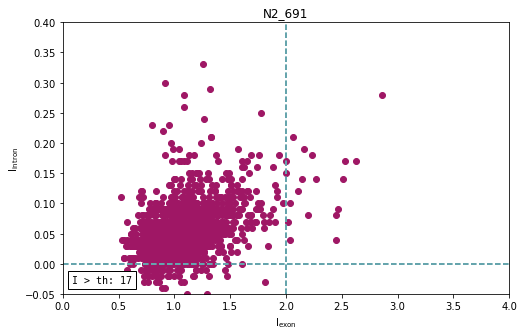

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_692.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_692.csv


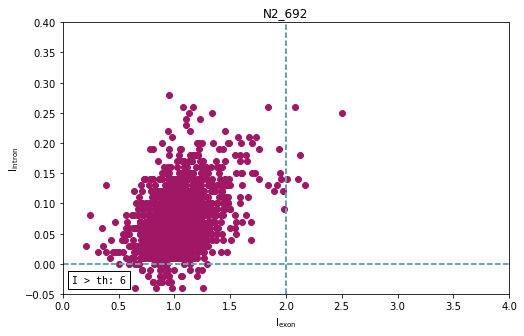

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_693.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_693.csv


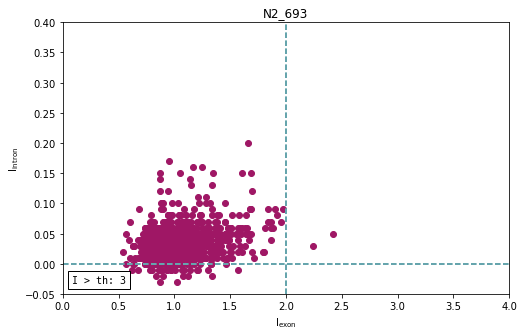

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_694.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_694.csv


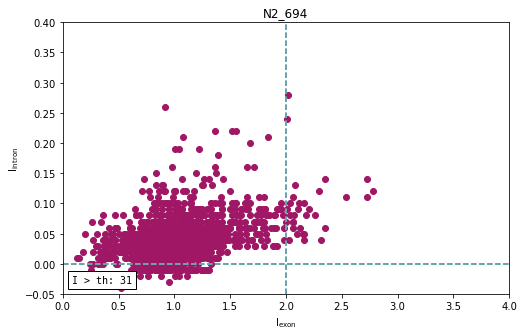

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_695.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_695.csv


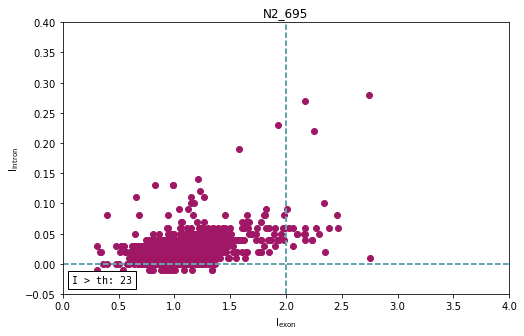

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_696.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_696.csv


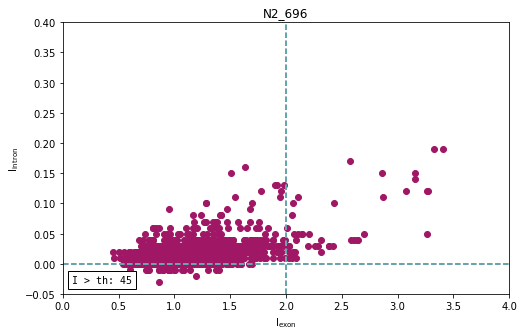

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_697.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_697.csv


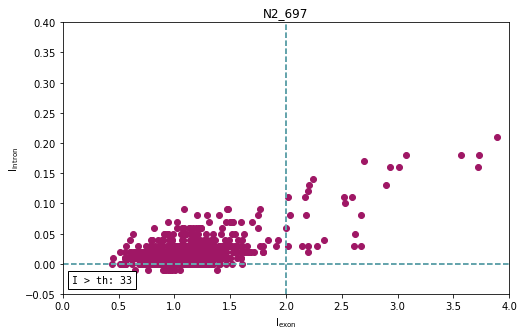

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_698.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_698.csv


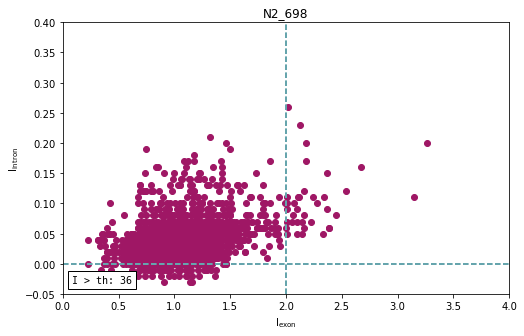

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_699.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_699.csv


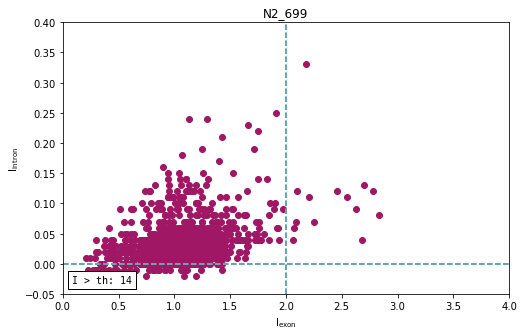

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_700.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_700.csv


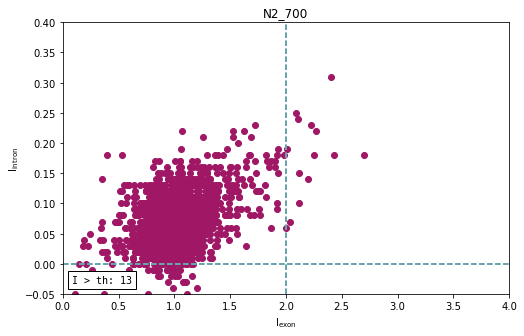

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_701.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_701.csv


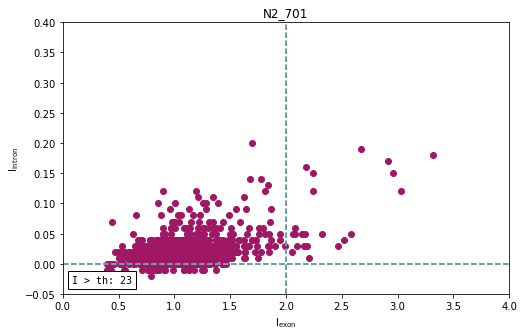

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_702.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_702.csv


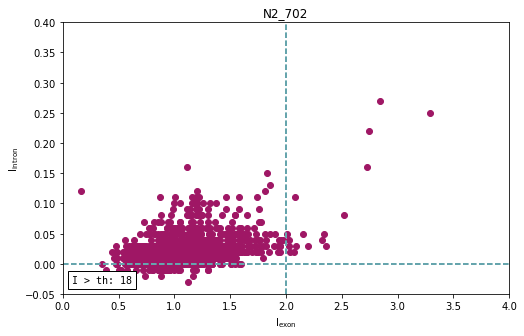

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_703.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_703.csv


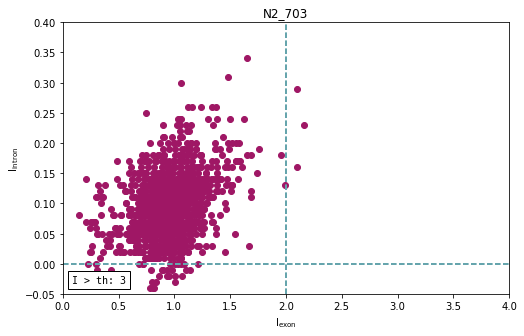

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_704.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_704.csv


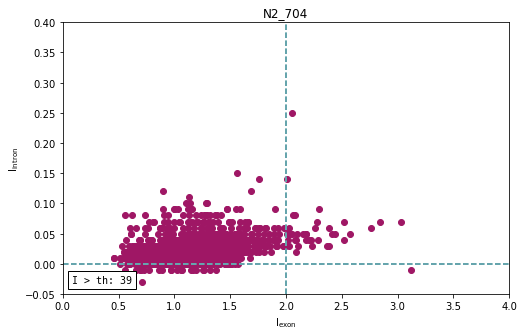

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_705.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_705.csv


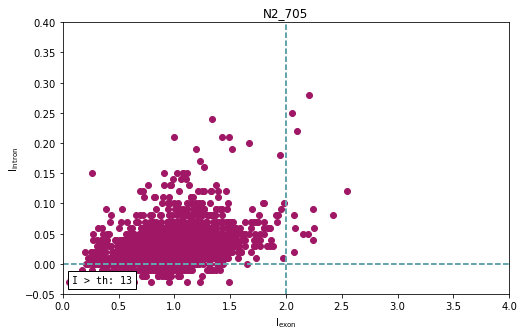

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_706.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_706.csv


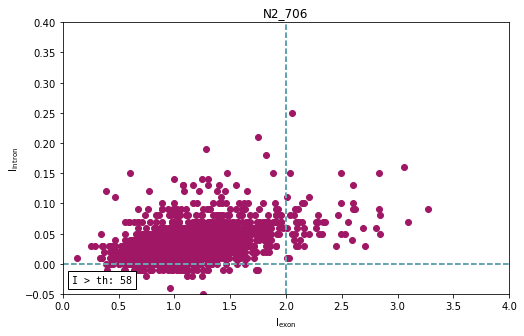

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_707.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_707.csv


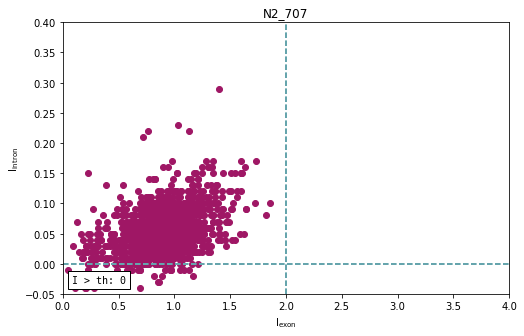

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_708.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_708.csv


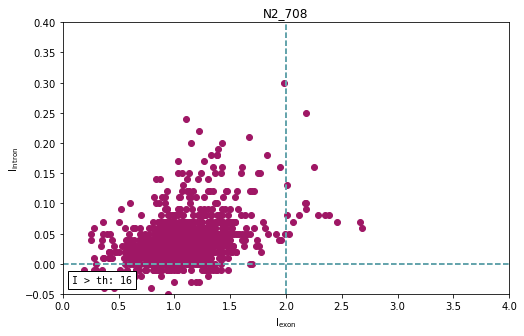

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_709.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_709.csv


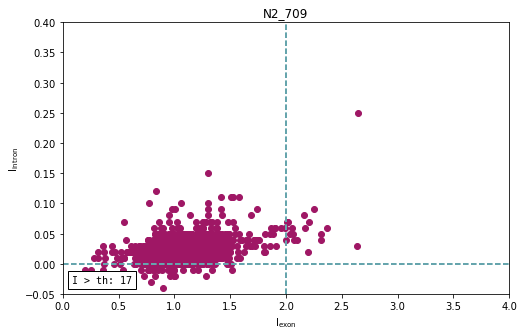

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_710.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_710.csv


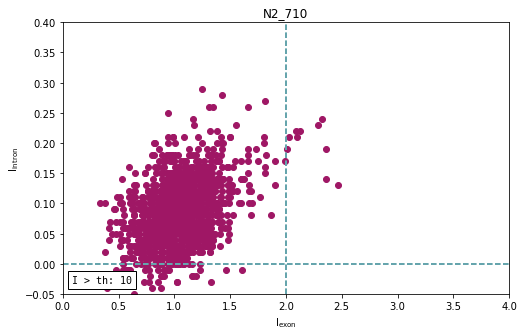

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_711.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_711.csv


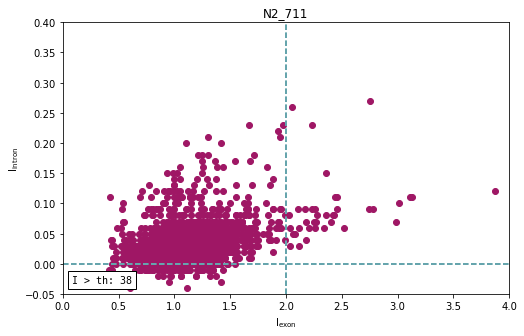

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_712.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_712.csv


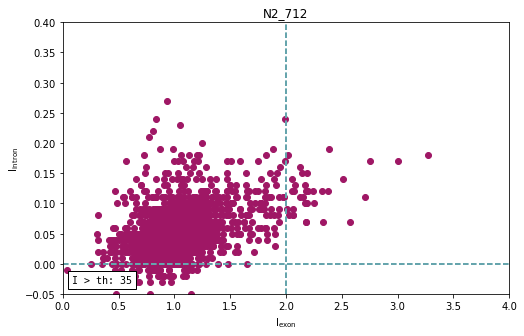

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_713.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_713.csv


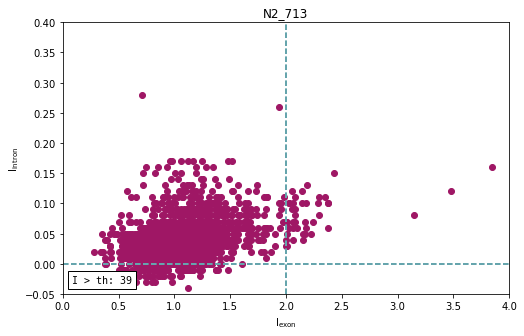

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_714.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_714.csv


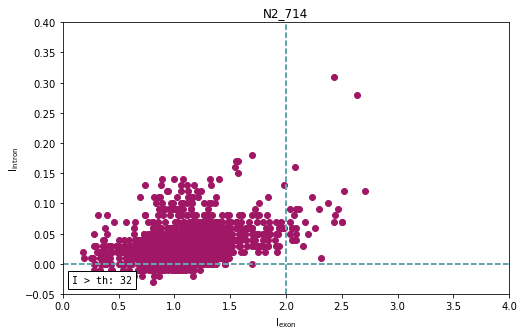

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_715.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_715.csv


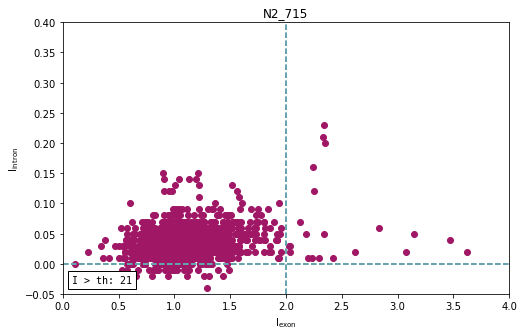

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_716.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_716.csv


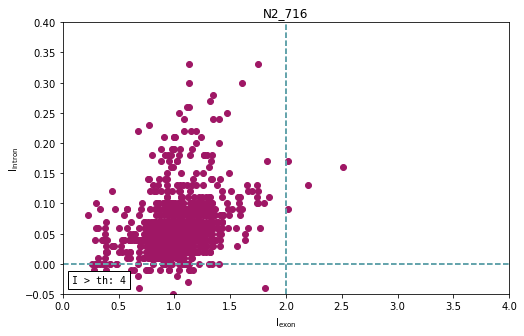

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_717.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_717.csv


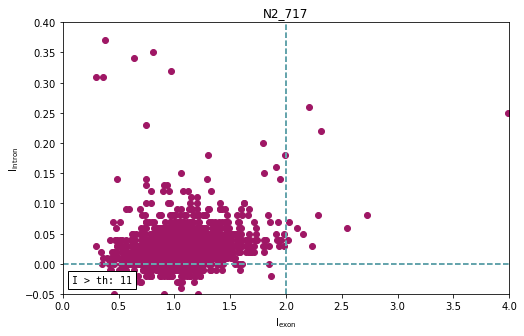

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_719.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_719.csv


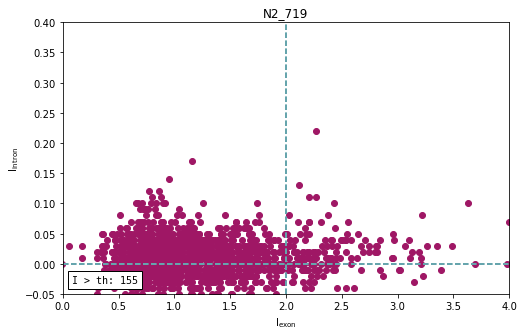

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_720.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_720.csv


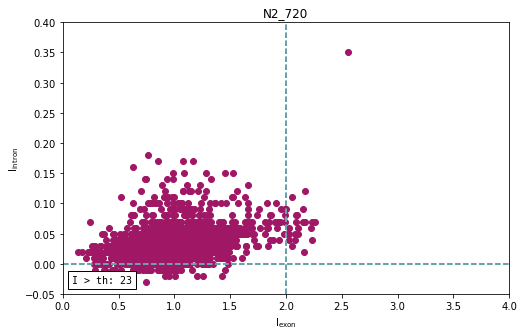

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_721.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_721.csv


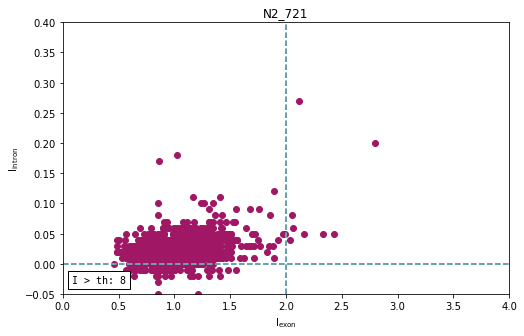

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_722.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_722.csv


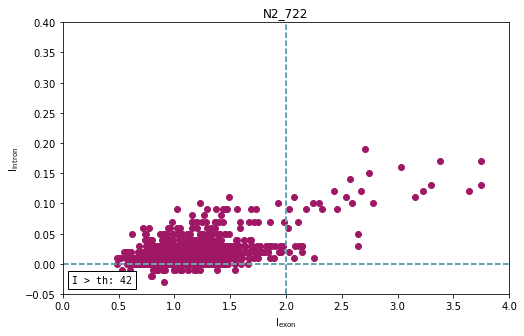

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_724.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_724.csv


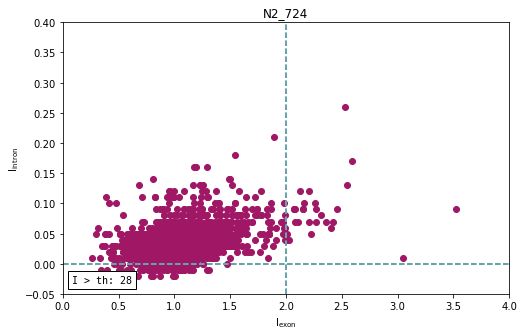

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_725.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_725.csv


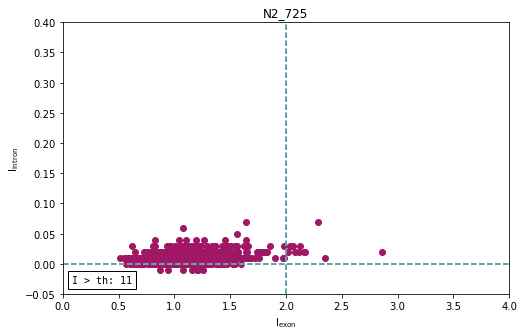

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_726.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_726.csv


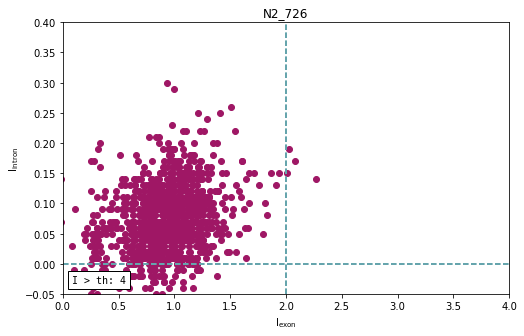

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_727.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_727.csv


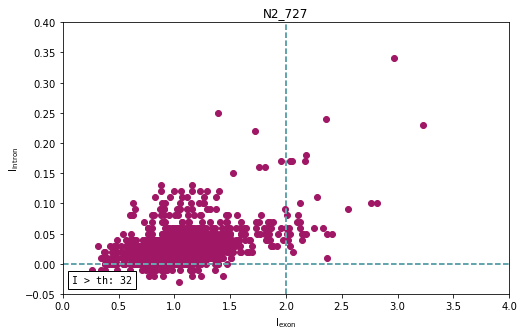

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_728.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_728.csv


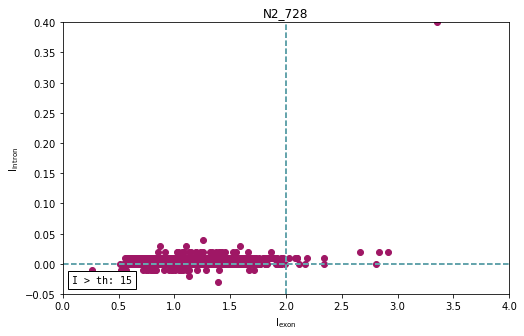

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_729.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_729.csv


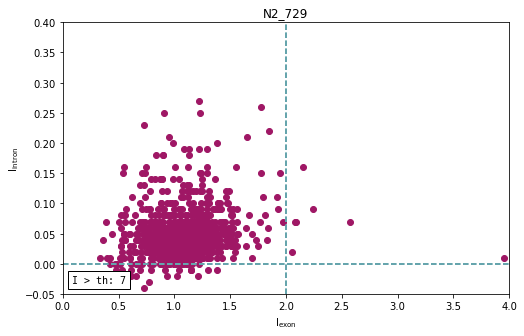

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_730.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_730.csv


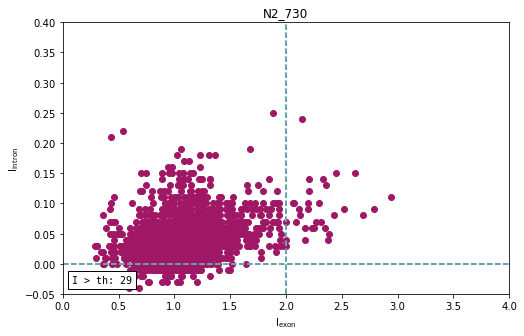

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_731.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_731.csv


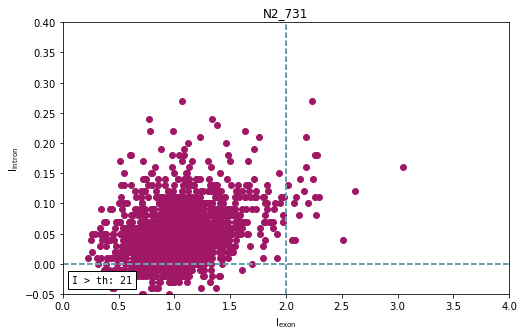

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_732.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_732.csv


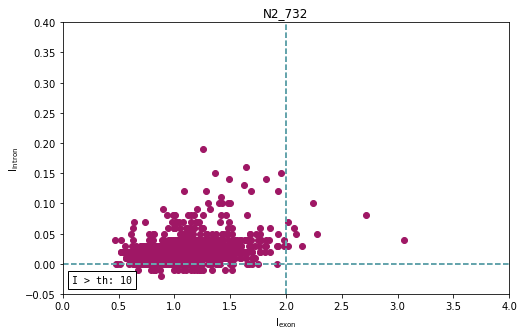

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_733.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_733.csv


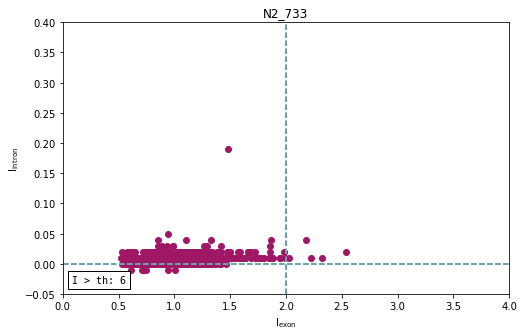

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_734.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_734.csv


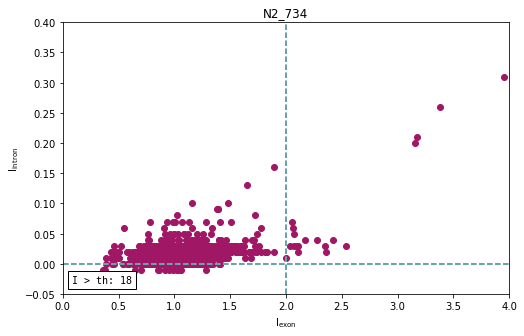

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_735.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_735.csv


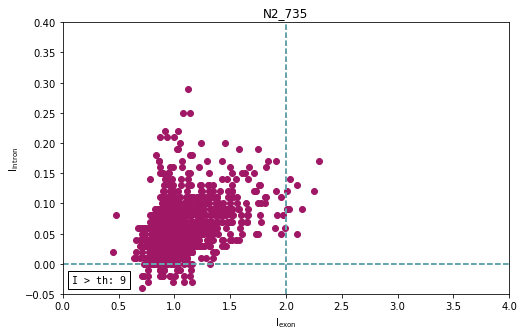

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_736.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_736.csv


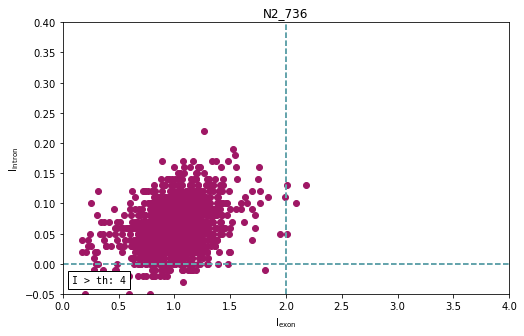

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_737.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_737.csv


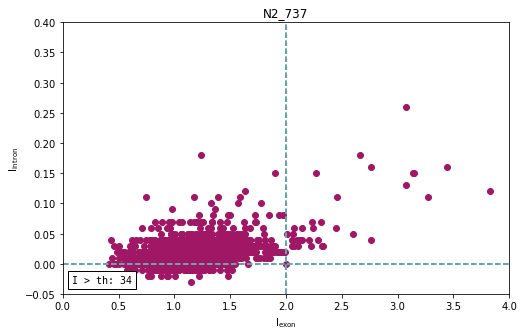

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_739.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_739.csv


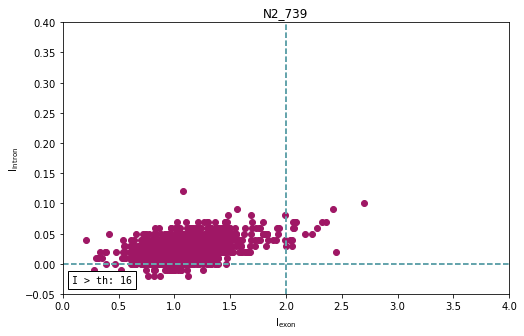

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_740.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_740.csv


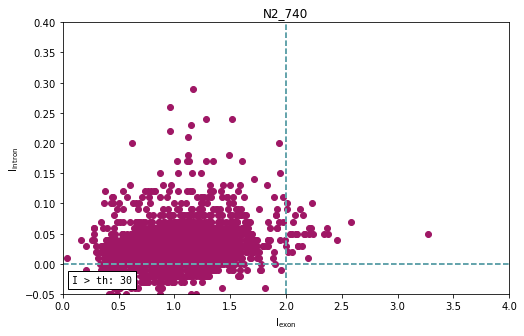

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_741.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_741.csv


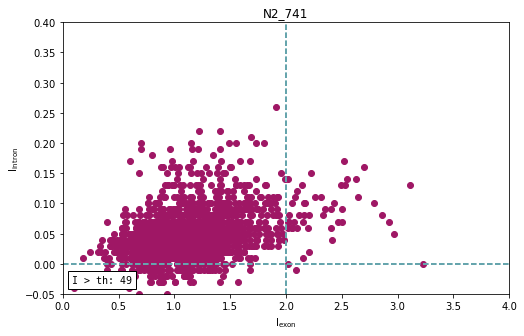

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_742.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_742.csv


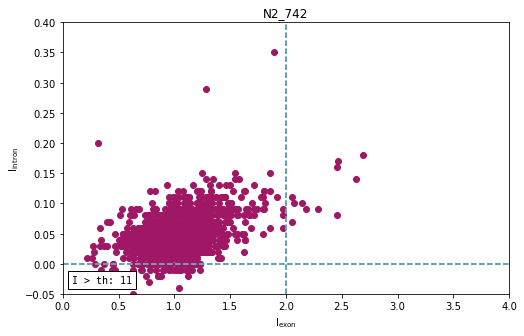

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_743.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_743.csv


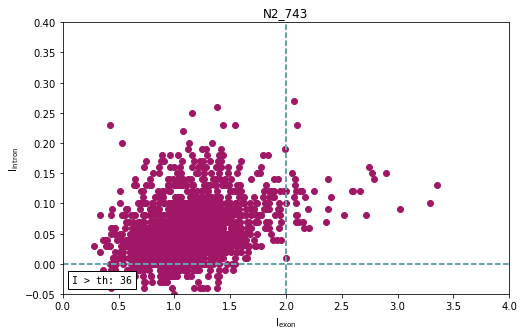

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_744.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_744.csv


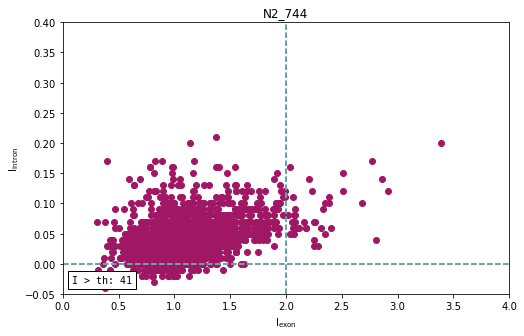

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_745.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_745.csv


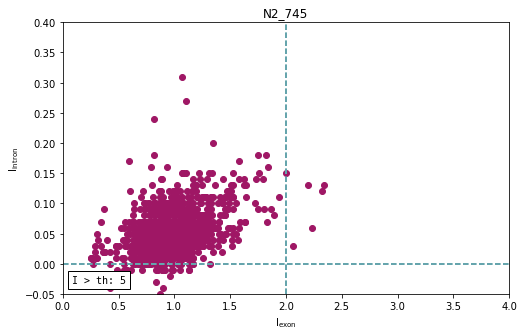

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_746.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_746.csv


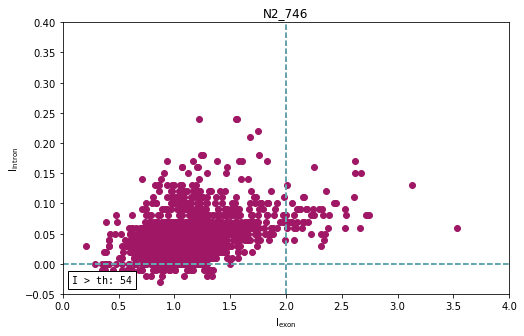

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_747.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_747.csv


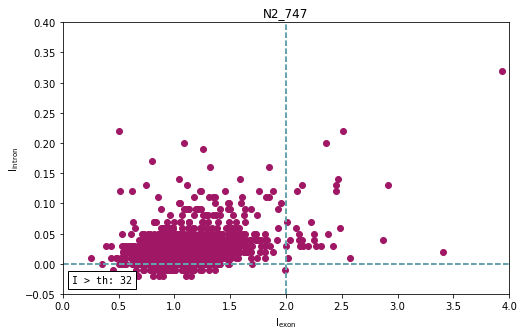

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_748.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_748.csv


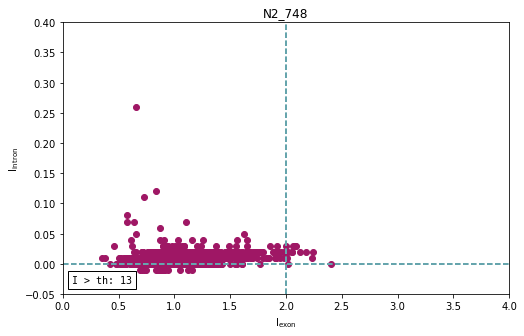

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_749.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_749.csv


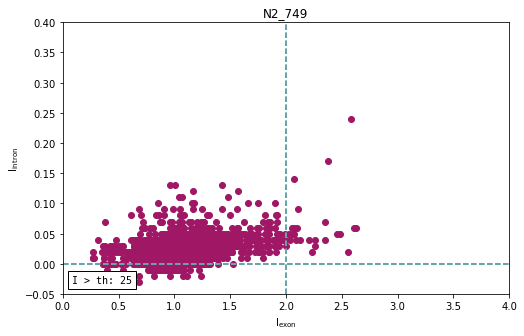

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_750.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_750.csv


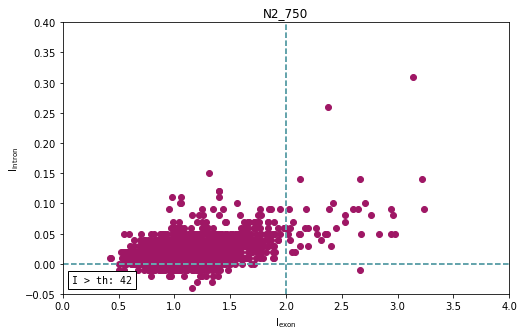

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_751.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_751.csv


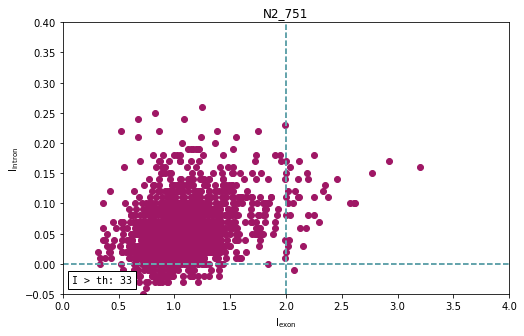

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_752.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_752.csv


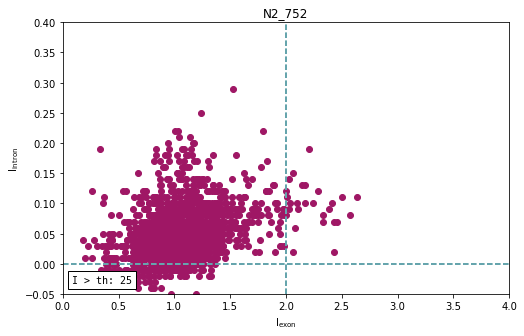

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_753.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_753.csv


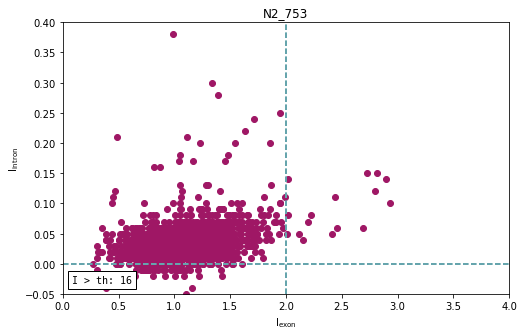

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_754.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_754.csv


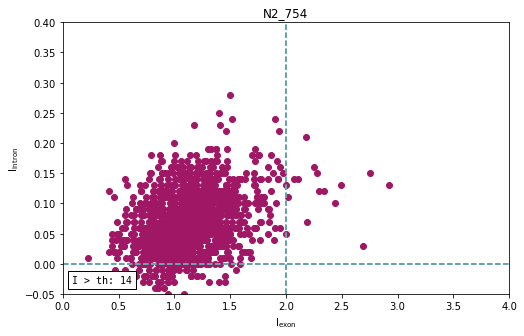

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_755.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_755.csv


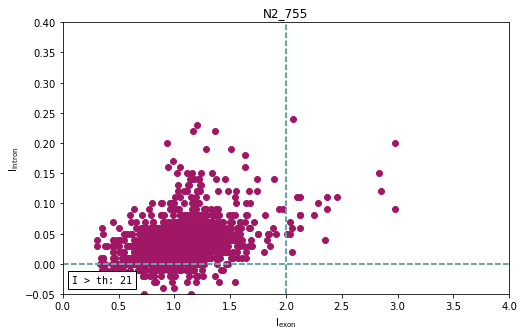

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_756.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_756.csv


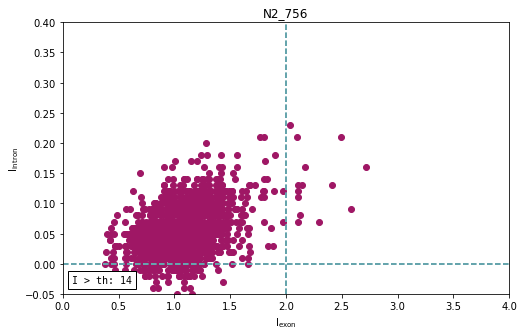

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_757.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_757.csv


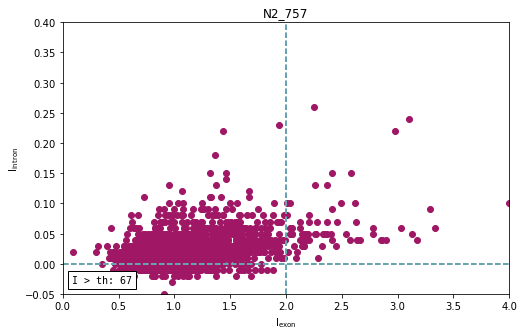

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_758.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_758.csv


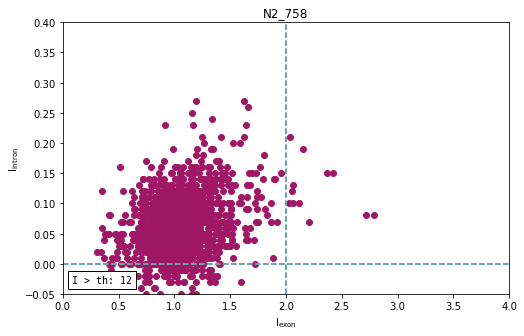

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_759.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_759.csv


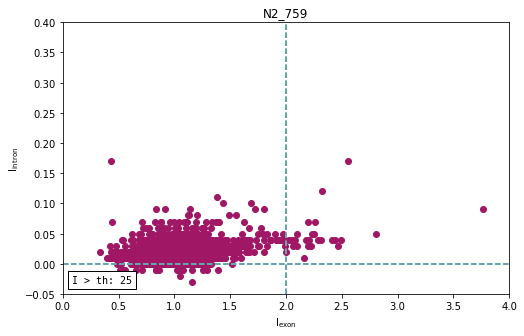

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_760.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_760.csv


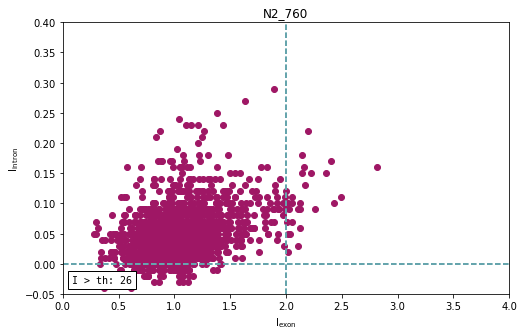

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_761.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_761.csv


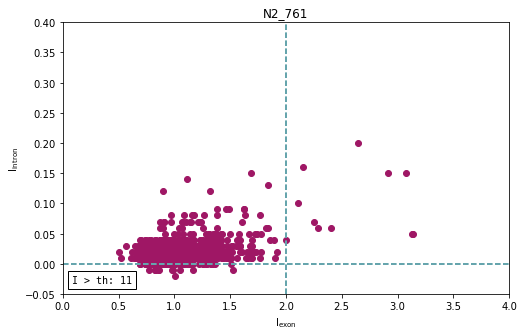

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_762.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_762.csv


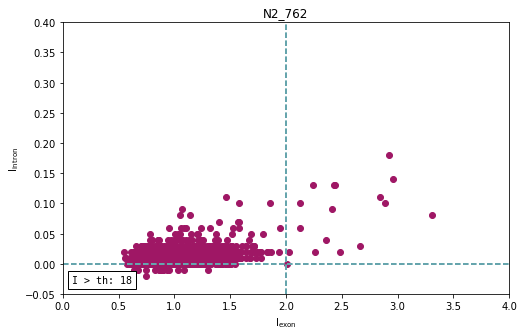

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_763.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_763.csv


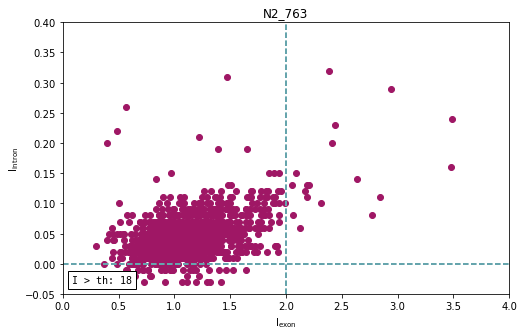

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_764.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_764.csv


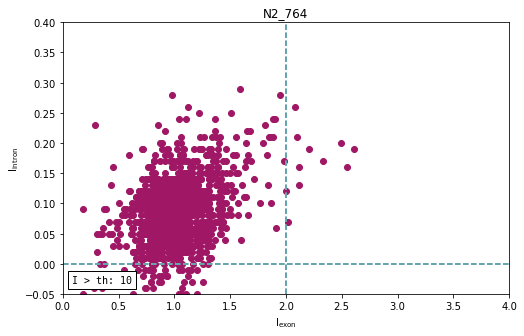

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_765.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_765.csv


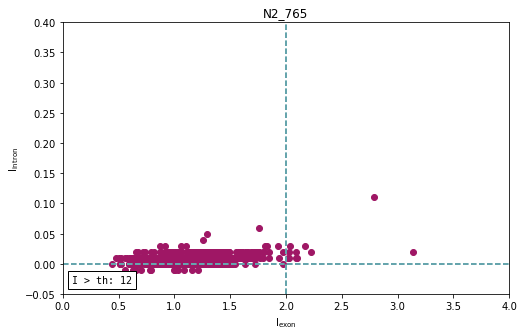

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_766.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_766.csv


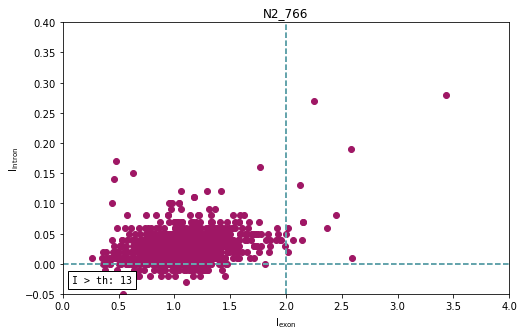

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_770.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_770.csv


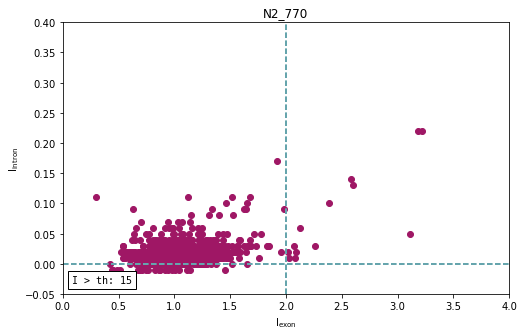

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_771.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_771.csv


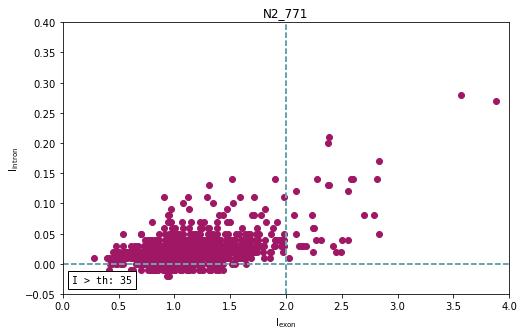

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_772.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_772.csv


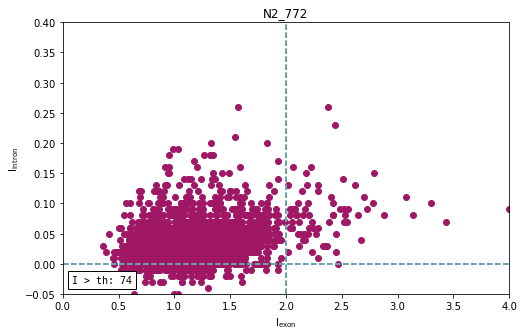

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_773.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_773.csv


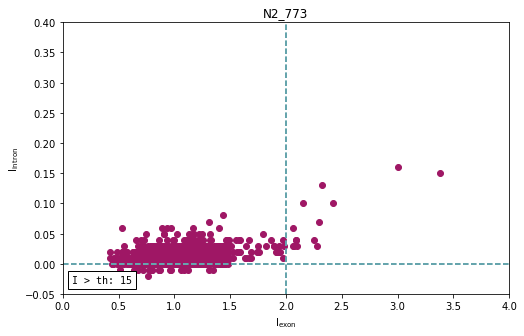

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_774.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_774.csv


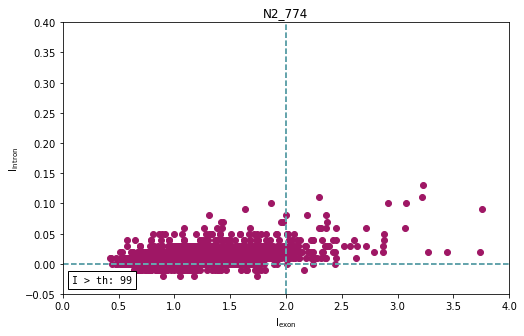

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_775.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_775.csv


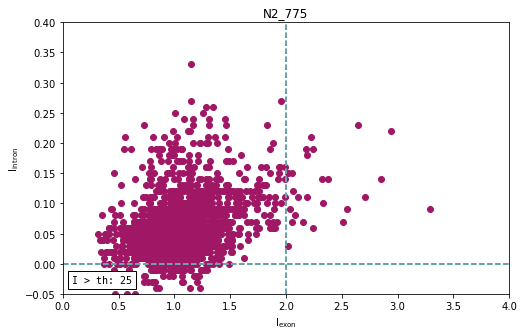

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_776.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_776.csv


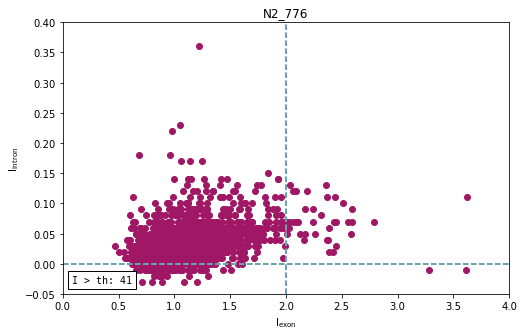

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_777.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_777.csv


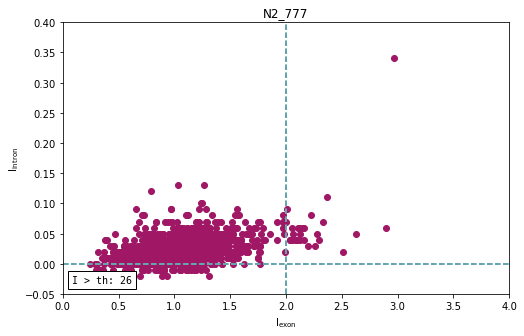

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_778.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_778.csv


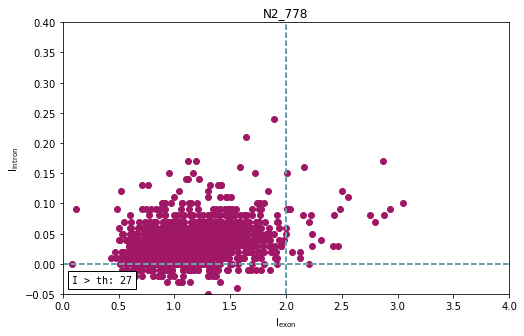

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_779.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_779.csv


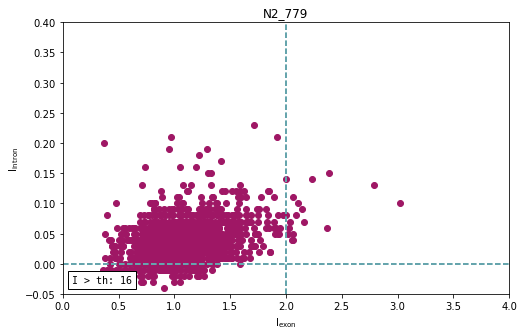

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_780.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_780.csv


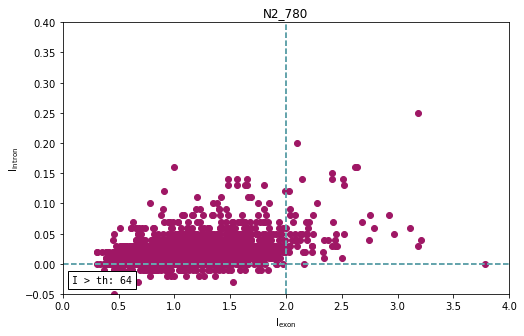

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_781.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_781.csv


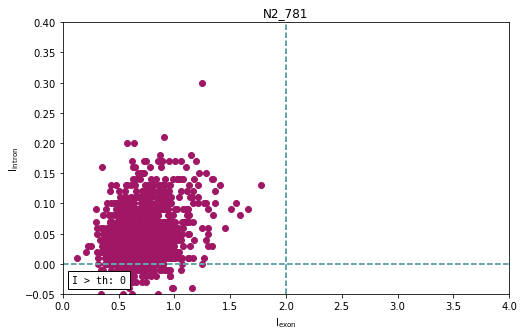

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_782.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_782.csv


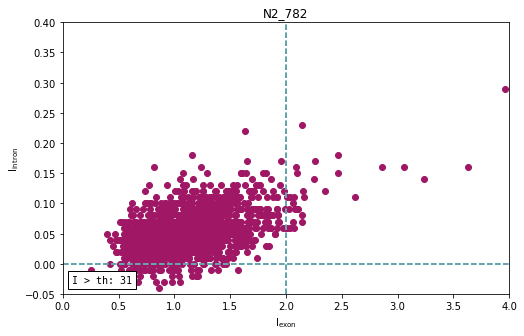

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_783.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_783.csv


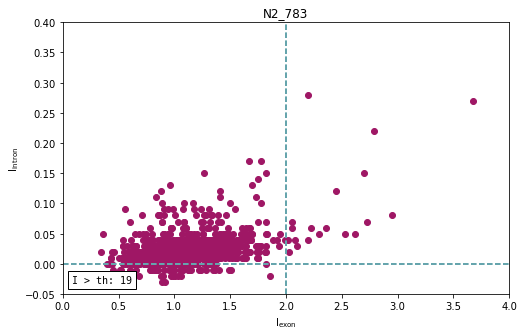

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_784.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_784.csv


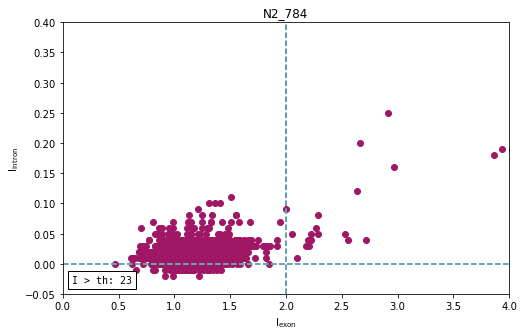

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_785.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_785.csv


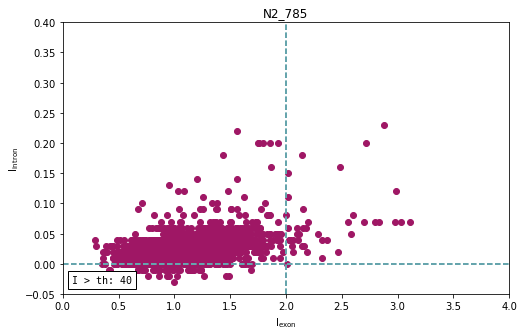

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_786.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_786.csv


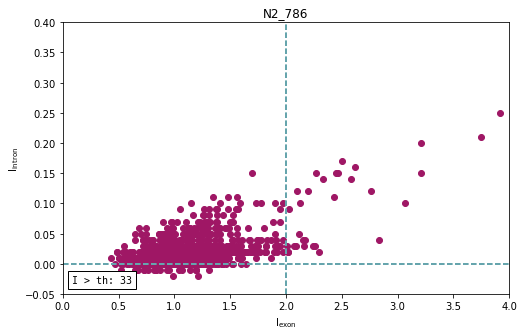

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_787.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_787.csv


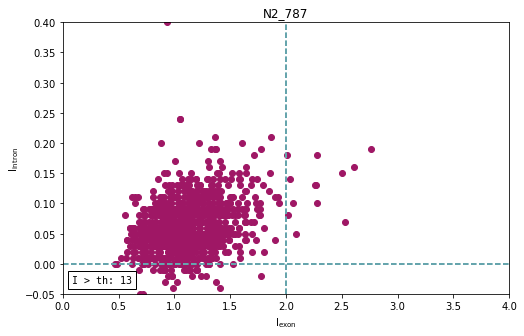

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_788.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_788.csv


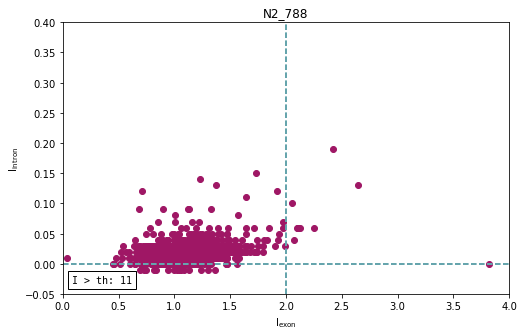

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_789.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_789.csv


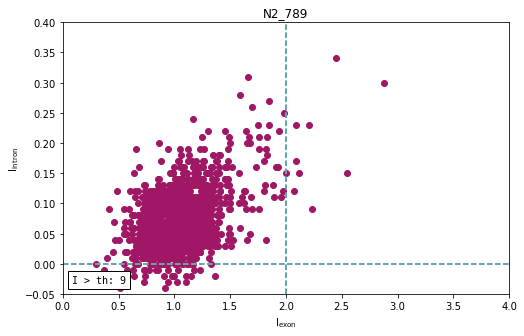

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_790.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_790.csv


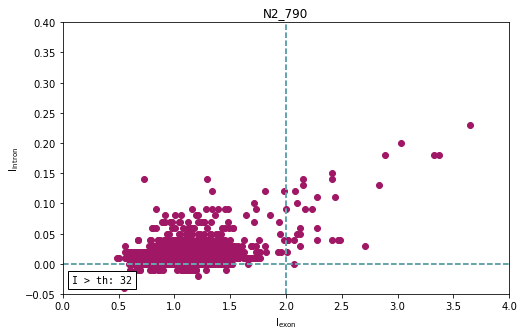

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_791.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_791.csv


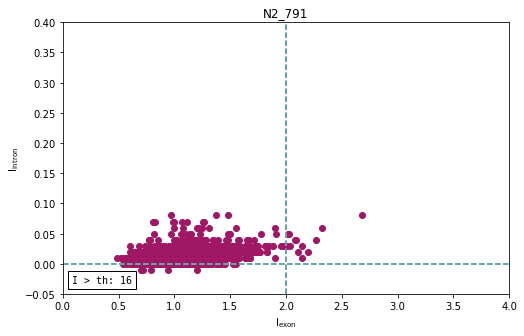

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_792.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_792.csv


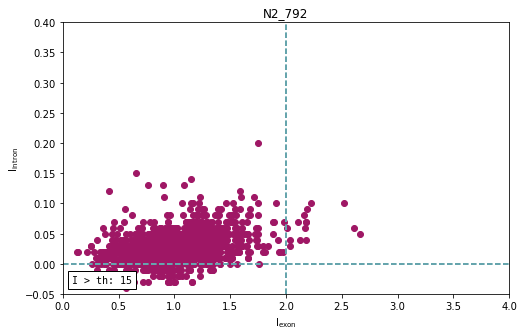

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_793.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_793.csv


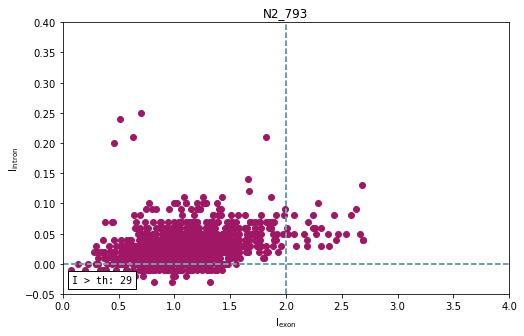

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_794.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_794.csv


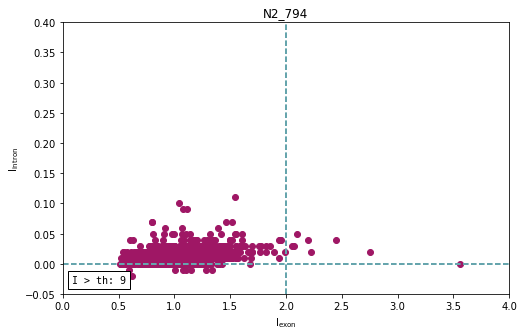

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_795.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_795.csv


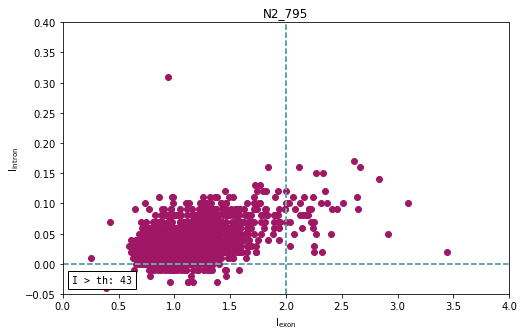

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_796.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_796.csv


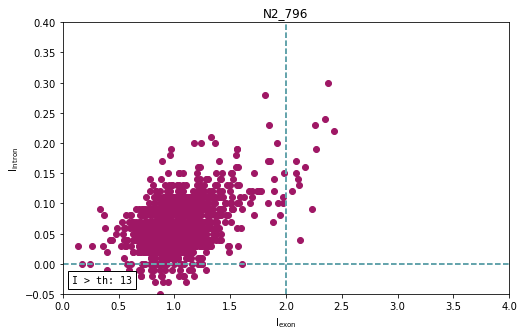

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_797.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_797.csv


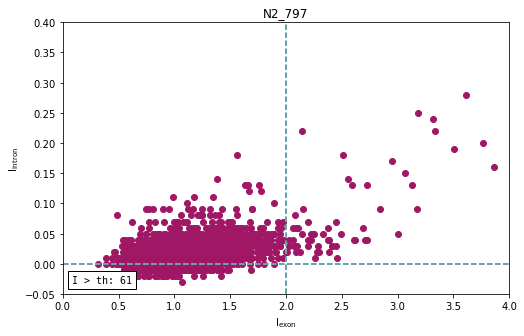

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_798.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_798.csv


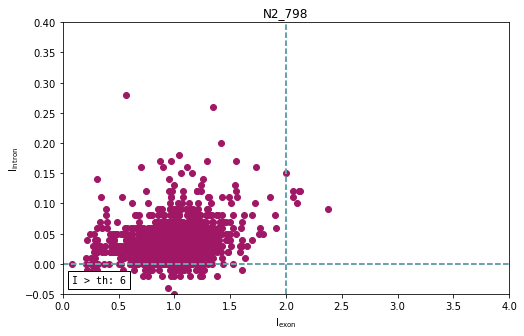

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_799.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_799.csv


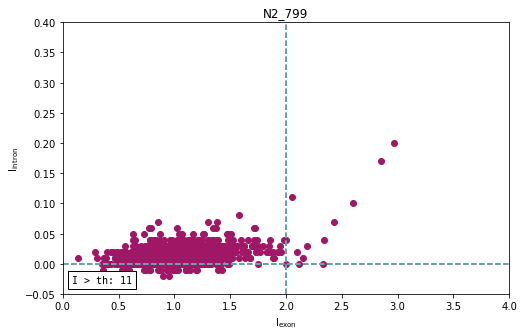

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_800.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_800.csv


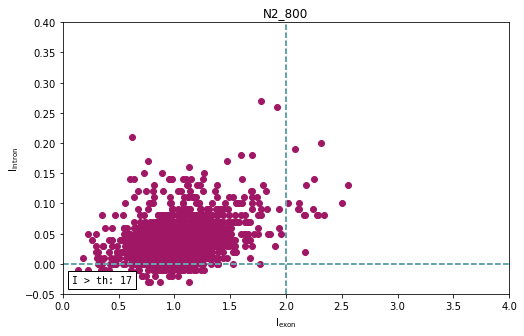

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_801.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_801.csv


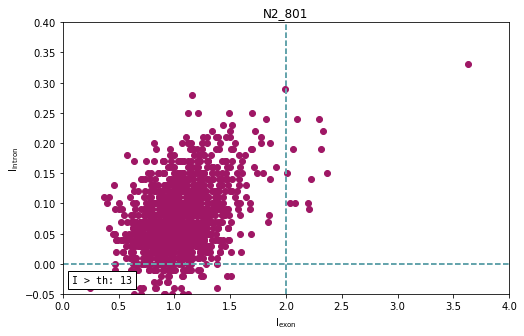

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_802.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_802.csv


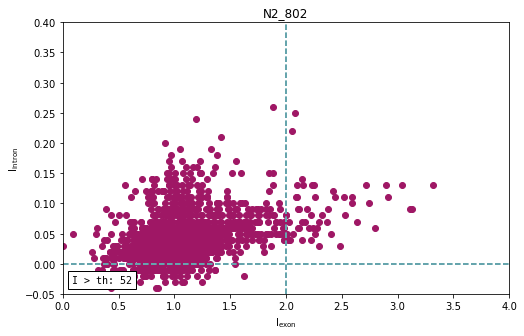

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_803.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_803.csv


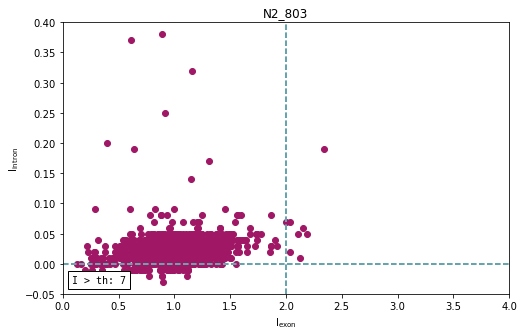

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_804.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_804.csv


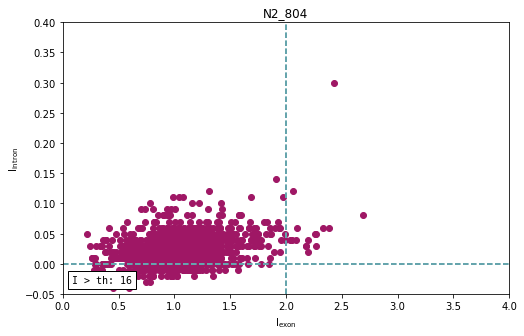

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_805.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_805.csv


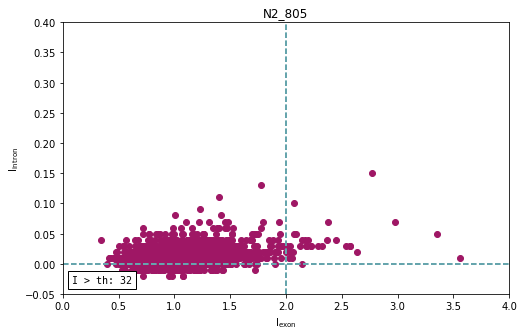

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_822.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_822.csv


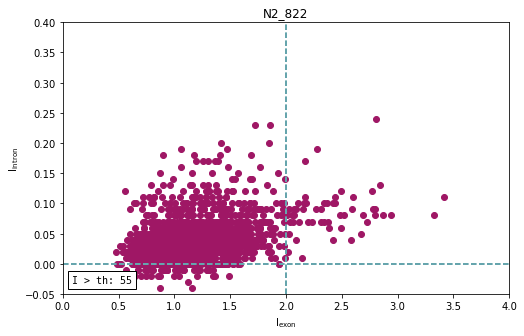

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_823.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_823.csv


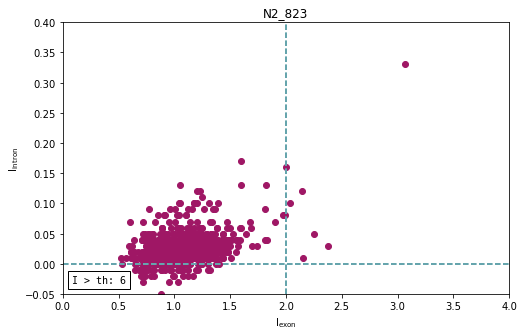

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_824.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_824.csv


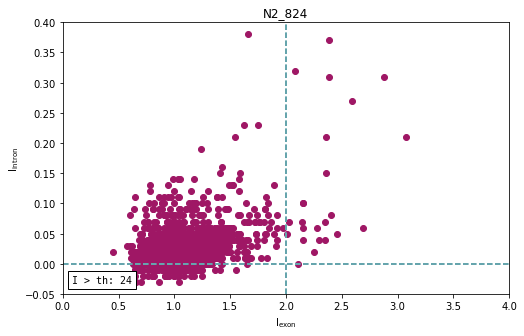

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_825.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_825.csv


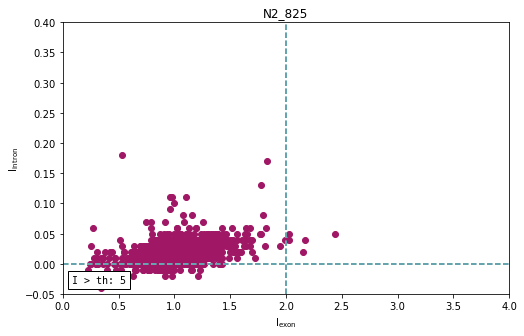

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_826.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_826.csv


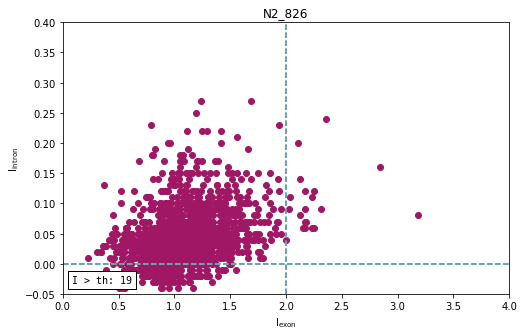

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_827.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_827.csv


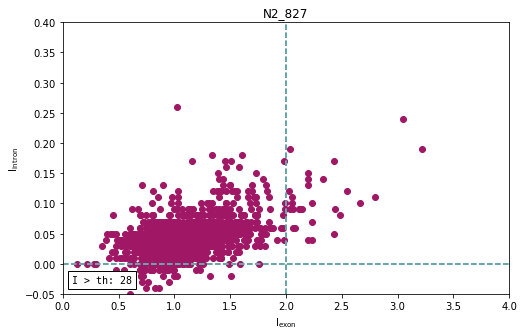

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_828.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_828.csv


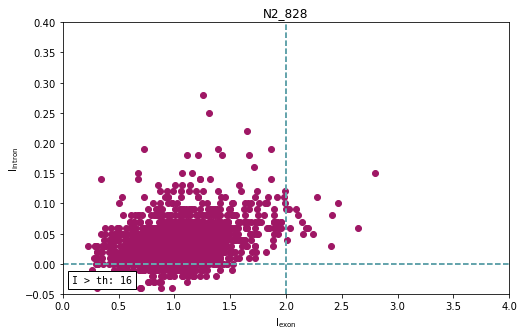

/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-dapi-intron/C3-N2_829.csv
/Users/kkolyva/Downloads/2018-09-11-11-12-10-clean-up/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_829.csv


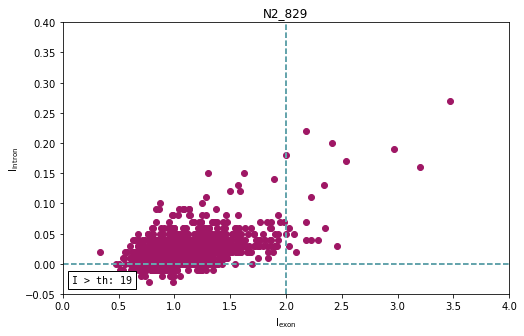

In [29]:
# me use the locations only but no the intensities here 
# that is why we use csv-before folder
for img_name_dpy23_ex_dpy23_int in dataset_dpy23_ex_dpy23_int:
    
    img_name_dpy23_ex = img_name_dpy23_ex_dpy23_int[0]
    img_name_dpy23_int = img_name_dpy23_ex_dpy23_int[1]
       
    s_dataset_dpy23_int = folder_path + "csv-dapi-intron/" + img_name_dpy23_int + ".csv"
    # ps_dataset_dpy23_int = folder_path + "csv-parameters/" + img_name_dpy23_int + ".csv"

    s_dataset_dpy23_ex = folder_path + "csv-2/" + img_name_dpy23_ex + ".csv"
    # ps_dataset_dpy23_ex = folder_path + "csv-parameters/" + img_name_dpy23_ex + ".csv"
    
    if(not os.path.exists(s_dataset_dpy23_int) or not os.path.exists(s_dataset_dpy23_ex)):
        continue
    
    try:
        print(s_dataset_dpy23_int)
        print(s_dataset_dpy23_ex)
        
        loc_dpy23_ex, I_dpy23_ex = load_data(s_dataset_dpy23_ex)
        I_dpy23_int = load_data_intron(s_dataset_dpy23_int)  
        
        threshold = 2
        # I_pair_dpy23_ex_dpy23_int, loc_pair_dpy23_ex_dpy23_int = find_matches(I_dpy23_ex, loc_dpy23_ex, I_dpy23_int, loc_dpy23_int, threshold)
        
        # feedback
        plt.figure(figsize=(8,5))
        title = create_title(s_dataset_dpy23_int, name_id=-1)[3:]
        plt.title(title)
        
        plt.plot(I_dpy23_ex, I_dpy23_int, 'o', color='#9F1765', linewidth=5)
        intensity_th = 2
        plt.axvline(x=intensity_th, linestyle="--", linewidth=2, color='#66A5AD')
        plt.axhline(y=0, linestyle="--", linewidth=2, color='#66A5AD')
        
        
        x_limits = [0, 4]
        y_limits = [-0.05, 0.4]
        
        axes = plt.gca()
        axes.set_xlim(x_limits)
        axes.set_ylim(y_limits)

        plt.xlabel('$\mathregular{I_{exon}}$')
        plt.ylabel('$\mathregular{I_{intron}}$')
        
        # info_text_dpy23 =     "Coeff (dpy23)    : " + str(['%.2e' % elem for elem in coeff_dpy23])
        # info_text_mdh1 =      "Coeff (mdh1)     : " + str(['%.2e' % elem for elem in coeff_mdh1])
        # info_text_dpy23_int = "Coeff (dpy23_int): " + str(['%.2e' % elem for elem in coeff_dpy23_int])
        
        # info_text = info_text_dpy23 + "\n" + info_text_mdh1 + "\n" + info_text_dpy23_int
        # plt.text(x_limits[0] + (x_limits[1] - x_limits[0])*0.02, y_limits[0] + (y_limits[1] - y_limits[0])*0.04, info_text, color='black', bbox=dict(facecolor='white', alpha=1), family='monospace')

        total_I_above_threshold = np.sum(I_dpy23_ex > intensity_th);
        info_text = get_info(total_I_above_threshold)
        plt.text(x_limits[0] + (x_limits[1] - x_limits[0])*0.02, y_limits[0] + (y_limits[1] - y_limits[0])*0.04, info_text, color='black', bbox=dict(facecolor='white', alpha=1), family='monospace')
        
        # plt.legend(loc = 'upper right')
        full_path_to_use = folder_path + "img-exon-intron/" 
        if not os.path.exists(full_path_to_use):
            os.makedirs(full_path_to_use)
        plt.savefig(full_path_to_use + title + "-exon-intron.pdf")
        
        plt.show()
        #ValueError , RuntimeError, IndexError
    except(StopIteration):
        print("Caught the error for you")
        
#    break